## Project 3 - Galaxy Evolution

Names: Robert Crager and Esther Kalemba
- change the location of `NFW_dispersion.dat` in the `import_velocities()` function if need be
  - (it's used in the creation of the Disk model from project 2)
- Also see the attached `output.mp4` file for the simulation of section 3.5

#### Import Functions


In [1]:
### Import Functions
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from scipy import special
from matplotlib.colors import LogNorm
#from google.colab import drive
from scipy.interpolate import interp1d
from scipy.integrate import quadrature

######## CONSTANTS ###########
const_G = 1.     # gravitational constant

### Scaling Constants ####
# assuming we're using 1 for units of the following
# R_vir = 1
# M_vir = 1
# G = 1

# then scaling them up is as follows

const_R_scale = 300   # radius in kpc
const_M_scale = 10e12 # Mass in solar masses (latex is $\M_\odot$) \(M_\odot\) ,or
const_V_scale = 120   # Velocity in km/s
const_P_scale = 3.7e4 # Spherical Density in solar mass/kpc^3
const_Sig_scale = 1.1e7 # Cylindrical Density in solar mass/kpc^2
const_T_scale = 2.44  # Time scale up in Giga years (Gyr)

##########################
##############################

###### CONVERSION FUNCTIONS #############

def scale_up(radius=0.,mass=0.,velocity=0.,p_density=0.,sig_density=0.):
  '''
  Function to return the full scaled up parameters for galaxy.
  '''
  return radius*const_R_scale,mass*const_M_scale,velocity*const_V_scale,p_density*const_P_scale,sig_density*const_Sig_scale

def sph_to_cart(r,theta,phi):
  '''
  function to convert to cartesian from spherical
  returns x,y,z values for given spherical coordinates
  '''
  x = r*np.cos(phi)*np.cos(theta)
  y = r*np.sin(phi)*np.cos(theta)
  z = r*np.sin(theta)
  return x,y,z

def cyl_to_cart(r,theta,z):
  '''
  function to convert to cartesian from cylindrical
  returns x,y,z values for given spherical coordinates
  '''
  x = r*np.cos(theta)
  y = r*np.sin(theta)
  return x,y,z
########################################

####### Random Distribution Function #######

def gen_rand_sph_coor(NUMPART):
  '''
  Generates random (uniform) distribution for angle phi and angle theta in spherical coordinates
  '''

  r = RandomState()
  # phi = azimuthal angle φ is just a random number uniformly distributed in [0, 2π].
  # use this to find the location of particle in xyz coordinate space and assign it accordingly
  ang_phi = (2*np.pi)*r.rand(NUMPART)  # uniform distribution for [0,2pi+(pi/72)] (so it's inclusive of 2pi) for number of particles
  # The elevation angle θ is almost as simple but instead of θ
  # being a random number uniformly distributed in [−π/2, π/2] it is cos θ that is a random number uniformly distributed in [−1, 1].
  # use this to find the location of particle in xyz coordinate space and assign it accordingly
  x = r.rand(NUMPART)
  x = r.uniform(-1,1,NUMPART)
  #sign = r.rand(NUMPART)
  #pos_ind = np.where(sign>0.5)[0]
  #neg_ind = np.where(sign<0.5)[0]
  #sign[pos_ind] = 1
  #sign[neg_ind] = -1
  ang_theta = np.arccos(x)-np.pi/2
  return ang_phi,ang_theta


############################################

##### Check and Plotting Functions ######

def check_densities_sphere(radius_dists,total_radius,total_mass,density_func,num_particles):
  '''
  Take volume and mass of # of shells to confirm the particle distribution is the same as the density distribution.
  '''
  # now confirm that we're getting the right density distribution
  shells = 2000 # number of steps to check spherical shells
  shell_densities = np.zeros(shells)
  prev_dr = 0
  part_mass = total_mass/num_particles

  for i in range(1,shells):
    # find volume of shell, then get mass at radius, then find density and confirm?
    dr = (total_radius/shells)*i
    condition = np.where((radius_dists<dr) & (radius_dists>prev_dr))[0] # number of radius' that meet condition
    mass_of_shell = part_mass*(len(condition)) # total mass within a shell bc all particles are same mass (part_mass)
    volume_of_shell = ((4/3)*np.pi*dr**3)-((4/3)*np.pi*prev_dr**3)
    shell_densities[i-1] = mass_of_shell/volume_of_shell    # find density of shell

    prev_dr = dr    # set prev_dr value to move to next step



  # plot the results (don't think we need to return the shell_densities?)
  xs = np.linspace(0,total_radius,100)[1:]
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
  fig.suptitle('Accept-Reject Technique', fontsize=20)
  ax1.hist(radius_dists,density=True,bins=50,color='orange')
  ax1.plot(xs,(4*np.pi*xs**2)*density_func(xs),'b')
  ax1.set_ylabel(r'4$\pi r^2 \rho(r)$')
  ax1.set_xlabel('r')

  radius_plot = total_radius/shells*np.arange(1,shells+1)

  ax2.plot(radius_plot*const_R_scale,shell_densities*const_P_scale,'g--',label='Model')
  ax2.plot(radius_plot*const_R_scale,density_func(radius_plot)*const_P_scale,'b',label='True')
  ax2.set_xscale('log')
  ax2.set_yscale('log')
  #ax2.set_xlim(1E0,total_radius*const_R_scale)
  ax2.legend(loc='best')
  ax2.set_title('Spherical Halo')
  ax2.set_ylabel(r'Surface Density ($M_{\odot}/kpc^2$)')
  ax2.set_xlabel('Radius (kpc)')
  plt.show()

def check_densities_disk(radius_dists,total_radius,total_mass,density_func,num_particles):
  '''
  Take circumference and mass of # of shells to confirm the particle distribution is the same as the surface density distribution.
  '''
  # now confirm that we're getting the right density distribution
  shells = 2000 # number of steps to check spherical shells
  shell_densities = np.zeros(shells)
  prev_dr = 0
  part_mass = total_mass/num_particles

  for i in range(1,shells):
    # find volume of shell, then get mass at radius, then find density and confirm?
    dr = (total_radius/shells)*i
    condition = np.where((radius_dists<dr) & (radius_dists>prev_dr))[0] # number of radius' that meet condition
    mass_of_shell = part_mass*(len(condition)) # total mass within a shell bc all particles are same mass (part_mass)
    volume_of_shell = (np.pi*dr**2)-(np.pi*prev_dr**2)
    shell_densities[i-1] = mass_of_shell/volume_of_shell    # find density of shell

    prev_dr = dr    # set prev_dr value to move to next step

  xs = np.linspace(0,total_radius,100)
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
  fig.suptitle('Accept-Reject Technique', fontsize=20)
  #ax1.hist(radius_dists,density=True,bins=50,color='orange')
  ax1.hist(radius_dists/total_radius,density=True,bins=50,color='orange')
  ax1.plot(xs/total_radius,2.5*np.pi*(xs)*density_func(xs),'b')
  #ax1.set_title('Accept-Reject Technique')
  ax1.set_ylabel(r'2$\pi r\Sigma(r)$')
  ax1.set_xlabel('r')
  #plt.show()

  radius_plot = total_radius/shells*np.arange(1,shells+1)

  ax2.plot(radius_plot*const_R_scale,shell_densities*const_Sig_scale,'g--',label='Model')
  ax2.plot(radius_plot*const_R_scale,density_func(radius_plot)*const_Sig_scale,'b',label='True')
  ax2.set_yscale('log')
  ax2.set_xlim(1E-3,total_radius*const_R_scale)
  ax2.legend(loc='best')
  ax2.set_title('Exponential Disk')
  ax2.set_ylabel(r'Surface Density ($M_{\odot}/kpc^2$)')
  ax2.set_xlabel('Radius (kpc)')
  plt.show()

def graph_particle_dist(part_info,title,eq_num=0.):
  '''
  Make graphs of the results and showcase equilibrium value,
  given particle_info array, Title of graph, and eqilibrium factor (=2T/W) (should be =1).
  '''
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

  fig.suptitle('Particle Distribution', fontsize=20)
  if(eq_num != 0.):  # otherwise we're not wanting to print the EQ check
      fig.text(0.5, 0.01, f'{title} Model Equilibrium Check (2T/W): {eq_num:.3f}', wrap=True, horizontalalignment='center', fontsize=12)
  ax1.set_xlabel('x (kpc)')
  ax1.set_ylabel('y (kpc)')
  ax1.set_title(title)
  ax1.hist2d(part_info[:,1]*const_R_scale,part_info[:,2]*const_R_scale,bins=(50,50),norm=LogNorm(),cmap=plt.cm.jet)
  ax1.set_aspect('equal')

  ax2.set_xlabel('x (kpc)')
  ax2.set_ylabel('z (kpc)')
  ax2.set_title(title)
  ax2.hist2d(part_info[:,1]*const_R_scale,part_info[:,3]*const_R_scale,bins=(50,50),norm=LogNorm(),cmap=plt.cm.jet)
  ax2.set_aspect('equal')
  plt.show()

def graph_los_vel(part_info,r_dists,v_c_func,ax1=None,title='Line of Sight Velocity'):
  '''
  Function to plot line of sight velocities (doppler shift) given
  particle information from part_info array
  '''

  # also add padding to graphs so that last few points show up and not cut off by graph
  pad = 10.
  ylim = np.max(part_info[:,5]*const_V_scale)+pad
  xlim = np.max(part_info[:,1]*const_R_scale)
  # if we want side by side graphs, ax1 will !=None
  if(ax1==None):
    # make a regular full size plot
    plt.xlabel('Projected radius (kpc)')
    plt.ylabel('Line of Sight Velocity (km/sec)')
    plt.title(title)
    plt.hist2d(part_info[:,1]*const_R_scale,(part_info[:,5])*const_V_scale,bins=(50,50),norm=LogNorm(),cmap=plt.cm.jet,range=[[-xlim, xlim], [-ylim, ylim]])
    plt.show()
  else:
    # make a side-by-side graph
    #fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
    ax1.set_xlabel('Projected radius (kpc)')
    ax1.set_ylabel('Line of Sight Velocity (km/sec)')
    ax1.set_title(title)
    ax1.hist2d(part_info[:,1]*const_R_scale,(part_info[:,5])*const_V_scale,bins=(50,50),norm=LogNorm(),cmap=plt.cm.jet,range=[[-xlim, xlim], [-ylim, ylim]])



def graph_circ_vel(part_info,r_dists,v_c_func,ax2):
  '''
  Function to plot the circular velocity as a function of radius given
  particle information and radius information.
  '''
  velr_alone = np.sqrt(part_info[:,4]**2+part_info[:,5]**2)
  ax2.scatter(r_dists,velr_alone,c='blue',label='Model')
  ax2.set_xlabel('radius')
  ax2.set_ylabel('circular velocity')
  ax2.scatter(r_dists,v_c_func(r_dists),c='orange',label='True',s=3)
  ax2.legend(loc='best')

########################################

######### Tilt Galaxy ##################
def incline_galaxy(particle_info,angle):
    '''
    Incline galaxy along the x-axis by angle in radians
    '''
    # reduce the y velocities by cos(angle)
    # x axis coordinates don't change,
    # the y = ycos(0)+zsin(0)
    # the z = zcos(0)+ysin(0)?
    # maybe same for velocities?
    #new_ys = particle_info[:,2]*np.cos(angle)+particle_info[:,3]*np.sin(angle)
    new_ys = particle_info[:,2]*np.cos(angle)-particle_info[:,3]*np.sin(angle)
    new_zs = particle_info[:,2]*np.sin(angle)+particle_info[:,3]*np.cos(angle)
    #new_zs = particle_info[:,3]*np.cos(angle)+particle_info[:,2]*np.sin(angle)

    angle -= np.pi/2. # bc Velocity is pi/2. relative to inclination angle?
    new_vy = particle_info[:,5]*np.cos(angle)-particle_info[:,6]*np.sin(angle)
    new_vz = particle_info[:,5]*np.sin(angle)+particle_info[:,6]*np.cos(angle)
    particle_info[:,2] = new_ys
    particle_info[:,3] = new_zs
    particle_info[:,5] = new_vy
    particle_info[:,6] = new_vz

    return particle_info


##################################
###### DATA IMPORT ########

def import_velocities():
  '''
  Function to import velocities from table. Useful in NFW velocity generation.
  '''
  # mount google drive
  #drive.mount('/content/drive')
  #ydata = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/NFW_dispersion.dat')

  ydata = np.loadtxt('NFW_dispersion.dat')
  v = ydata[:,1]
  r = ydata[:,0]
  return v,r

###########################






####### IMPORTED FROM 4.2 Project 2 #############
############################################################
def create_NFW(MASS=1.,RADIUS=1.,NUMPART=100000,const_C=15.,graph=True,mass_dist=False):
  '''
  Create an NFW spherical dark matter halo
  depends on MASS, RADIUS, and NUMPART (number of particles).
  '''

  ####### SETUP ################
  # Instead of using rs to characterize an NFW model, one typically uses the concentration c ≡ Rvir/rs
  # Simulations show that c scales with the dark matter halo mass and ranges from a few up to 30 or so.
  # For a Milky Way mass halo c ≈ 15. Using this definition and using units where Rvir = 1
  const_P0 = (const_C**3/(4*np.pi))*((np.log(1+const_C)-(const_C/(1+const_C)))**-1)
  particle_info = np.zeros((NUMPART,7))      # format is [[mass, x,y,z, vx,vy,vz],[particle 2 data], [etc]]
  part_mass = MASS/NUMPART
  # set particle masses
  particle_info[:,0] = part_mass

  ## lamda funcions
  p_r = lambda r: const_P0/((const_C*r)*((1+const_C*r)**2))
  pot_r = lambda r: (-4*np.pi*const_P0/(const_C**3))*(np.log(1+const_C*r)/r)

  ## now let's find the Vc(r) given interpolation from the mass table ##

  #mass_r = interp1d(mass_table[:,1],mass_table[:,0],'cubic',assume_sorted=False)
  #v_c_r = lambda r,mass_at_r: const_G*mass_at_r(r)/r

  ##############################

  ####### PARTICLE DISTRIBUTIONS ########

  r = RandomState()
  # phi = azimuthal angle φ is just a random number uniformly distributed in [0, 2π].
  # use this to find the location of particle in xyz coordinate space and assign it accordingly
  # The elevation angle θ is almost as simple but instead of θ
  # being a random number uniformly distributed in [−π/2, π/2] it is cos θ that is a random number uniformly distributed in [−1, 1].
  # use this to find the location of particle in xyz coordinate space and assign it accordingly
  ang_phi,ang_theta = gen_rand_sph_coor(NUMPART)

  # then we just need to find the radius from center, which is based on the density function given to us
  radius_dist = np.zeros(NUMPART)

  ## RADIUS DISTRIBUTION ##
  r = RandomState()
  xmin = 0
  xmax = RADIUS
  ymin = 0 # can be arbitrarily set to 0 here bc radius is never <0
  f = lambda x: 4*np.pi*(x**2)*p_r(x)
  iteration_check = np.linspace(xmin,xmax,100) # check 100 times what the max of the function is for ymax
  check = f(iteration_check[1:])
  ymax = np.max(check)
  #print(f'{yrand=}')
  #print(f'{xrand=}')
  #mask = yrand<f(xrand)
  #print(mask)
  #plt.scatter(xrand[mask],yrand[mask])
  #plt.show()
  yrand = (ymax-ymin)*r.rand(NUMPART*10)+ymin # make numpart*3 number of random numbers, so that we for sure have numpart # of particles within the boundary
  xrand = (xmax-xmin)*r.rand(NUMPART*10)+xmin
  ind = np.where(yrand<(f(xrand)))[0][0:NUMPART] # find the values where condition is met, then change length to meet numpart
  #while(len(ind)<NUMPART-1):
    # regen the numbers to hopefully get the amount we're looking for
  #  yrand = (ymax-ymin)*r.rand(newGen*3)+ymin # make numpart*3 number of random numbers, so that we for sure have numpart # of particles within the boundary
  #  xrand = (xmax-xmin)*r.rand(newGen*3)+xmin
  #  ind = np.where(yrand<(f(xrand)))[0][0:NUMPART] # find the values where condition is met, then change length to meet numpart
  radius_dist = xrand[ind]

  ############ Velocity Dispersions #################

  # vx = vy = vz from table. Create interpolated function from nfw dispersion data with scipy
  vels, rads = import_velocities()
  vel_func = interp1d(rads,vels,kind='cubic',assume_sorted=False)

  #vel_func = lambda r: r
  # velocity distribution is just a guassian distribution(? if it's like isothermal or maybe making assumption),
  # so it would be rand.randn (get from normal random distribution)
  # velocity dispursion is defined by function so
  vel_dis_x = (vel_func(radius_dist))
  vel_dis_y = (vel_func(radius_dist))
  vel_dis_z = (vel_func(radius_dist))

  velx = (vel_func(radius_dist)*r.randn(NUMPART))
  vely = (vel_func(radius_dist)*r.randn(NUMPART))
  velz = (vel_func(radius_dist)*r.randn(NUMPART))

  # now use the velocity function above to evaluate velocity at r, then add velocity dispersion
  #velr = v_c_r(radius_dist,mass_r)

  #plt.scatter(radius_dist,velr)
  #plt.show()
  #return

  ###################################################


  # assign the values to particle_info array for x,y,z
  # and assign velocities for vx,vy,vz
  particle_info[:,1], particle_info[:,2], particle_info[:,3] = sph_to_cart(radius_dist,ang_theta,ang_phi) # set the positions based on cartesian conversion
  particle_info[:,4], particle_info[:,5], particle_info[:,6] = velx,vely,velz # set velocities for vx,vy,vz

  ########## CONFIRM DENSITIES & Virial THM ######################
  # plots to show distribution of particles (like density) - change this to function later
  ### Check if density distribution is what we expect it to be
  if(graph):
    check_densities_sphere(radius_dist, RADIUS,MASS,p_r,NUMPART)
    ##### CONFIRM VIRIAL THEOREM ####

    # Confirming that 2T/|W| = 1 for any stable system (which is what we should be looking at)
    # T = total kinetic energy = Summation(.5*part_mass*particle_velocity**2)
    # W = total potential energy = Summation(part_mass*potential at the radius of that particle)
    velmag = np.sqrt(velx**2+vely**2+velz**2)   # magnitude of vector
    T = NUMPART*np.sum(.5*part_mass*(velmag**2))
    W = NUMPART*np.absolute(np.sum(part_mass*pot_r(radius_dist)))

    graph_particle_dist(particle_info,'NFW', (2*T/W))
  ###################################################

  ####### For use in later sections -- Calculating mass at given radius for NFW halo ##########
  ####### based on the density distribution function instead of the particle values  ##########

  integ_m_r = lambda r: 4*np.pi*r**2*p_r(r)
  m_r = lambda r: quadrature(integ_m_r,0.,r)[0]

  spheres = 1000 # number of steps to check spherical shells
  mass_table = np.zeros((spheres,2)) # Holds mass and radius -- format is [[mass1,radius1],[mass2,radius2]]
  if(mass_dist):
    # essentially adjusting what we had from check_densities_sphere()
    for i in range(1,spheres):
      r = ((RADIUS/10.)/spheres)*i   # =0-R integration bounds
      r_mass = m_r(r)
      mass_table[i-1][0] = r_mass
      mass_table[i-1][1] = r

    ## only if mass_dist called, return mass_table
    return particle_info,pot_r,mass_table,const_P0

    ## otherwise, it should return the following
  # for use in later parts: return the particle_info and potential energy function & density function
  return particle_info,pot_r,const_P0

#################    Imported from project 2 too   #######################
def create_disk_vc_nfw(MASS=0.04,RADIUS=0.01,NUMPART=100000,NFW_C=100.):
  '''
  Create an Exponential Disk Model with Vc only from the NFW halo
  depends on MASS, RADIUS, and NUMPART (number of particles).
  '''

  ####### SETUP ################
  r = RandomState()
  # Make a disk model with an exponential surface density profile. Assume a scale length of 3 kpc and a disk
  # mass of 4 × 1010M⊙. Make the disk be in the x − y plane
  const_sig0 = MASS/(2*np.pi*RADIUS**2)
  particle_info = np.zeros((NUMPART,7))      # format is [[mass, x,y,z, vx,vy,vz],[particle 2 data], [etc]]
  part_mass = MASS/NUMPART

  ang_theta = (2*np.pi)*r.rand(NUMPART)  # uniform distribution for [0,2pi]
  # set particle masses
  particle_info[:,0] = part_mass

  ## lamda funcions
  sig_r = lambda r: const_sig0*np.exp((-1*r)/RADIUS)

  # VV this is for isolated disk only (no dark matter halo)
  #v_c_r = lambda r: np.sqrt(((MASS/2*RADIUS**3)*r**2)*((special.i0(r/(2*RADIUS))*special.k0(r/(2*RADIUS)))-(special.i1(r/(2*RADIUS))*special.k1(r/(2*RADIUS)))))

  pot_r = lambda r: MASS/(2*RADIUS**2)*((special.i1(r/(2*RADIUS))*special.k0(r/2*RADIUS))-(special.i0(r/(2*RADIUS))*special.k1(r/(2*RADIUS))))

  ##############################


  ########## Particle Distributions ##########

  # first the x and y coordinates will be from density profile, since we're doing it all in x-y plane

  ## RADIUS DISTRIBUTION ##
  r = RandomState()
  xmin = 0
  radius_multiplier = 5.
  xmax = radius_multiplier*RADIUS # <- this needs to be 7*radius bc density function goes out that far
  ymin = 0 # can be arbitrarily set to 0 here bc radius is never <0
  f = lambda x: 2*np.pi*x*sig_r(x)
  iteration_check = np.linspace(xmin,xmax,100) # check 100 times what the max of the function is for ymax
  check = f(iteration_check[1:]) # <- skip where it can be =inf form /0 err
  ymax = np.max(check)
  yrand = (ymax-ymin)*r.rand(NUMPART*3)+ymin # make numpart*2 number of random numbers, so that we for sure have numpart # of particles within the boundary
  xrand = (xmax-xmin)*r.rand(NUMPART*3)+xmin

  ind = np.where(yrand<(f(xrand)))[0][0:NUMPART] # find the values where condition is met, then change length to meet numpart
  radius_dist = xrand[ind]

  # second is the vertical density profile being in accordance with project doc
  # Assume that the vertical density profile is a Gaussian with a sigma of 0.3kpc
  # so it's a normal distribution with stdev of .3kpc or stdev of .1 relative to radius
  stdev = .1*RADIUS
  z_radius = r.normal(0.,stdev,NUMPART)

  # assign the values to particle_info array for x,y,z
  # and assign velocities for vx,vy,vz
  particle_info[:,1], particle_info[:,2], particle_info[:,3] = cyl_to_cart(radius_dist,ang_theta,z_radius) # set the positions based on cartesian conversion

  ############################################

  ######## Velocity Distributions ############
  """
  First create an NFW halo with c=NFW_C, then get the mass info from that
  Mass_table contains mass at a given radius values
  Then interpolate that mass table to find Vc(r) for this instance
  """
  nfw_mass = 1.
  nfw_radius = 1.
  #nfw_c = 100
  part_info_nfw, pot_r_nfw, nfw_mass_table,const_P0 = create_NFW(nfw_mass,nfw_radius,NUMPART,NFW_C,graph=False,mass_dist=True)

  mass_func = interp1d(nfw_mass_table[:,1],nfw_mass_table[:,0],kind='cubic',assume_sorted=False)

  nfw_vcr = lambda r: np.sqrt((const_G*mass_func(r))/r)

  ###### Before Dispersion ######
  velr = (nfw_vcr(radius_dist))
  vel0 = ang_theta+np.pi/2.
  velz = 0.

  velx,vely,velz = cyl_to_cart(velr,vel0,velz)
  particle_info[:,4], particle_info[:,5], particle_info[:,6] = velx,vely,velz

  velmag_before = np.sqrt(velx**2+vely**2+velz**2)   # magnitude of vector
  T = NUMPART*np.sum(.5*part_mass*(velmag_before**2))
  print(f'\n\nKinetic Energy before Velocity Dispersion (unscaled units): {T:.3f}')

  ################################
  ###### After Dispersion ########
  # normal fully scaled values are 10km/s for r,theta and 5km/s for z
  # scale for velocity is 120km/s so -> (10/120) for r & theta and (5/120) for z

  veldis_r = 10./120.
  velr = velr+(veldis_r*r.randn(NUMPART))

  veldis_0 = 10./120.
  vel0 = vel0+(veldis_0*r.randn(NUMPART))

  veldis_z = 5./120.
  velz = velz+(veldis_z*r.randn(NUMPART))

  velx,vely,velz = cyl_to_cart(velr,vel0,velz) # these are the new values of vx,vy,vz

  # reduce the velocities to match previous average kinetic energy
  velmag_after = np.sqrt(velx**2+vely**2+velz**2)   # magnitude of vector
  scale_factor = velmag_before/velmag_after

  # multiple rectangular values by the scale factor to equate both Ke's
  velx *= scale_factor
  vely *= scale_factor
  velz *= scale_factor
  velmag_after = np.sqrt(velx**2+vely**2+velz**2)
  T = NUMPART*np.sum(.5*part_mass*(velmag_after**2))
  print(f'Kinetic Energy after Velocity Dispersion and Reduction (unscaled units): {T:.3f}')

  particle_info[:,4], particle_info[:,5], particle_info[:,6] = velx,vely,velz

  ################################
  ######### END OF Velocity Distributions #######

  ########## GRAPHING #############
  graph_particle_dist(particle_info,'Exponential Disk',0)

  check_densities_disk(radius_dist,radius_multiplier*RADIUS,MASS,sig_r,NUMPART)

  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
  graph_los_vel(particle_info, radius_dist, nfw_vcr,ax1,(f'Exp Disk with NFW pot only: Edge On'))
  graph_circ_vel(particle_info,radius_dist,nfw_vcr,ax2)
  plt.show()

  return particle_info,pot_r_nfw,const_P0
  ############################################

## 3.1 - Leapfrog
Add leapfrog method in notebooks 15 and 16
plot the energy in all methods from those notebooks
describe what you find

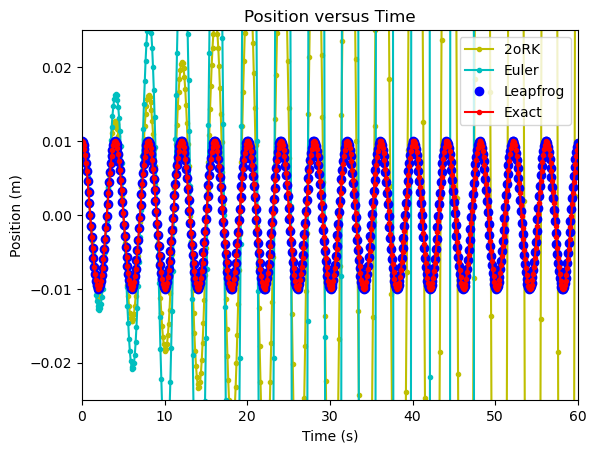

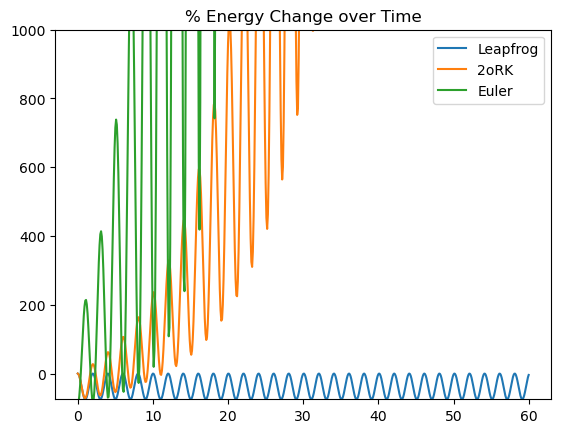

In [2]:
####### 3.1 - Adding leapfrog method to notebooks 15 & 16 plot energies

# put pendulum code here
# set parameters for falling ball
g = 9.8
t0 = 0.01
w0 = 0.
L = 4
dt  = .1
tfinal = 60.

# initialize arrays
t = np.arange(0.,tfinal+dt,dt)
npoints = len(t)
theta = np.zeros(npoints)
omega = np.zeros(npoints)
# set Init values for 20rk
theta[0] = t0
omega[0] = w0


# here's the exact solution for comparison
thetaExact = t0*np.cos(np.sqrt(g/L)*t)

tEuler = np.zeros(npoints)
wEuler = np.zeros(npoints)

# EULER METHOD SOLUTION
tEuler[0] = t0
wEuler[0] = w0
for i in range(npoints-1):
    # advance solution using Euler Method
    tEuler[i+1] = tEuler[i] + wEuler[i]*dt
    wEuler[i+1] = wEuler[i] - g/L*np.sin(tEuler[i])*dt

# 2ND ORDER RK
for i in range(npoints-1):
    # compute midpoint position (not used!) and  velocity
    tmid = theta[i] + omega[i]*dt/2.
    wmid = omega[i] - g/L*np.sin(tmid)*dt/2.

    # use midpoint velocity to advance position
    theta[i+1] = theta[i] + wmid*dt
    omega[i+1] = omega[i] - g/L*np.sin(theta[i])*dt


l_theta = np.zeros(npoints)
l_omega = np.zeros(npoints)
# set Init values for 20rk
l_theta[0] = t0
l_omega[0] = w0

# LEAPFROG METHOD
for i in range(npoints-1):
    tmid = l_theta[i] + l_omega[i]*dt/2.
    l_omega[i+1] = l_omega[i] - g/L*np.sin(tmid)*dt
    l_theta[i+1] = tmid + l_omega[i+1]*dt/2.


plt.figure(1)
plt.plot(t,theta,'y.-',label='2oRK')
plt.plot(t,tEuler,'c.-',label='Euler')
plt.plot(t,l_theta,'bo',label='Leapfrog')
plt.plot(t,thetaExact,'r.-',label='Exact')
plt.legend()
plt.axis([0,60,-.025,.025])
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position versus Time')
plt.show()


# Calc K U and Et
calc_E = lambda w,th: (.5*1*L*w**2)+(1*g*L*(1-np.cos(th)))
rk_e_init = calc_E(omega[0],theta[0])
e_e_init = calc_E(wEuler[0],tEuler[0])
l_e_init = calc_E(l_omega[0],l_theta[0])

diff_e = lambda f,i: ((f-i)/i)*100

"""make different graph for the totel energy as a function of time for each mode, we need to show that 2oRK deviates over time whereas the leapfrog oscillate"""
def energies(thetas, omegas):
    potential_energy = -g * L * np.cos(thetas)
    kinetic_energy = 0.5 * L**2 * omegas**2
    total_energy = potential_energy + kinetic_energy
    return total_energy

l_e_vals = diff_e(calc_E(l_omega,l_theta),l_e_init)
rk_e_vals = diff_e(calc_E(omega,theta),rk_e_init)
e_e_vals = diff_e(calc_E(tEuler,wEuler),e_e_init)

plt.plot(t,l_e_vals,label='Leapfrog')
plt.plot(t,rk_e_vals,label='2oRK')
plt.plot(t,e_e_vals,label='Euler')
plt.legend()
plt.title('% Energy Change over Time')
plt.ylim([np.min(l_e_vals),1000])
plt.show()

### 3.1 Analysis

- see that the motion of the pendulum for the other methods quickly deviates from the actual position
  - but leapfrog remains constant
- energy quickly increases for both methods, but leapfrog remains oscilating between constant values and sees no increase over larger time periods


## 3.2 - Orbits from NFW halo
- creating NFW halo as in project 2 (prob copy fucntion)
- get energy from model too
- new part is finding the force from equation given
- then use the approximation fucntions like 2nd and 4th rk, and leapfrog to approx force at certain time step
- **describe what you find**
- leapfrog orbit should stay put and the other methods (rk) should slowly drift orbits
  - make the 2nd rk time step 2x as big as leapfrog
  - make the 4th rk time step 2x as big as 2nd rk
- run all for 5 dimensionless time units (~? time steps)


(4.365430022584582e-17, 0.7129288257845388, 0)


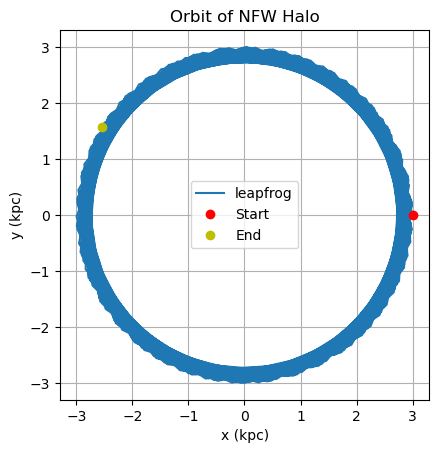

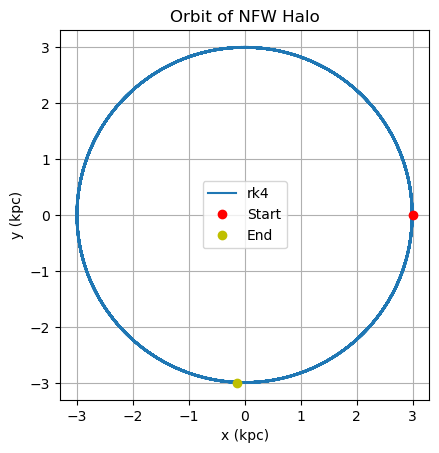

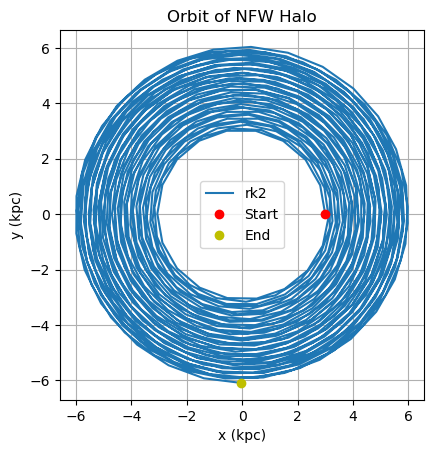

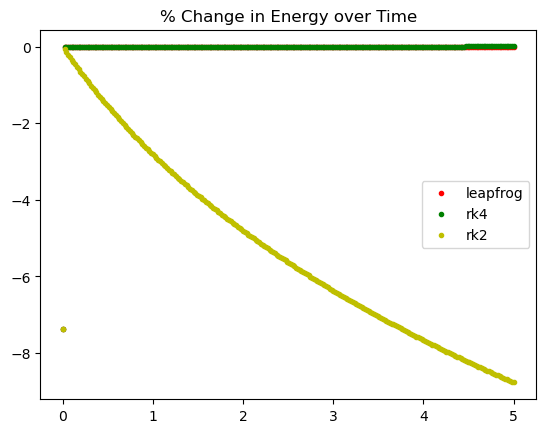

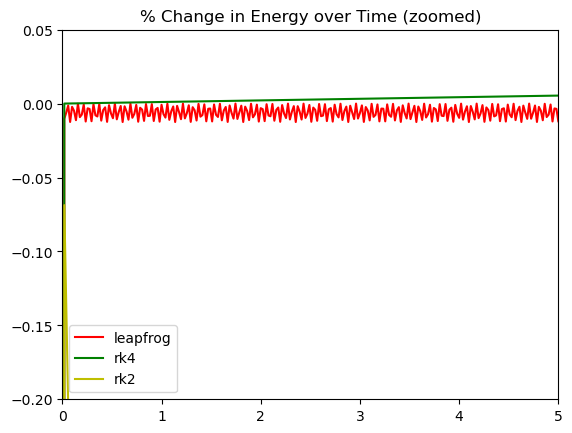

In [3]:
# Constants
const_C = 15
Mass = 1

## Set Initial Conditions ##########
r0 = np.array([0.01, 0.0, 0.0])

# find the initial velocity information
part_info_nfw, pot_r_nfw,const_P0 = create_NFW(Mass,1.,100000,const_C,graph=False,mass_dist=False)
#mass_func = interp1d(nfw_mass_table[:,1],nfw_mass_table[:,0],kind='cubic',assume_sorted=False)
#nfw_vcr = lambda r: np.sqrt(np.abs((const_G*mass_func(r))/np.linalg.norm(r)))
#velr = (nfw_vcr(np.linalg.norm(r0)))
#vel0 = np.pi/2.
#velz = 0.

part_mass = part_info_nfw[0,0]

### Get velocity at radius r
def V(r):
    r_hat = r / np.linalg.norm(r,axis=0)
    r_mag = np.linalg.norm(r,axis=0)
    F = part_mass*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*r_mag)-(const_C*r_mag)/(1+const_C*r_mag))/(r_mag**2))*r_hat
    return np.sqrt(-F*r_mag/part_mass)

velr = V(r0)[0]
vel0 = np.pi/2.
velz = 0

velx,vely,velz = cyl_to_cart(velr,vel0,velz) # assuming 0 for z angle so we can just use cylindrical coordinates


v0 = (velx,vely,velz)
print(v0)
#### End of Initial Conditions ##########


# Function to compute the derivatives
def derivatives(t, r, v):
    r_mag = np.linalg.norm(r,axis=0)
    r_hat = r / np.linalg.norm(r,axis=0)
    dv_dt = r_hat*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*r_mag)-(const_C*r_mag)/(1+const_C*r_mag))/(r_mag**2))
    dr_dt = v
    return dr_dt, dv_dt


### Function to run a simulation & plot results
def run_sim(sim_length,num_steps,method,r0,v0,graph=True):
    dt = sim_length / num_steps  # Time step

    # Arrays to store the results
    time_points = np.linspace(0, sim_length, num_steps + 1)
    positions = np.zeros((num_steps + 1, 3))
    velocities = np.zeros((num_steps + 1, 3))

    # setting init conditions
    positions[0] = r0
    velocities[0] = v0

    # Perform the simulation
    for i in range(num_steps):
        positions[i + 1], velocities[i + 1] = method(0, positions[i], velocities[i], dt)

    if(graph):
        # Plotting the orbit & calculating Energies (in addition to graphing those too)
        ###### Convert these to real units later ##########
        plt.plot(positions[:, 0]*const_R_scale, positions[:, 1]*const_R_scale,label=(f'{method.__name__}'))
        plt.title('Orbit of NFW Halo')
        plt.xlabel('x (kpc)')
        plt.ylabel('y (kpc)')
        plt.gca().set_aspect('equal')
        plt.plot(positions[0,0]*const_R_scale,positions[0,1]*const_R_scale,'ro',label='Start') #start pos
        plt.plot(positions[-1,0]*const_R_scale,positions[-1,1]*const_R_scale,'yo',label='End') # end pos
        plt.legend()
        plt.grid(True)
        plt.show()

    return positions,velocities


# Function for leapfrog
def leapfrog(t,r,v,dt):
    # LEAPFROG METHOD
    rmid = r+(v*dt/2.)
    dr,dv = derivatives(t,rmid,v)
    v_new = v+dv*dt
    #r_new = rmid+dr*dt/2
    r_new = rmid+v_new*dt/2.

    return r_new,v_new


# Function to perform one step of the 4th order Runge-Kutta method
def rk4(t, r, v, dt):
    k1r, k1v = derivatives(t, r, v)
    k2r, k2v = derivatives(t + dt / 2, r + dt / 2 * k1r, v + dt / 2 * k1v)
    k3r, k3v = derivatives(t + dt / 2, r + dt / 2 * k2r, v + dt / 2 * k2v)
    k4r, k4v = derivatives(t + dt, r + dt * k3r, v + dt * k3v)

    r_new = r + dt / 6 * (k1r + 2 * k2r + 2 * k3r + k4r)
    v_new = v + dt / 6 * (k1v + 2 * k2v + 2 * k3v + k4v)

    return r_new, v_new

# Function for 2nd order Runge-kutta
def rk2(t,r,v,dt):
    k0r,k0v = derivatives(t,r,v)
    k1r,k1v = derivatives(t+dt/2, r+dt/2*k0r,v+dt/2*k0v)

    r_new = r+k1r*dt
    v_new = v+k1v*dt
    return r_new,v_new



######### Setting up for the Simulation ##########

sim_length = 5
lf_step = 512
rk4_step = lf_step*4
rk2_step = lf_step*2

## Run a leapfrog sim
leap_pos,leap_vel = run_sim(sim_length,lf_step,leapfrog,r0,v0)

## Run a rk4 simulation
rk4_pos, rk4_vel = run_sim(sim_length,rk4_step,rk4,r0,v0)

## Run a rk2 simulation
rk2_pos, rk2_vel = run_sim(sim_length,rk2_step,rk2,r0,v0)


####### calculating energy % change over time ###########
e_calc = np.zeros((int(lf_step/2),3)) ## [[leapfrog],[l_t2],etc]

calc_energy = lambda p,v: 0.5*np.linalg.norm(v)**2 + pot_r_nfw(np.linalg.norm(p))

e_len = len(e_calc)
e_calc[0,0]=calc_energy(leap_pos[0],leap_vel[0])
e_calc[0,1]=calc_energy(rk4_pos[0],rk4_vel[0])
e_calc[0,2]=calc_energy(rk2_pos[0],rk2_vel[0])
for i in range(1,e_len):
    # find leapfrog values
    leap_scale = int(lf_step/e_len)
    ind = int(leap_scale*i)
    if(i==0): # set initial energy
        e_calc[i,0] = (calc_energy(leap_pos[ind],leap_vel[ind]))
    else:
        e_calc[i,0] = (calc_energy(leap_pos[ind],leap_vel[ind])-e_calc[0,0])/e_calc[0,0]*100

    # find rk4 vals
    rk4_scale = int(rk4_step/e_len)
    ind = int(rk4_scale*i)
    if(i==0): # set initial energy
        e_calc[i,1] = (calc_energy(rk4_pos[ind],rk4_vel[ind]))
    else:
        e_calc[i,1] = (calc_energy(rk4_pos[ind],rk4_vel[ind])-e_calc[0,1])/e_calc[0,1]*100

    # find rk2 vals
    rk2_scale = int(rk2_step/e_len)
    ind = int(rk2_scale*i)
    if(i==0): # set initial energy
        e_calc[i,2] = (calc_energy(rk2_pos[ind],rk2_vel[ind]))
    else:
        e_calc[i,2] = (calc_energy(rk2_pos[ind],rk2_vel[ind])-e_calc[0,2])/e_calc[0,2]*100

e_time = np.linspace(0,sim_length,e_len)
plt.plot(e_time,e_calc[:,0],'r.',label='leapfrog')
plt.plot(e_time,e_calc[:,1],'g.',label='rk4')
plt.plot(e_time,e_calc[:,2],'y.',label='rk2')
plt.legend()
plt.title('% Change in Energy over Time')
plt.show()


#### zoomed in graph
plt.plot(e_time,e_calc[:,0],'r-',label='leapfrog')
plt.plot(e_time,e_calc[:,1],'g-',label='rk4')
plt.plot(e_time,e_calc[:,2],'y-',label='rk2')
plt.axis([0,sim_length,-0.2,0.05])
plt.legend()
plt.title('% Change in Energy over Time (zoomed)')
plt.show()

### 3.2 Analysis
- we see that the rk2 method quickly increases in radius and quickly gains energy out of no where, which is particularly a bad sign for a simulation replicating the energy conservation
- but the leapfrog and rk4 methods seem very consistent in their orbits
- they also **appear** to be consistent in energy conservation, but as we zoom in, we see the rk4 method gains energy over time, while the leapfrog only oscillates in energy over time (without a net increase)
- also in the orbiting section, it appears the leapfrog is not good, but it's much more consistent than the rk4 method at later times
- we see that on a simulation length that is the size of our full simulation, the leapfrog remains especially constant

## 3.3 - Evolve NFW halo
evolve the NFW halo from proj 2 using leapfrog method
time step should be small enough for fast objects near center to do proper calculations
use np.where to do the leapfrog calculation on all particles that need to change at once (or something like that)
maybe do numpy array operations using leapfrog method like arr*dt etc
output the kinetic energy every 10 or 100 time steps
find 2T/W at the end, is it still ~in equilibrium
compare the density vs radius at beginning & end
more questions on doc to answer
is it in equilibrium? No bc? maybe it doesn't stay in equilibrium bc C=15, it needs to be bigger to remain in equilibrium?
- first part redoing part 2 but with smaller radius
- second part
- don't want one numpy array with all xyz coordinates in one
- want to have one np array for each coordinate separately
	- want one array of all xs, one for ys, one for zs, one for vxs, etc

-----------------
NFW Halo Initial Conditions....
-----------------


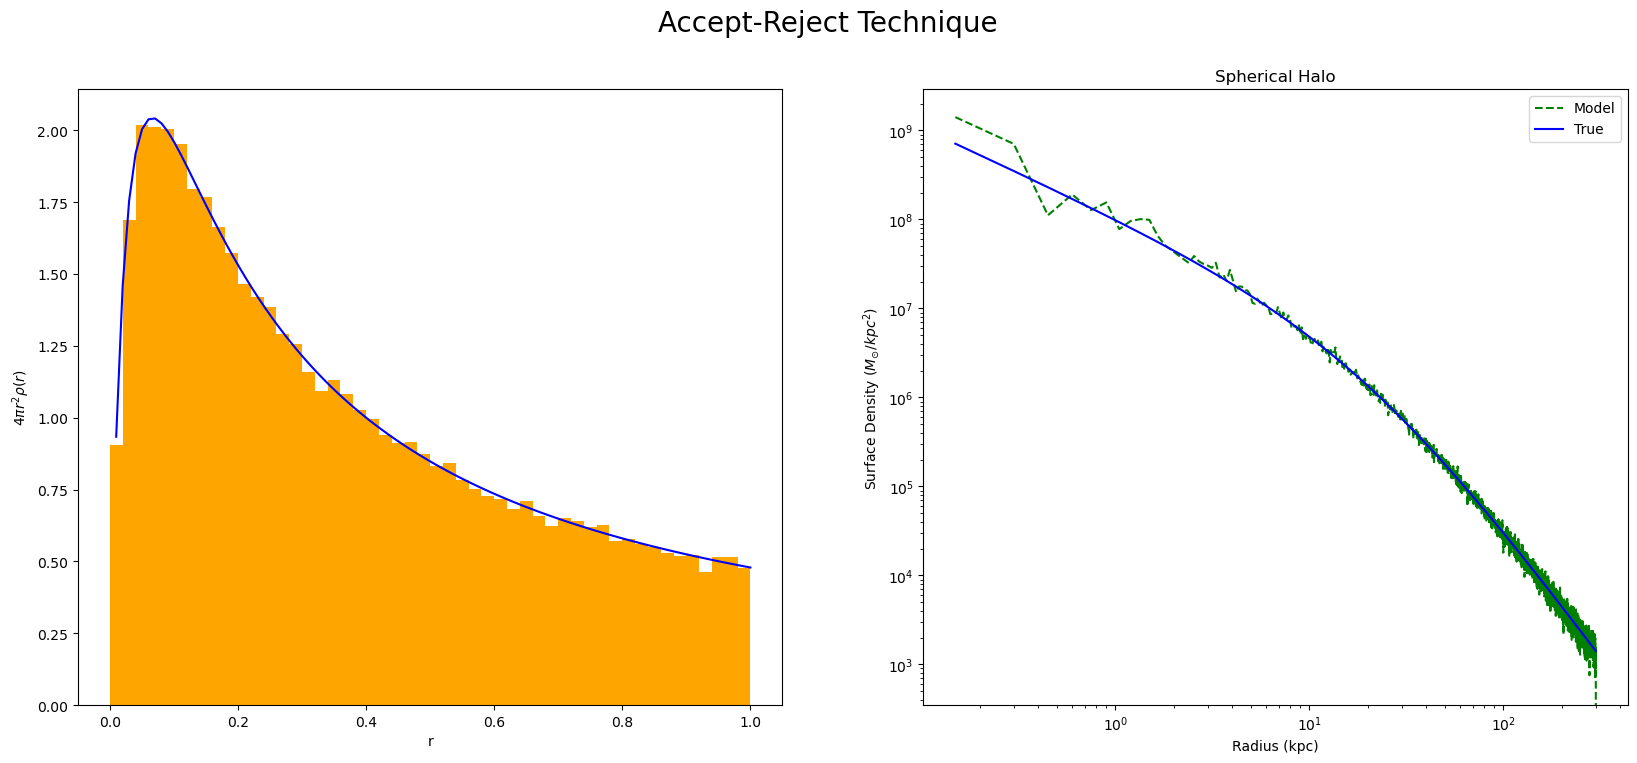

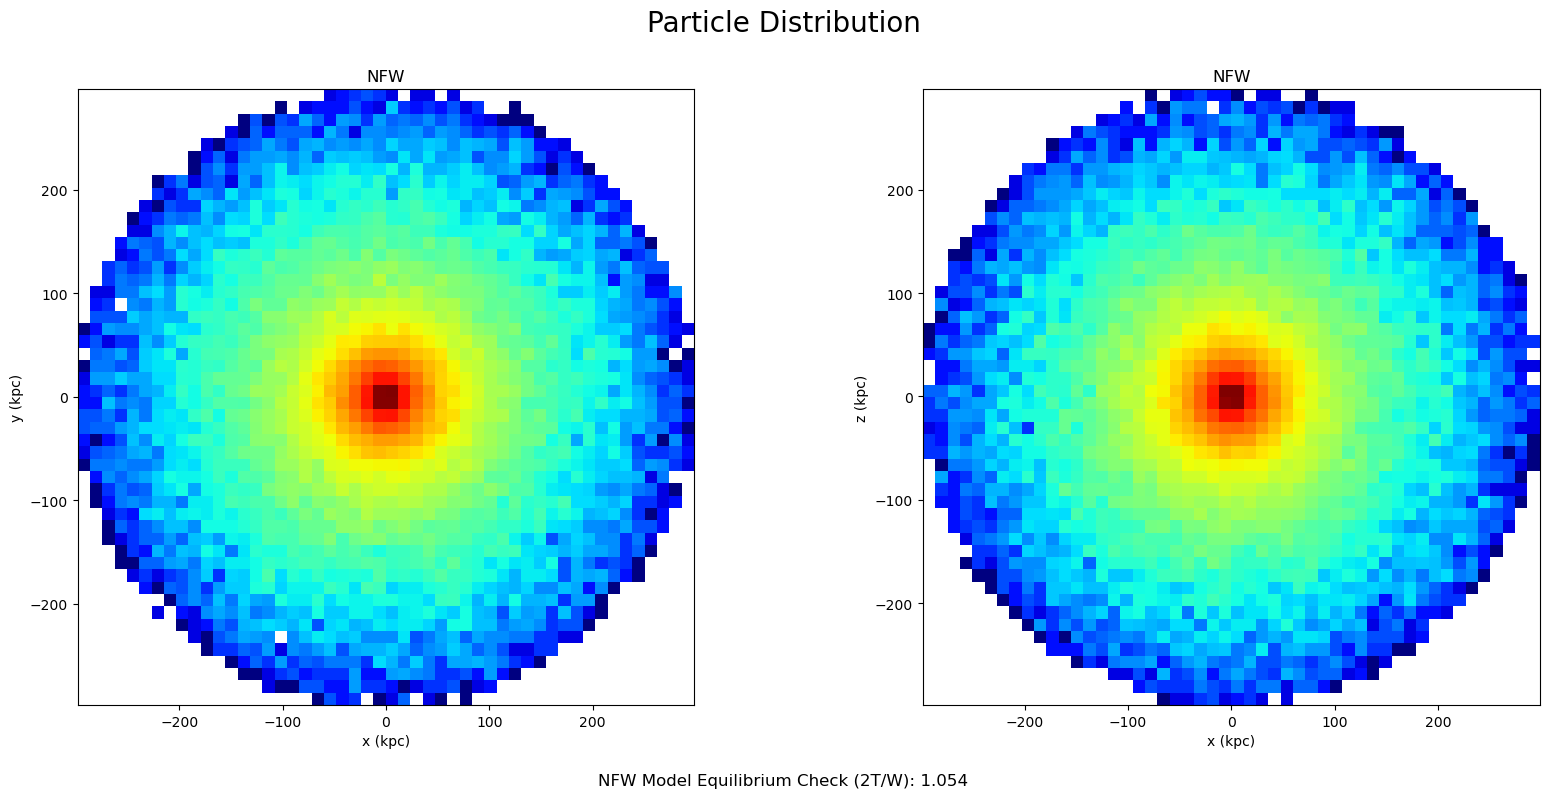

-----------------
Plotting Orbit of .3kpc particle with Leapfrog...
-----------------


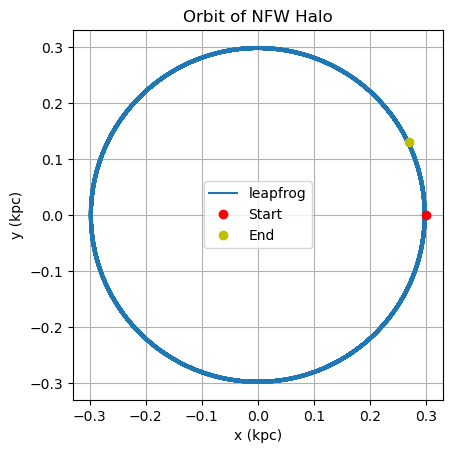

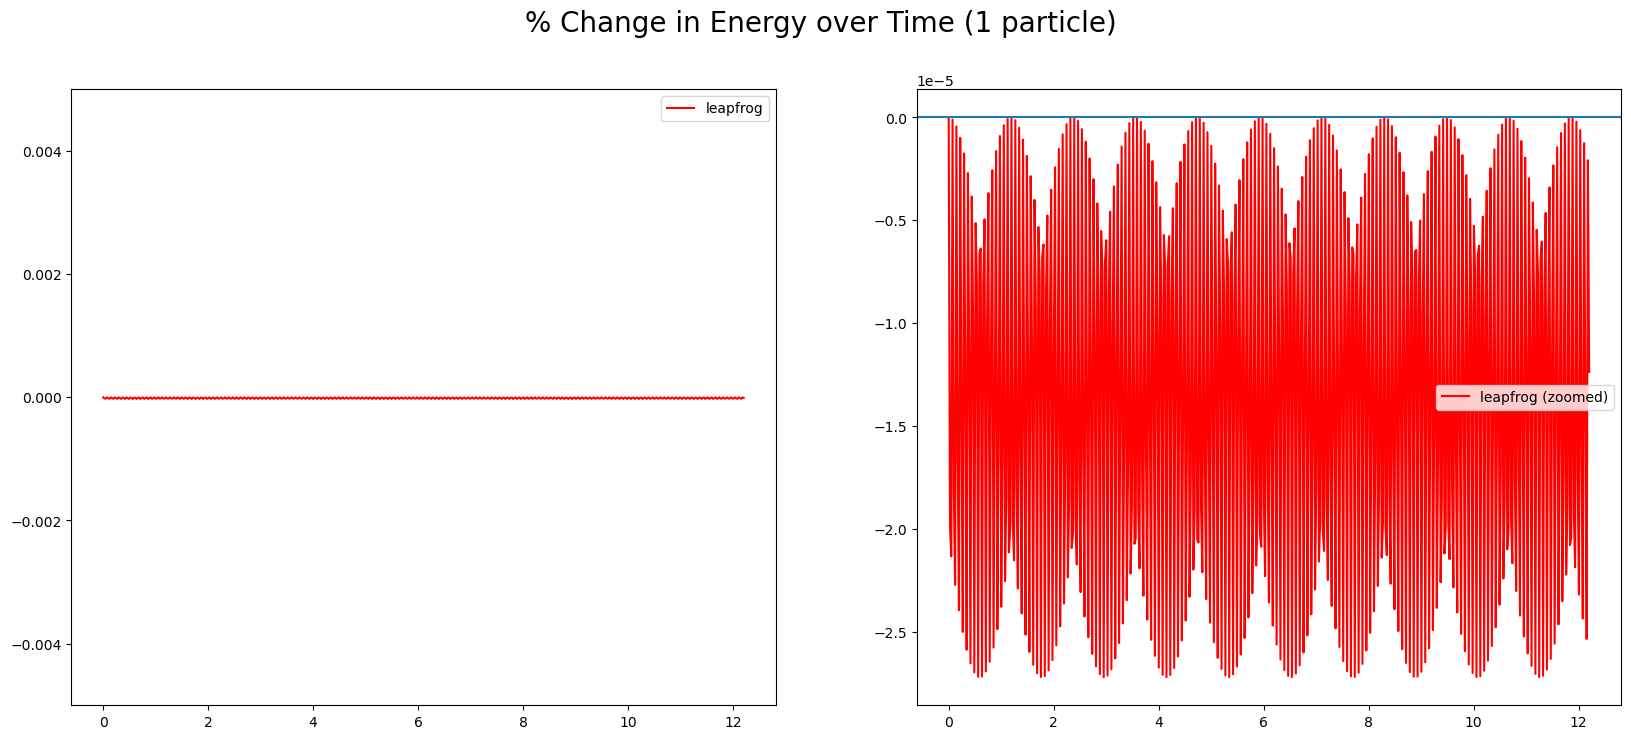

-----------------
Second Part
-----------------
Equilibrium Value with initial Conditions (2T/W):1.0535438776600394
Equilibrium Value at Final Conditions (2T/W):0.6337791313654113


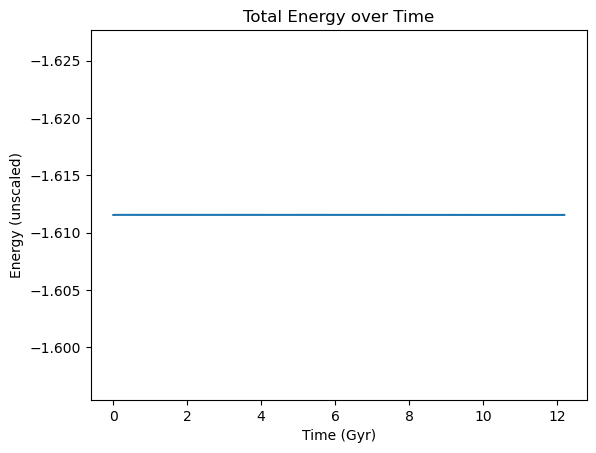

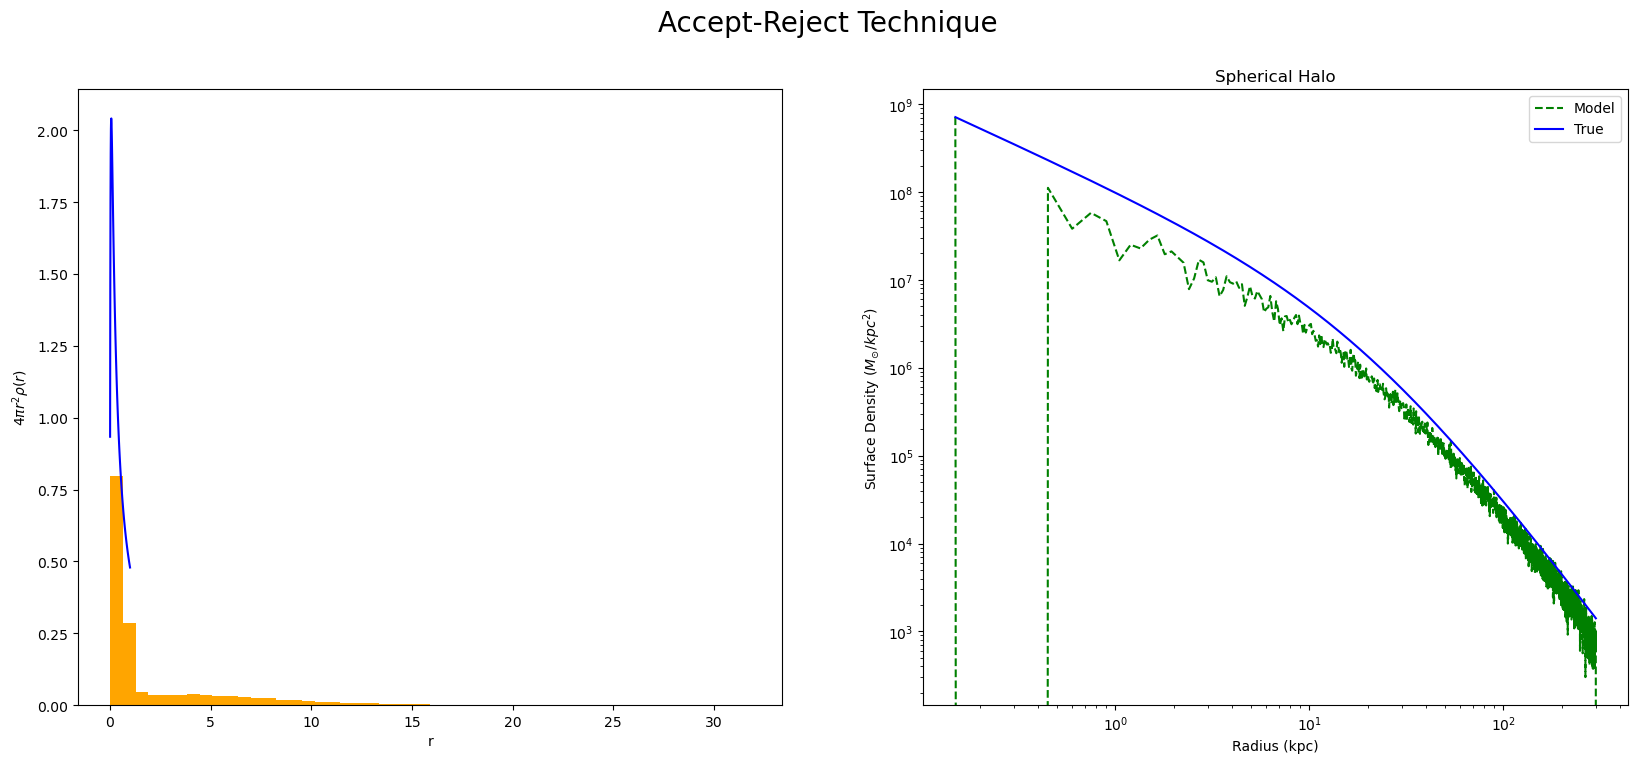

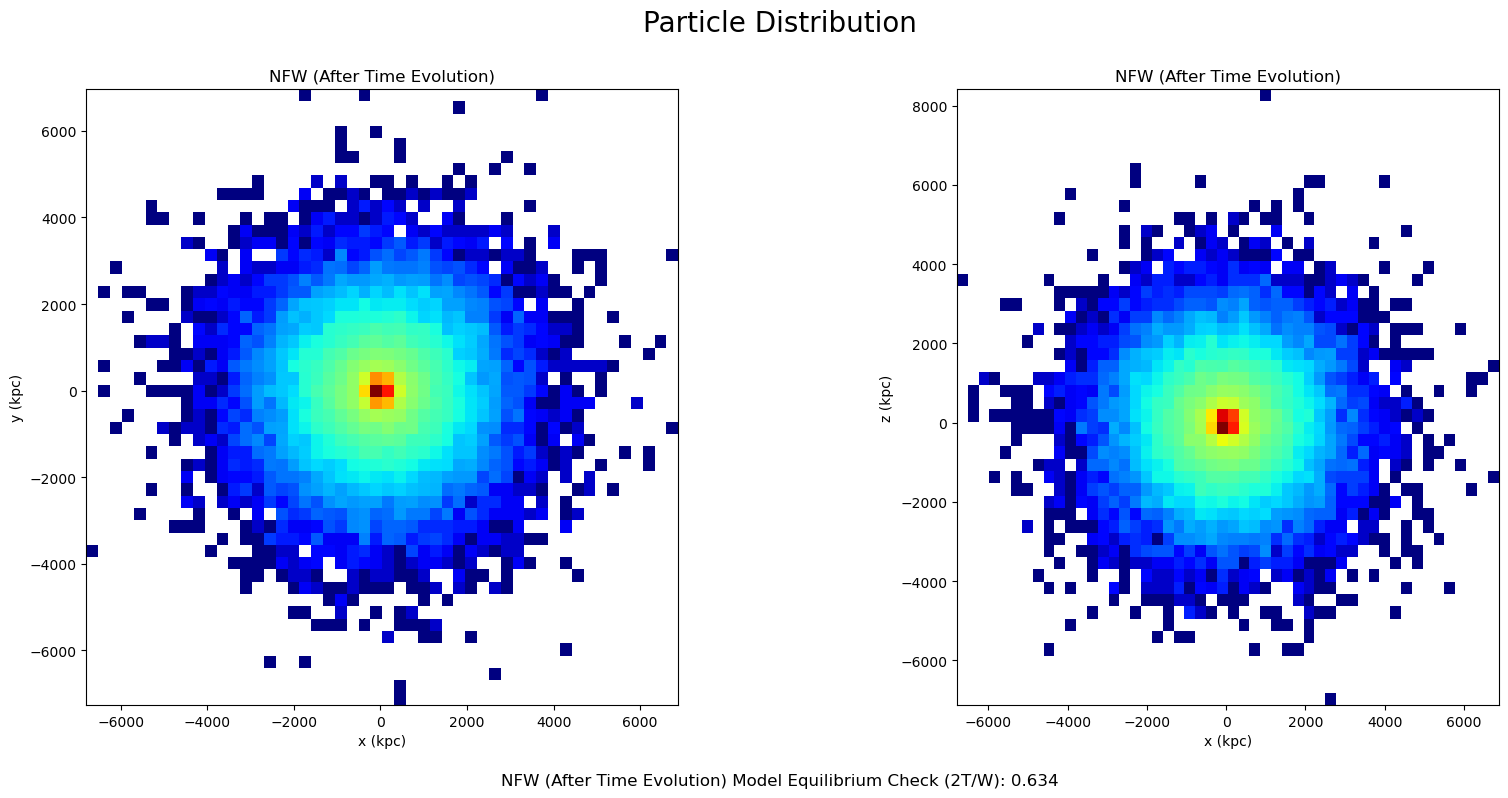

In [4]:
######### 3.3 - Evolve an NFW Halo

##### Setting initial parameters ########
NUMPART = 100000
const_C = 15
Mass = 1
print('-----------------\nNFW Halo Initial Conditions....\n-----------------')
part_info,pot_r, const_P0 = create_NFW(Mass,1.,NUMPART,const_C,graph=True,mass_dist=False)

part_mass = part_info[0,0]
r0 = np.array([0.001,0,0])
velr = V(r0)[0]
vel0 = np.pi/2.
velz = 0
velx,vely,velz = cyl_to_cart(velr,vel0,velz) # assuming 0 for z angle so we can just use cylindrical coordinates

v0 = (velx,vely,velz)

sim_length = 5
lf_step = 5000                  ### Only value that gives reasonable result without being too big error

##### End of Setting initial parameters ########



############ First Part ##############

print('-----------------\nPlotting Orbit of .3kpc particle with Leapfrog...\n-----------------')
#### Running Simulation ####
leap_pos,leap_vel = run_sim(sim_length,lf_step,leapfrog,r0,v0)

### Calculate energy for this given array of the single particle position and velocity
calc_energy = lambda p,v: 0.5*np.linalg.norm(v)**2 + pot_r(np.linalg.norm(p))
e_step = 10
pos_calc = leap_pos[::e_step]
vel_calc = leap_vel[::e_step]
e_init = calc_energy(pos_calc[0],vel_calc[0])
e_calc = np.zeros(len(pos_calc)) ## [[leapfrog],[l_t2],etc]
for i in range(len(e_calc)):
    e_calc[i] = (calc_energy(pos_calc[i],vel_calc[i])-e_init)/e_init*100

e_time = np.linspace(0,sim_length,len(e_calc))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
fig.suptitle('% Change in Energy over Time (1 particle)', fontsize=20)
ax1.plot(e_time*const_T_scale,e_calc,'r-',label='leapfrog')
avg = np.average(e_calc)
ax1.set_ylim(-.005,0.005)
ax1.legend()
ax2.plot(e_time*const_T_scale,e_calc,'r-',label='leapfrog (zoomed)')
#ax2.set_ylim(-.0025,.0025)
ax2.axhline(y=0)
ax2.legend()
plt.show()


####### Second Part #########

# already created the NFW above so now just run the sim with finding e at every 10 or 100 steps
# need to rewrite the run_sim function to be only one axis at a time
px = part_info[:,1]
py = part_info[:,2]
pz = part_info[:,3]
r_0 = np.array([px,py,pz])
#r_0 = r_0_t.T
vx = part_info[:,4]
vy = part_info[:,5]
vz = part_info[:,6]
v_0 = np.array([vx,vy,vz])
#v_0 = v_0_t.T

calc_energy = lambda p,v: np.sum(part_mass*0.5*np.linalg.norm(v,axis=0)**2) + np.sum(part_mass*pot_r(np.linalg.norm(p,axis=0)))
calc_eq = lambda p,v: np.sum(part_mass*np.linalg.norm(v,axis=0)**2)/np.absolute(np.sum(part_mass*pot_r(np.linalg.norm(p,axis=0))))
# evolve each particle separately along the leapfrog method for each item in the time array
#T = NUMPART*np.sum(.5*part_mass*(np.linalg.norm(v_0,axis=0)**2))
#W = NUMPART*np.absolute(np.sum(part_mass*pot_r(np.linalg.norm(r_0,axis=0))))

dt = sim_length/lf_step

#### For calculating energy
e_step = 10
e_init = calc_energy(r_0,v_0)


######### From Initial Conditions #########

print('-----------------\nSecond Part\n-----------------')
print(f'Equilibrium Value with initial Conditions (2T/W):{calc_eq(r_0,v_0)}')

e_calc = np.zeros(int(lf_step/e_step)) ## [[leapfrog],[l_t2],etc]
# set initial conditions for leapfrog
prev_r = r_0
prev_v = v_0
ind=0

for t in range(lf_step):
    if(t%e_step==0): # every 'e_step' # of steps, calc energy
        e_calc[ind] = calc_energy(prev_r,prev_v)
        ind+=1
    r_new,v_new = leapfrog(t,prev_r,prev_v,dt)
    prev_r = r_new
    prev_v = v_new


print(f'Equilibrium Value at Final Conditions (2T/W):{calc_eq(prev_r,prev_v)}')

### plot the total energy over time
t = np.linspace(0,sim_length,len(e_calc))
plt.plot(t*const_T_scale,e_calc)
plt.ylim(np.min(e_calc)-np.average(e_calc)/100,np.max(e_calc)+np.average(e_calc)/100)
plt.xlabel('Time (Gyr)')
plt.ylabel('Energy (unscaled)')
plt.title('Total Energy over Time')
plt.show()
### plot the ending particle distributions from the accept reject technique from below (after debugging)

p_r = lambda r: const_P0/((const_C*r)*((1+const_C*r)**2))
#check_densities_sphere(np.linalg.norm(r_0,axis=0), 1.,Mass,p_r,NUMPART)
#print(np.linalg.norm(r_0,axis=0))
#print(np.linalg.norm(prev_r,axis=0))
scale = calc_eq(prev_r,prev_v)/calc_eq(r_0,v_0)
check_densities_sphere(np.linalg.norm(prev_r,axis=0),1.,Mass,p_r,NUMPART)

### get it into the right format similar to part_info array by swapping columns and rows
#zer = np.full((lf_step,len(new_r[:,0])),part_mass)
zer = np.full(len(prev_r[0,:]),part_mass)
part_info_tmp = np.array([zer,prev_r[0,:],prev_r[1,:],prev_r[2,:],prev_v[0,:],prev_v[1,:],prev_v[2,:]])
part_info_new = part_info_tmp.T
#part_info_new = np.array([zer,new_r[:,:,0],new_r[:,:,1],new_r[:,:,2],new_v[:,:,0],new_v[:,:,1],new_v[:,:,2]])
### Graph the particle distribution
graph_particle_dist(part_info_new,'NFW (After Time Evolution)', (calc_eq(prev_r,prev_v)))

### 3.3 Analysis
1. describe why chosen time step was a good choice
2. How well did your choice of time step work out?
  1. Does it look in equilibrium?
  2. Compare the density vs.radius at both the beginning and the end and compare it to the true profile. Has it evolved? Has your model
remained in equilibrium? Explain what you think is happening.


- we chose a time step of 5000 steps for the simulation, which for a simulation length of 5 is a time step of 0.001
- we tested several time steps ranging from 2500-7500 and found that 5000 was the best quality that still ensured quick simulation processing time.
- We see that at the end of the model the NFW halo is no longer in equilibrium despite starting out in equilibrium.
- It appears (looking at the particle distribution graphs) that the halo expanded a lot in the process and the potential energy increased by about 2x likely as a result of the change in radius.
- By the density and radius graph, we can see that the evolved model has an early cut off radius, for which, there is no particles near there.
- Also the energy remains constant throughout this process, indicating that even though the starting conditions of the model were in equilibrium, the model must not have **stayed** in equilibrium because it increased its size so severely afterwards
- I think that the halo started in equilibrium, but after not having any additional gravitational mass to keep the particles in the halo in orbit about the central density mass, it began to expand, resulting in the 20x radius increase we see at the end of the simulation.

## 3.4 - Evolution of Disk with NFW Potential Only

-------------
 Creation of Disk Model....
-----------


Kinetic Energy before Velocity Dispersion (unscaled units): 4478.131
Kinetic Energy after Velocity Dispersion and Reduction (unscaled units): 4478.131


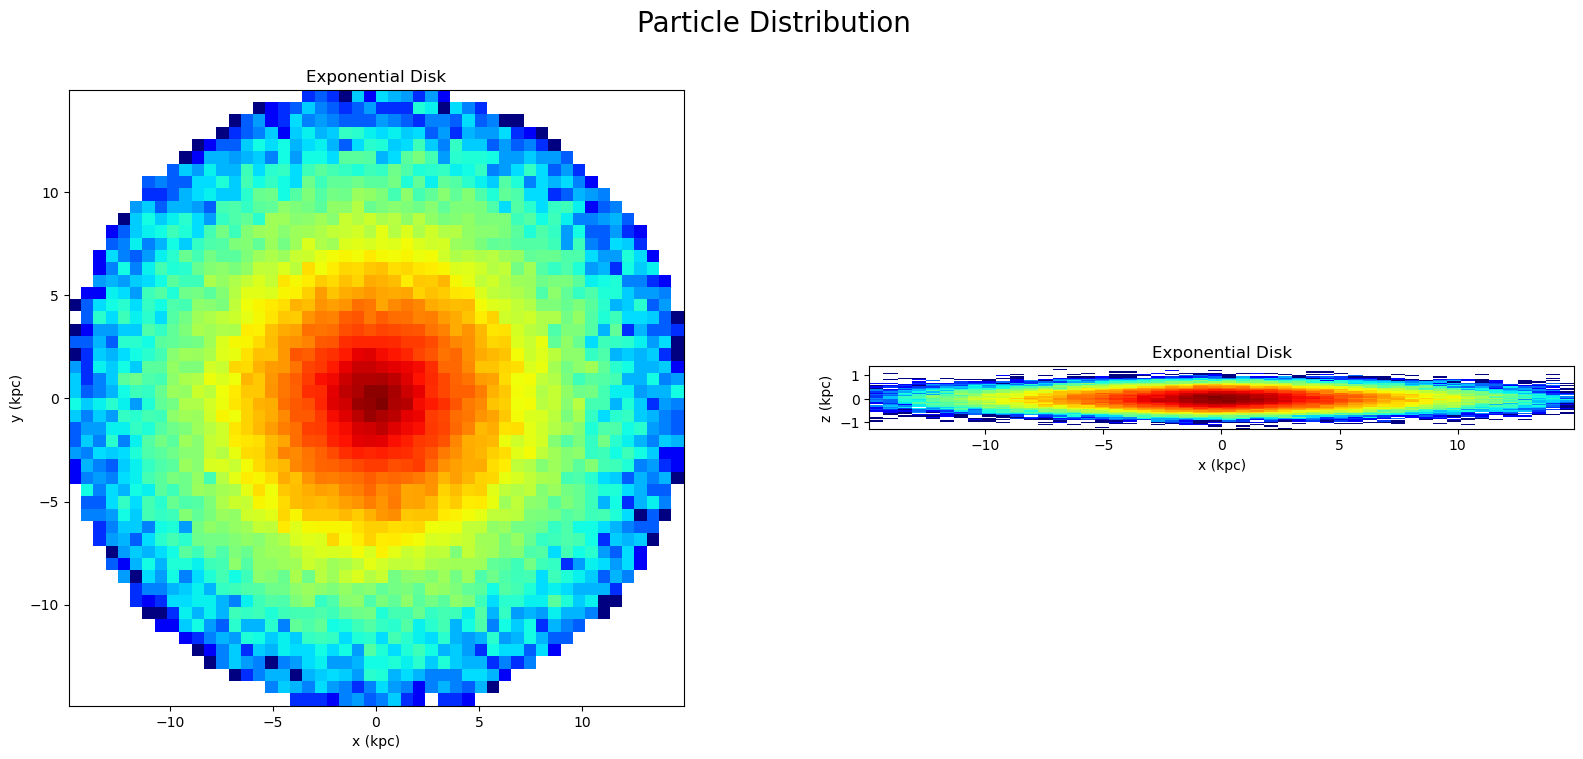

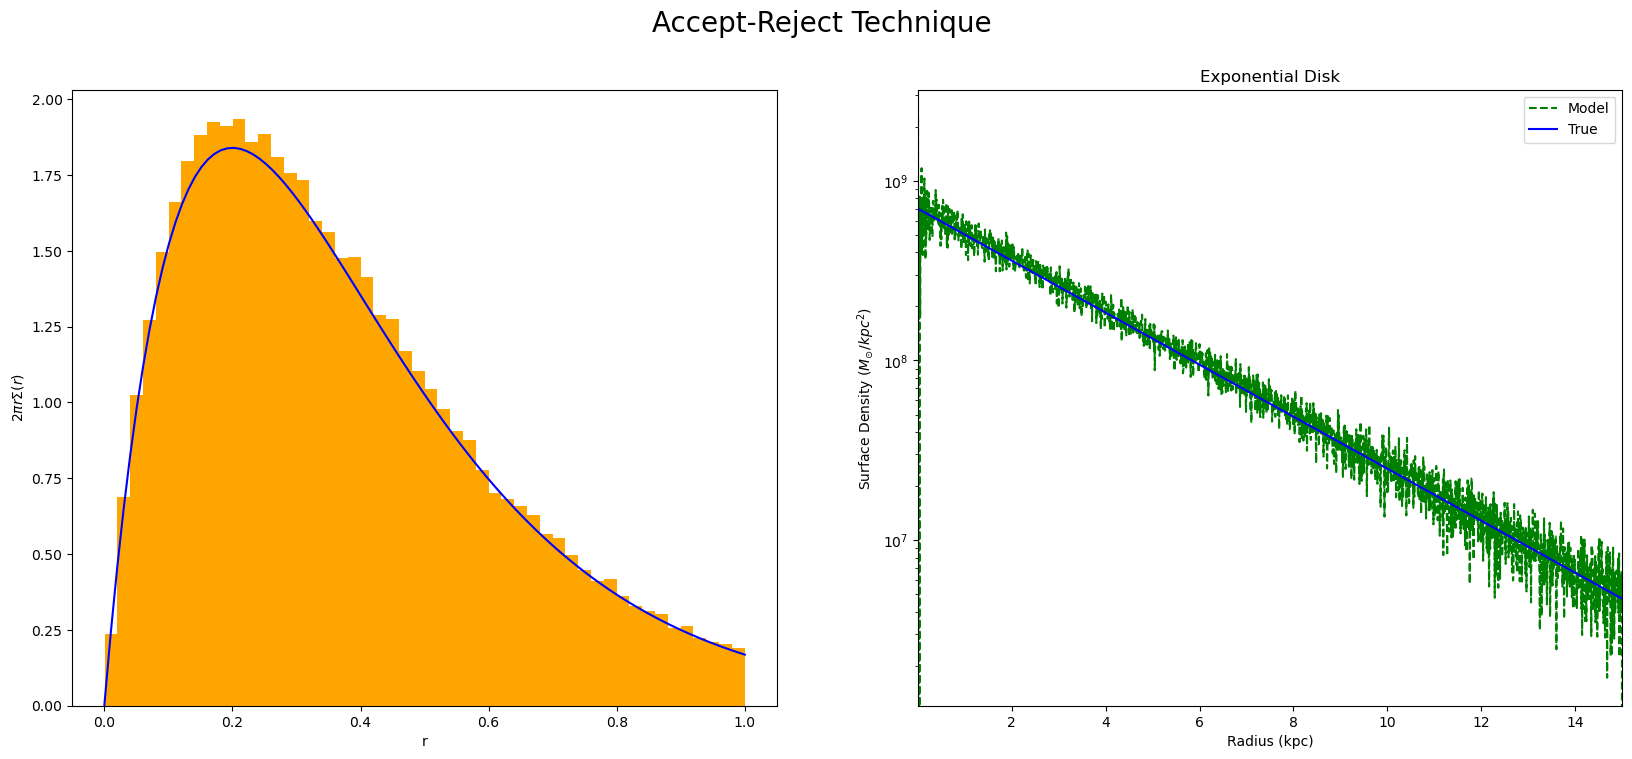

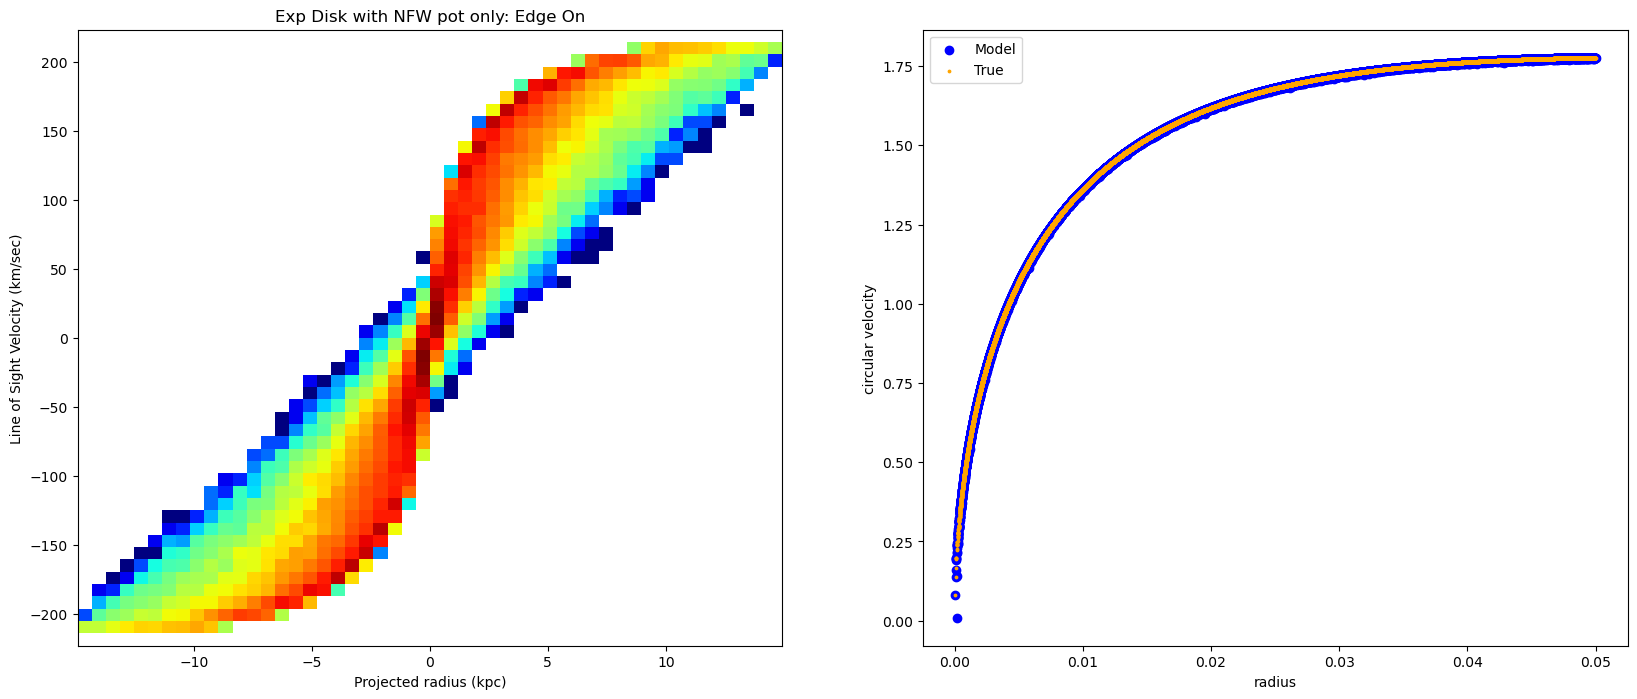

-------------
 Evolving the Disk Model....
-----------

Equilibrium Value with initial Conditions (2T/W):0.3081209793362603
Equilibrium Value at Final Conditions (2T/W):0.3089734279687654


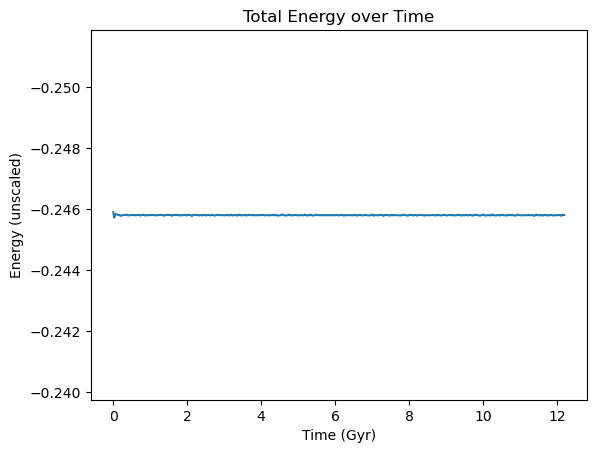

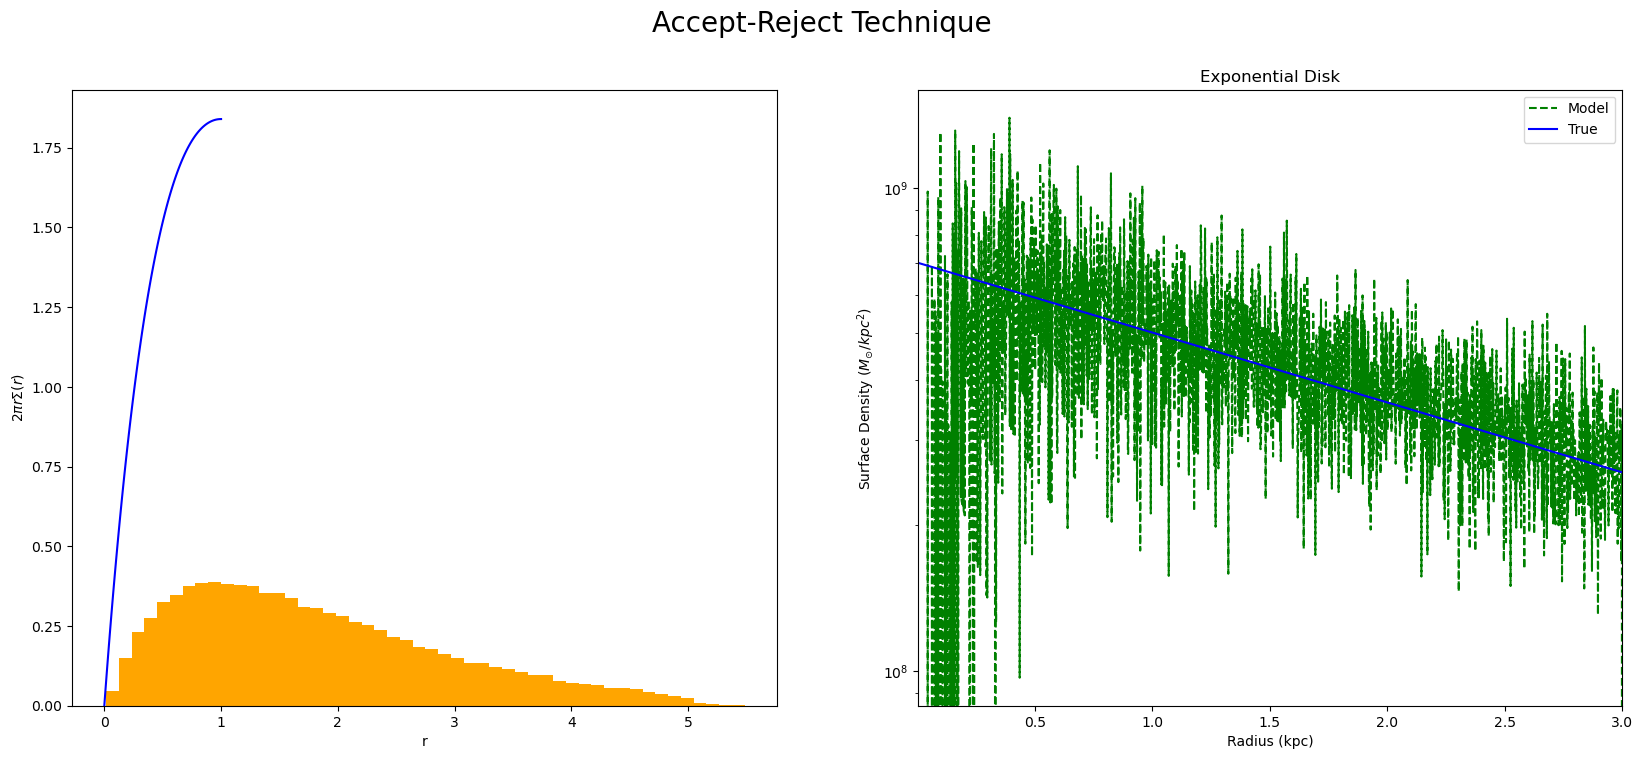

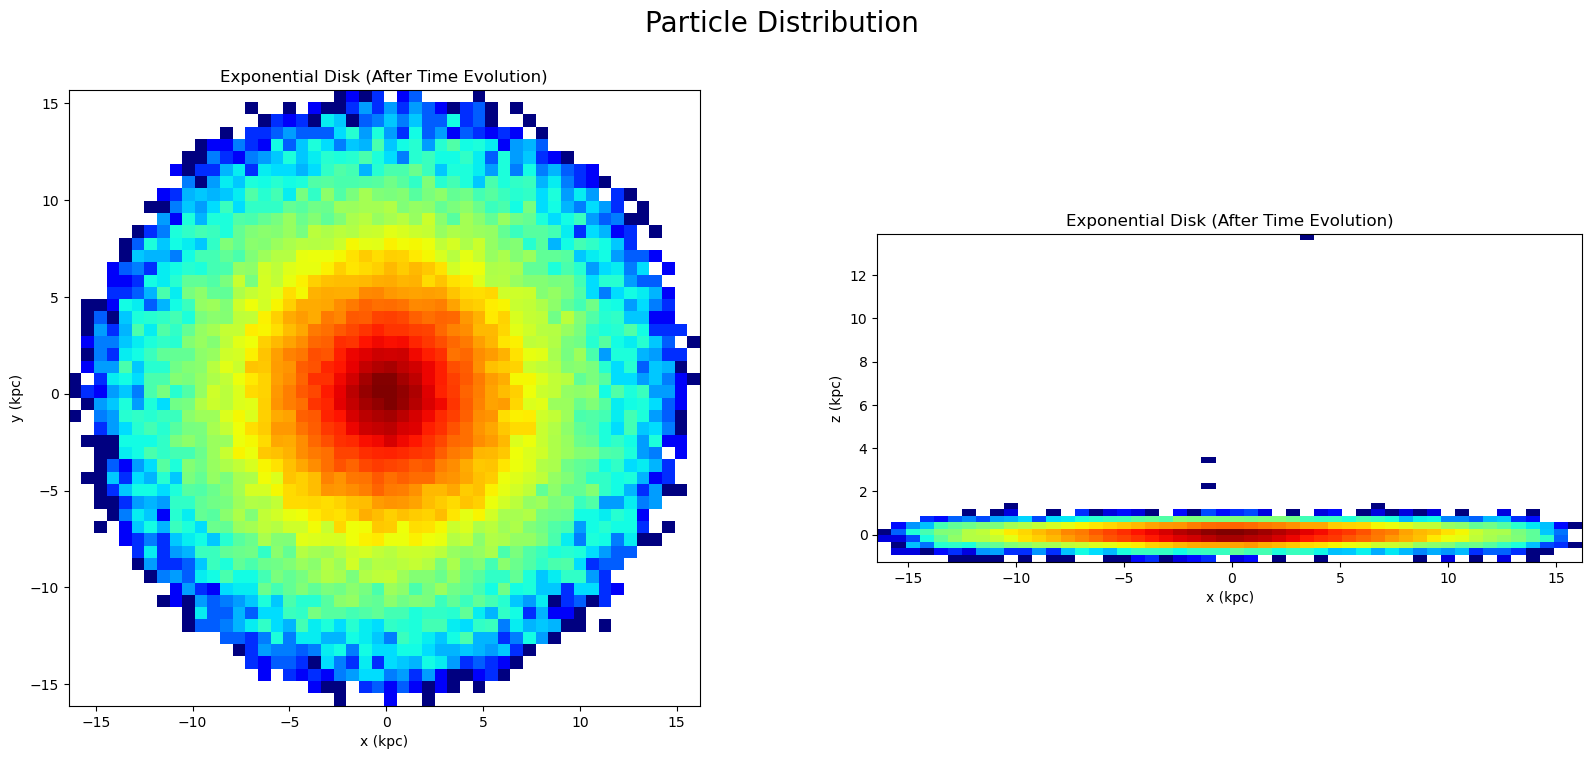

In [5]:
### 3.4 ########


##### Setting initial parameters ########
NUMPART = 100000
RADIUS = 0.01
MASS = 0.04
NFW_C = const_C = 40

print('-------------\n Creation of Disk Model....\n-----------')
part_info, pot_r_nfw, const_P0 = create_disk_vc_nfw(MASS,RADIUS,NUMPART,NFW_C)

part_mass = part_info[0,0]
sim_length = 5
lf_step = 5000                  ### Only value that gives reasonable result without being too big error

##### End of Setting initial parameters ########


#### Now integrate the model over the time period sim_length

# already created the NFW above so now just run the sim with finding e at every 10 or 100 steps
# need to rewrite the run_sim function to be only one axis at a time
px = part_info[:,1]
py = part_info[:,2]
pz = part_info[:,3]
r_0 = np.array([px,py,pz])
vx = part_info[:,4]
vy = part_info[:,5]
vz = part_info[:,6]
v_0 = np.array([vx,vy,vz])

calc_energy = lambda p,v: np.sum(part_mass*0.5*np.linalg.norm(v,axis=0)**2) + np.sum(part_mass*pot_r(np.linalg.norm(p,axis=0)))
calc_eq = lambda p,v: np.sum(part_mass*np.linalg.norm(v,axis=0)**2)/np.absolute(np.sum(part_mass*pot_r(np.linalg.norm(p,axis=0))))
# evolve each particle separately along the leapfrog method for each item in the time array
dt = sim_length/lf_step

#### For calculating energy
e_step = 10
e_init = calc_energy(r_0,v_0)

######### From Initial Conditions #########

########## Do the simulation ##################

print('-------------\n Evolving the Disk Model....\n-----------\n')
print(f'Equilibrium Value with initial Conditions (2T/W):{calc_eq(r_0,v_0)}')

e_calc = np.zeros(int(lf_step/e_step)) ## [[leapfrog],[l_t2],etc]
# set initial conditions for leapfrog
prev_r = r_0
prev_v = v_0
ind=0
for t in range(lf_step):
    if(t%e_step==0): # every 'e_step' # of steps, calc energy
        e_calc[ind] = calc_energy(prev_r,prev_v)
        ind+=1
    r_new,v_new = leapfrog(t,prev_r,prev_v,dt)
    prev_r = r_new
    prev_v = v_new
###############################################

print(f'Equilibrium Value at Final Conditions (2T/W):{calc_eq(prev_r,prev_v)}')




########### Plot the total energy over time ##################
t = np.linspace(0,sim_length,len(e_calc))
plt.plot(t*const_T_scale,e_calc)
plt.ylim(np.min(e_calc)-np.average(e_calc)/40,np.max(e_calc)+np.average(e_calc)/40)
plt.xlabel('Time (Gyr)')
plt.ylabel('Energy (unscaled)')
plt.title('Total Energy over Time')
plt.show()
### plot the ending particle distributions from the accept reject technique from below (after debugging)

const_sig0 = MASS/(2*np.pi*RADIUS**2)
sig_r = lambda r: const_sig0*np.exp((-1*r)/RADIUS)
scale = calc_eq(prev_r,prev_v)/calc_eq(r_0,v_0) # might not need this??
check_densities_disk(np.linalg.norm(prev_r,axis=0),RADIUS,MASS,sig_r,NUMPART)


### get it into the right format similar to part_info array by swapping columns and rows
zer = np.full(len(prev_r[0,:]),part_mass)
part_info_tmp = np.array([zer,prev_r[0,:],prev_r[1,:],prev_r[2,:],prev_v[0,:],prev_v[1,:],prev_v[2,:]])
part_info_new = part_info_tmp.T

graph_particle_dist(part_info_new,'Exponential Disk (After Time Evolution)',0)



### 3.4 Analysis
Again, how well did your choice of time step work
out? Plot the model at the beginning and end? Does it look in equilibrium? Another check of equilibrium is
to check for evolution in the density profile. Compare the density vs. radius at both the beginning and the
end and compare it to the true profile. Has it evolved? Has your model remained in equilibrium? Explain
what you think is happening.

- The time step still appears to hold up well as the disk evolved and remained in equilibrium
- We see that the disk still seemed to expand slightly, going from around 10kpc radius to 15kpc.
- Looking at the density vs radius graph, we see that it evolved to include a drop off at about 0.5kpc vs the starting conditions which remained constant at r=0.5kpc.
- The model has slightly evolved, but in a way that we would expect it to as we can see that the total energy remained **very** consistent throughout the process and the disk expanded only slightly, while the final 2T/|W| value remains essentially the same as the starting conditions (initial Conditions (2T/W):0.3084 -> Final Conditions (2T/W):0.3092).
- I think that the model remained in equilibrium because we set the gravitational parameters properly in this instance. Here we're saying that the disk is feeling **only** the gravitational forces of the

## 3.5 - Evolution of Disk with Galaxy Encounter

- nfw halo moves past disk and existing nfw halo
- saying it just moves straight past us without orbiting
- comes as close as 30kpc
- start at x=900kpc,y=30,z=0, vx=240,vy=0,vz=0 (convert to reduced units)
- take force from this halo evaluated at the dist it is from center of our halo
  - but the force equation is slightly different for the new nfw halo, bc different mass?
  - or maybe the forces add linearly?
- making movie of it by only plotting the views every couple time steps (every 10 or 100) with the time in title

-------------
 Creation of Disk Model....
-----------


Kinetic Energy before Velocity Dispersion (unscaled units): 4477.778
Kinetic Energy after Velocity Dispersion and Reduction (unscaled units): 4477.778


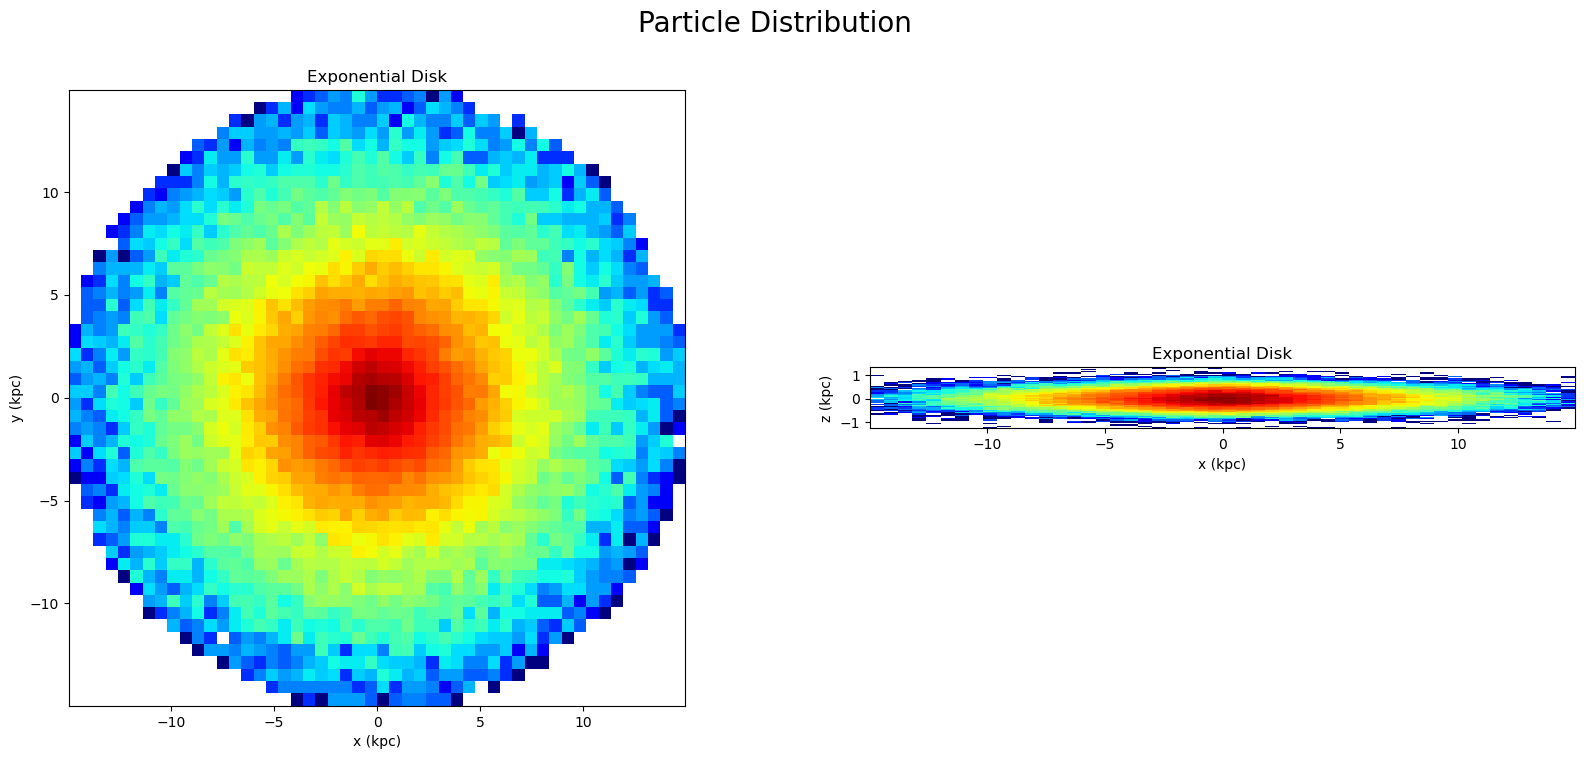

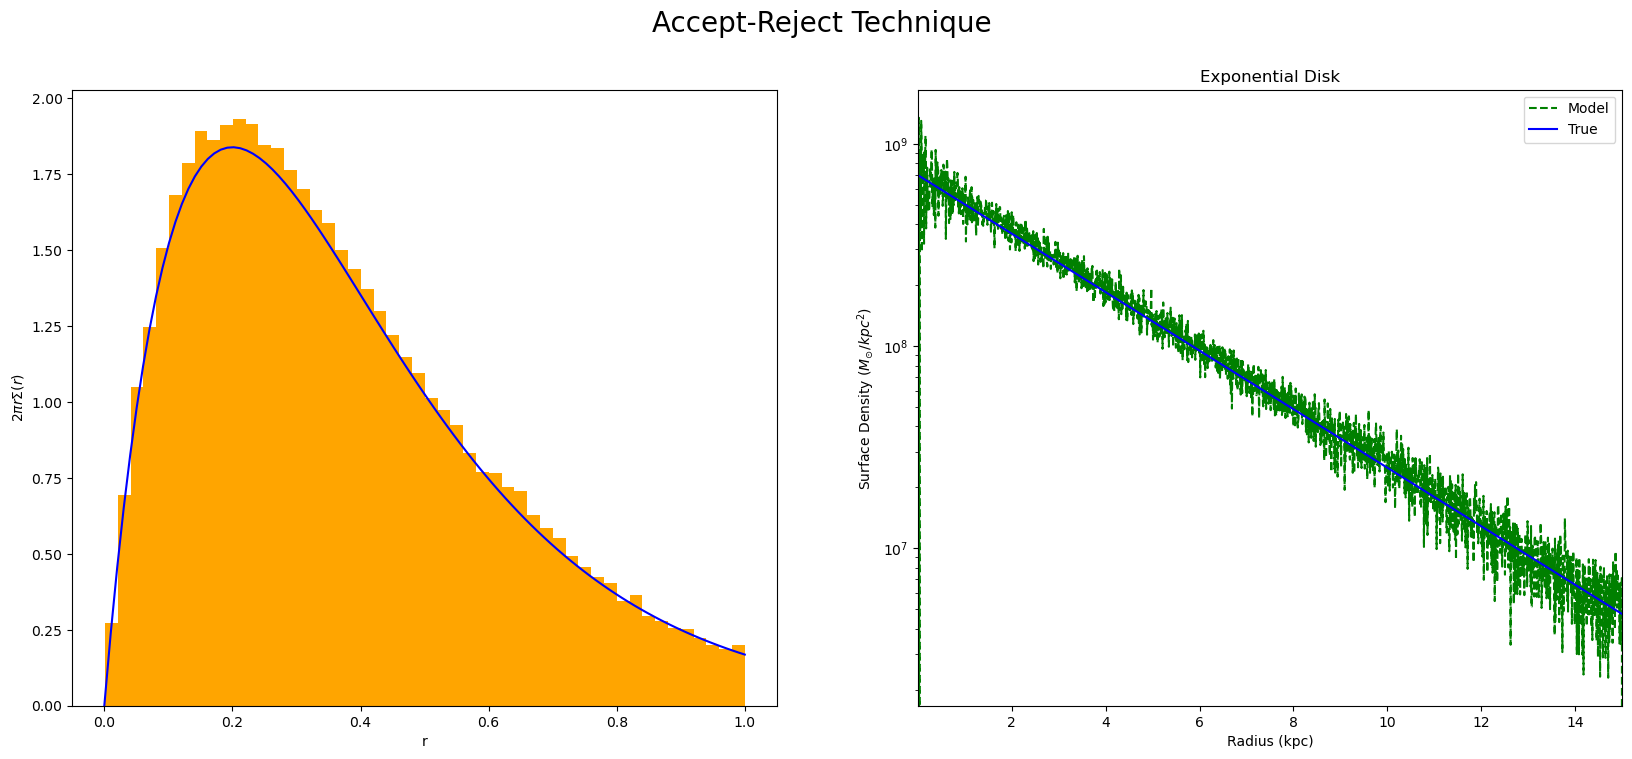

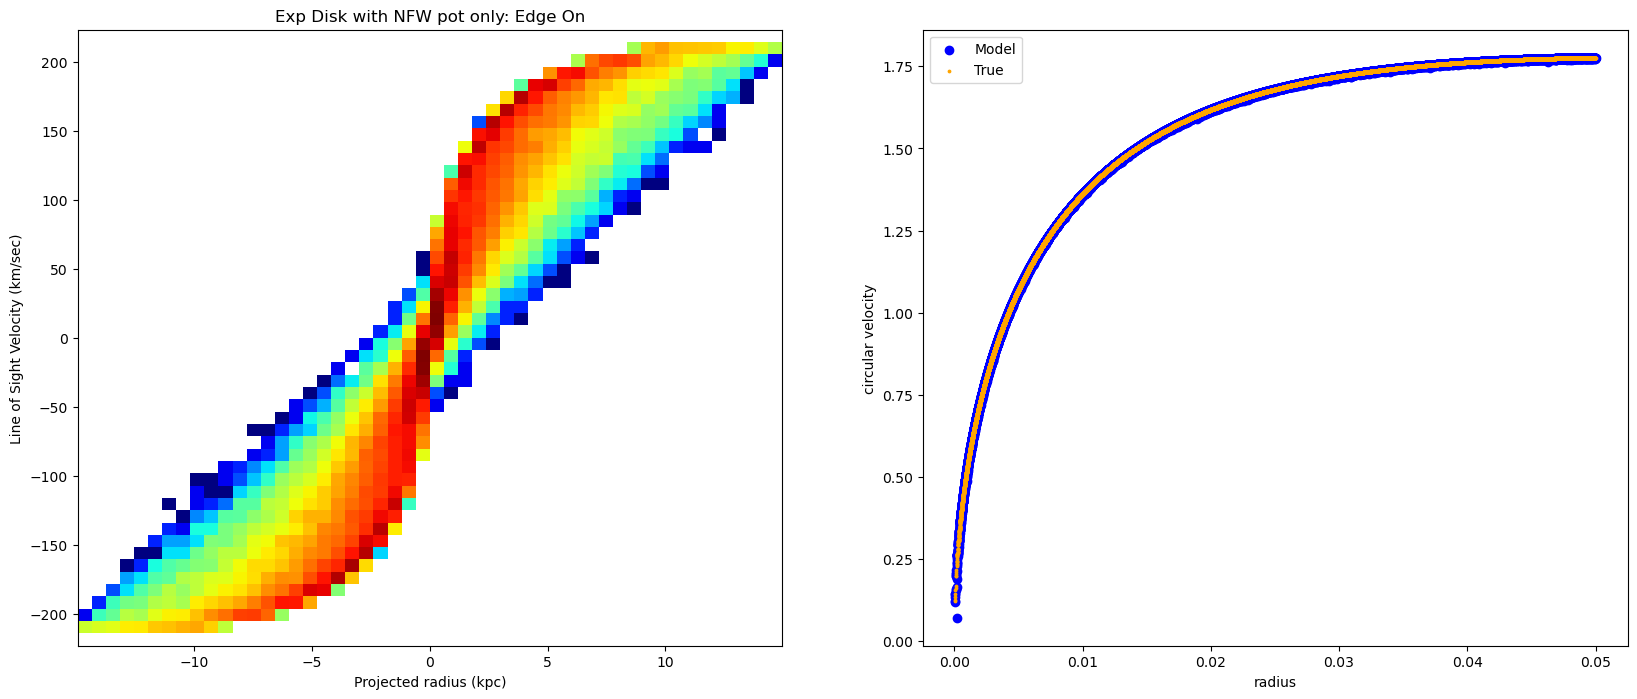

-------------
 Evolving the Disk Model....
-----------

Equilibrium Value with initial Conditions (2T/W):0.1992754502938644


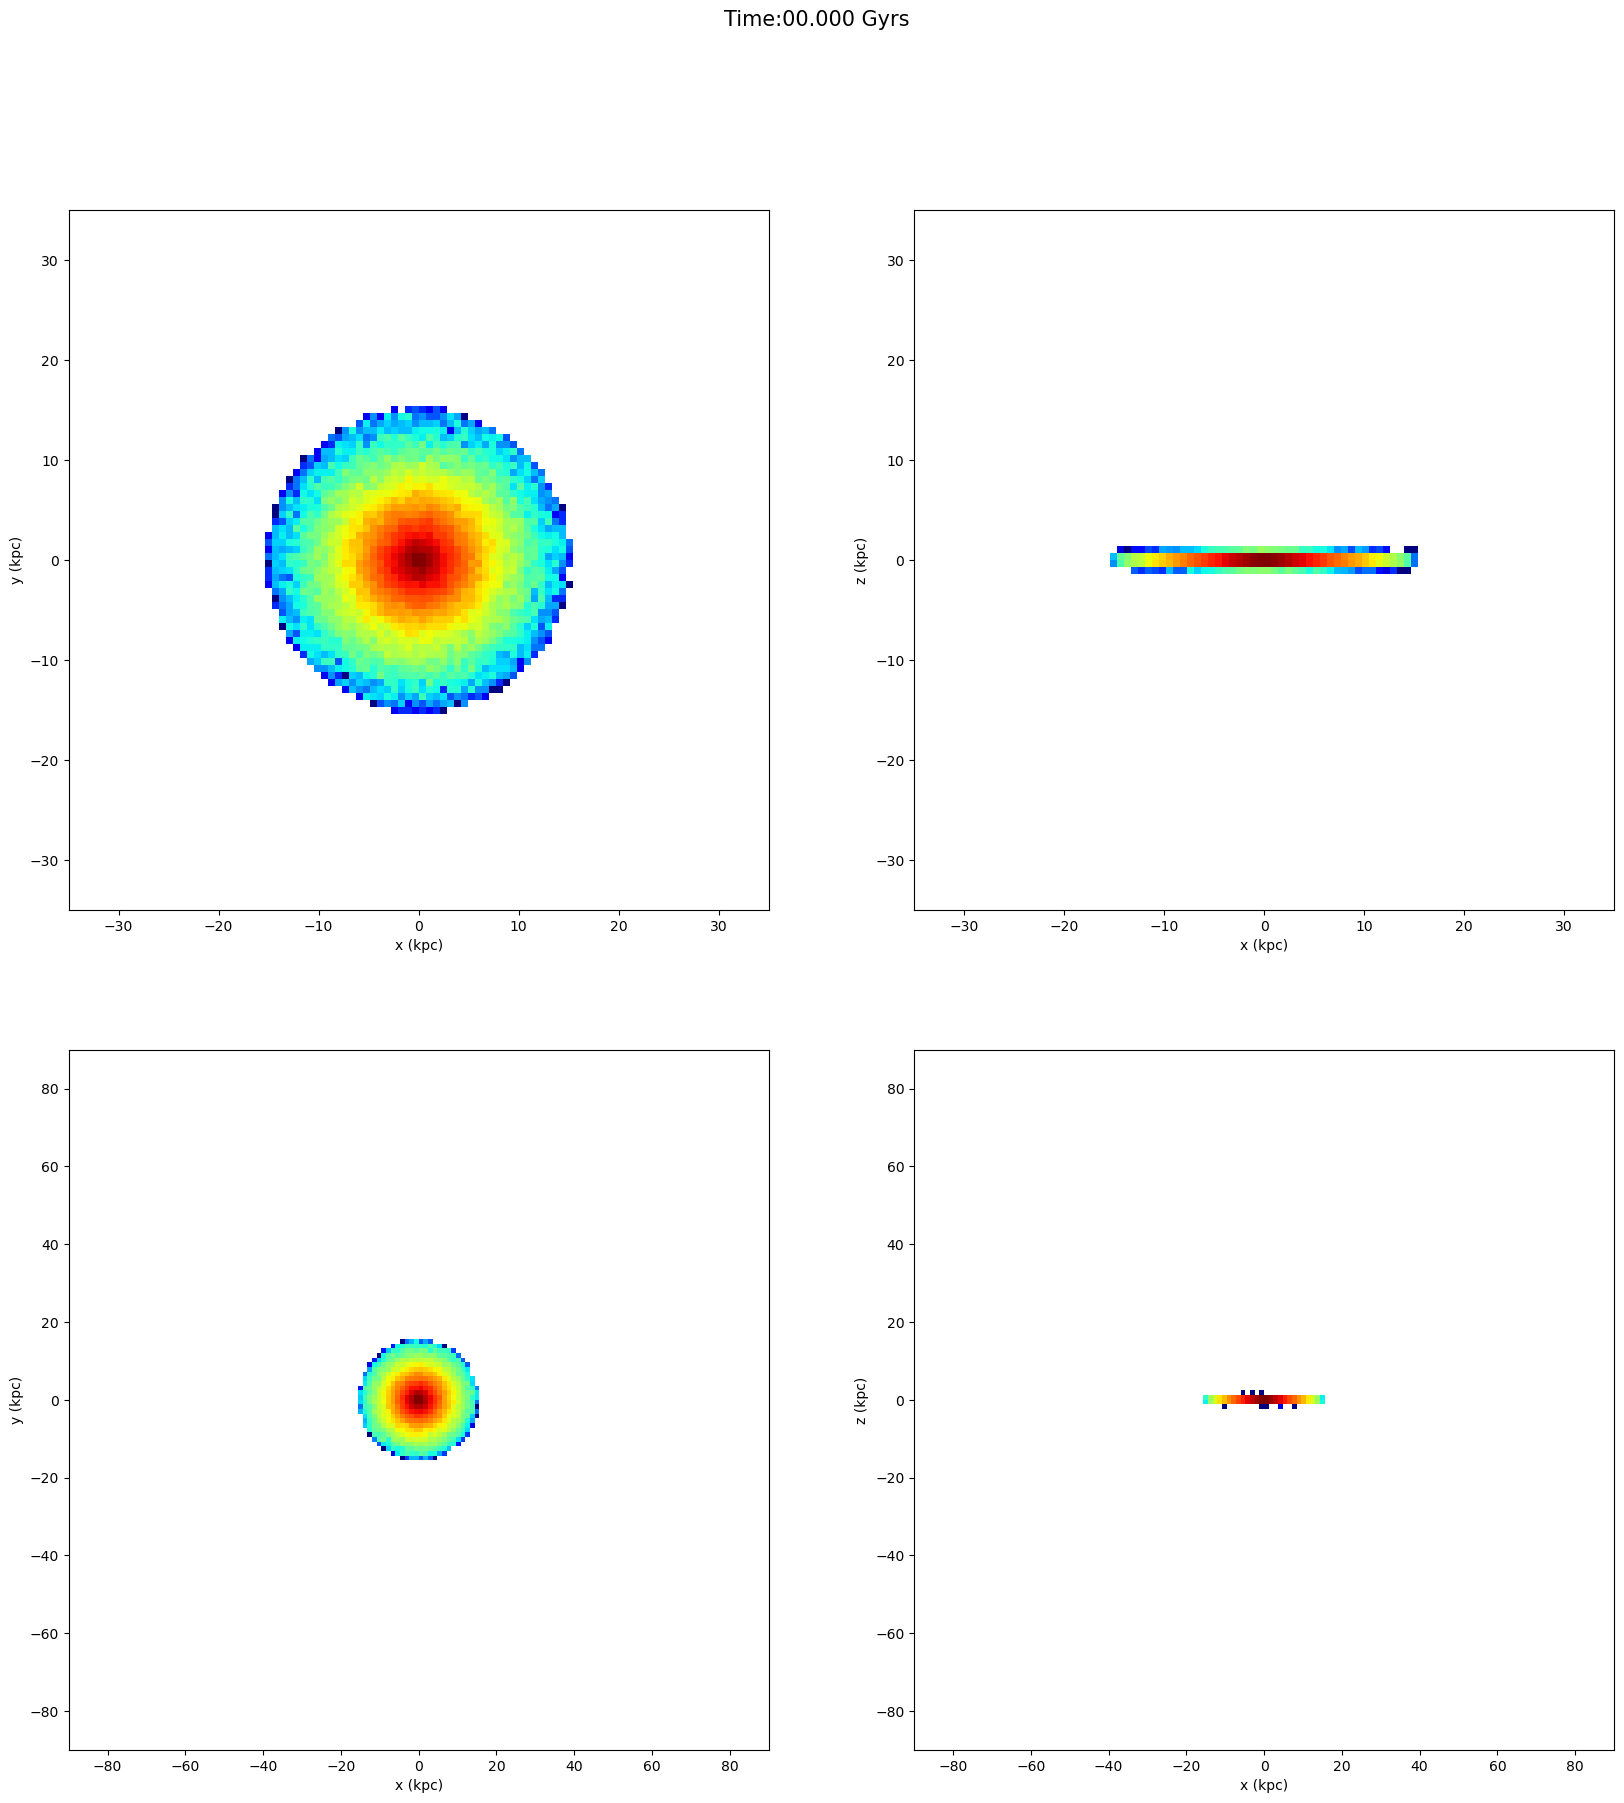

<Figure size 640x480 with 0 Axes>

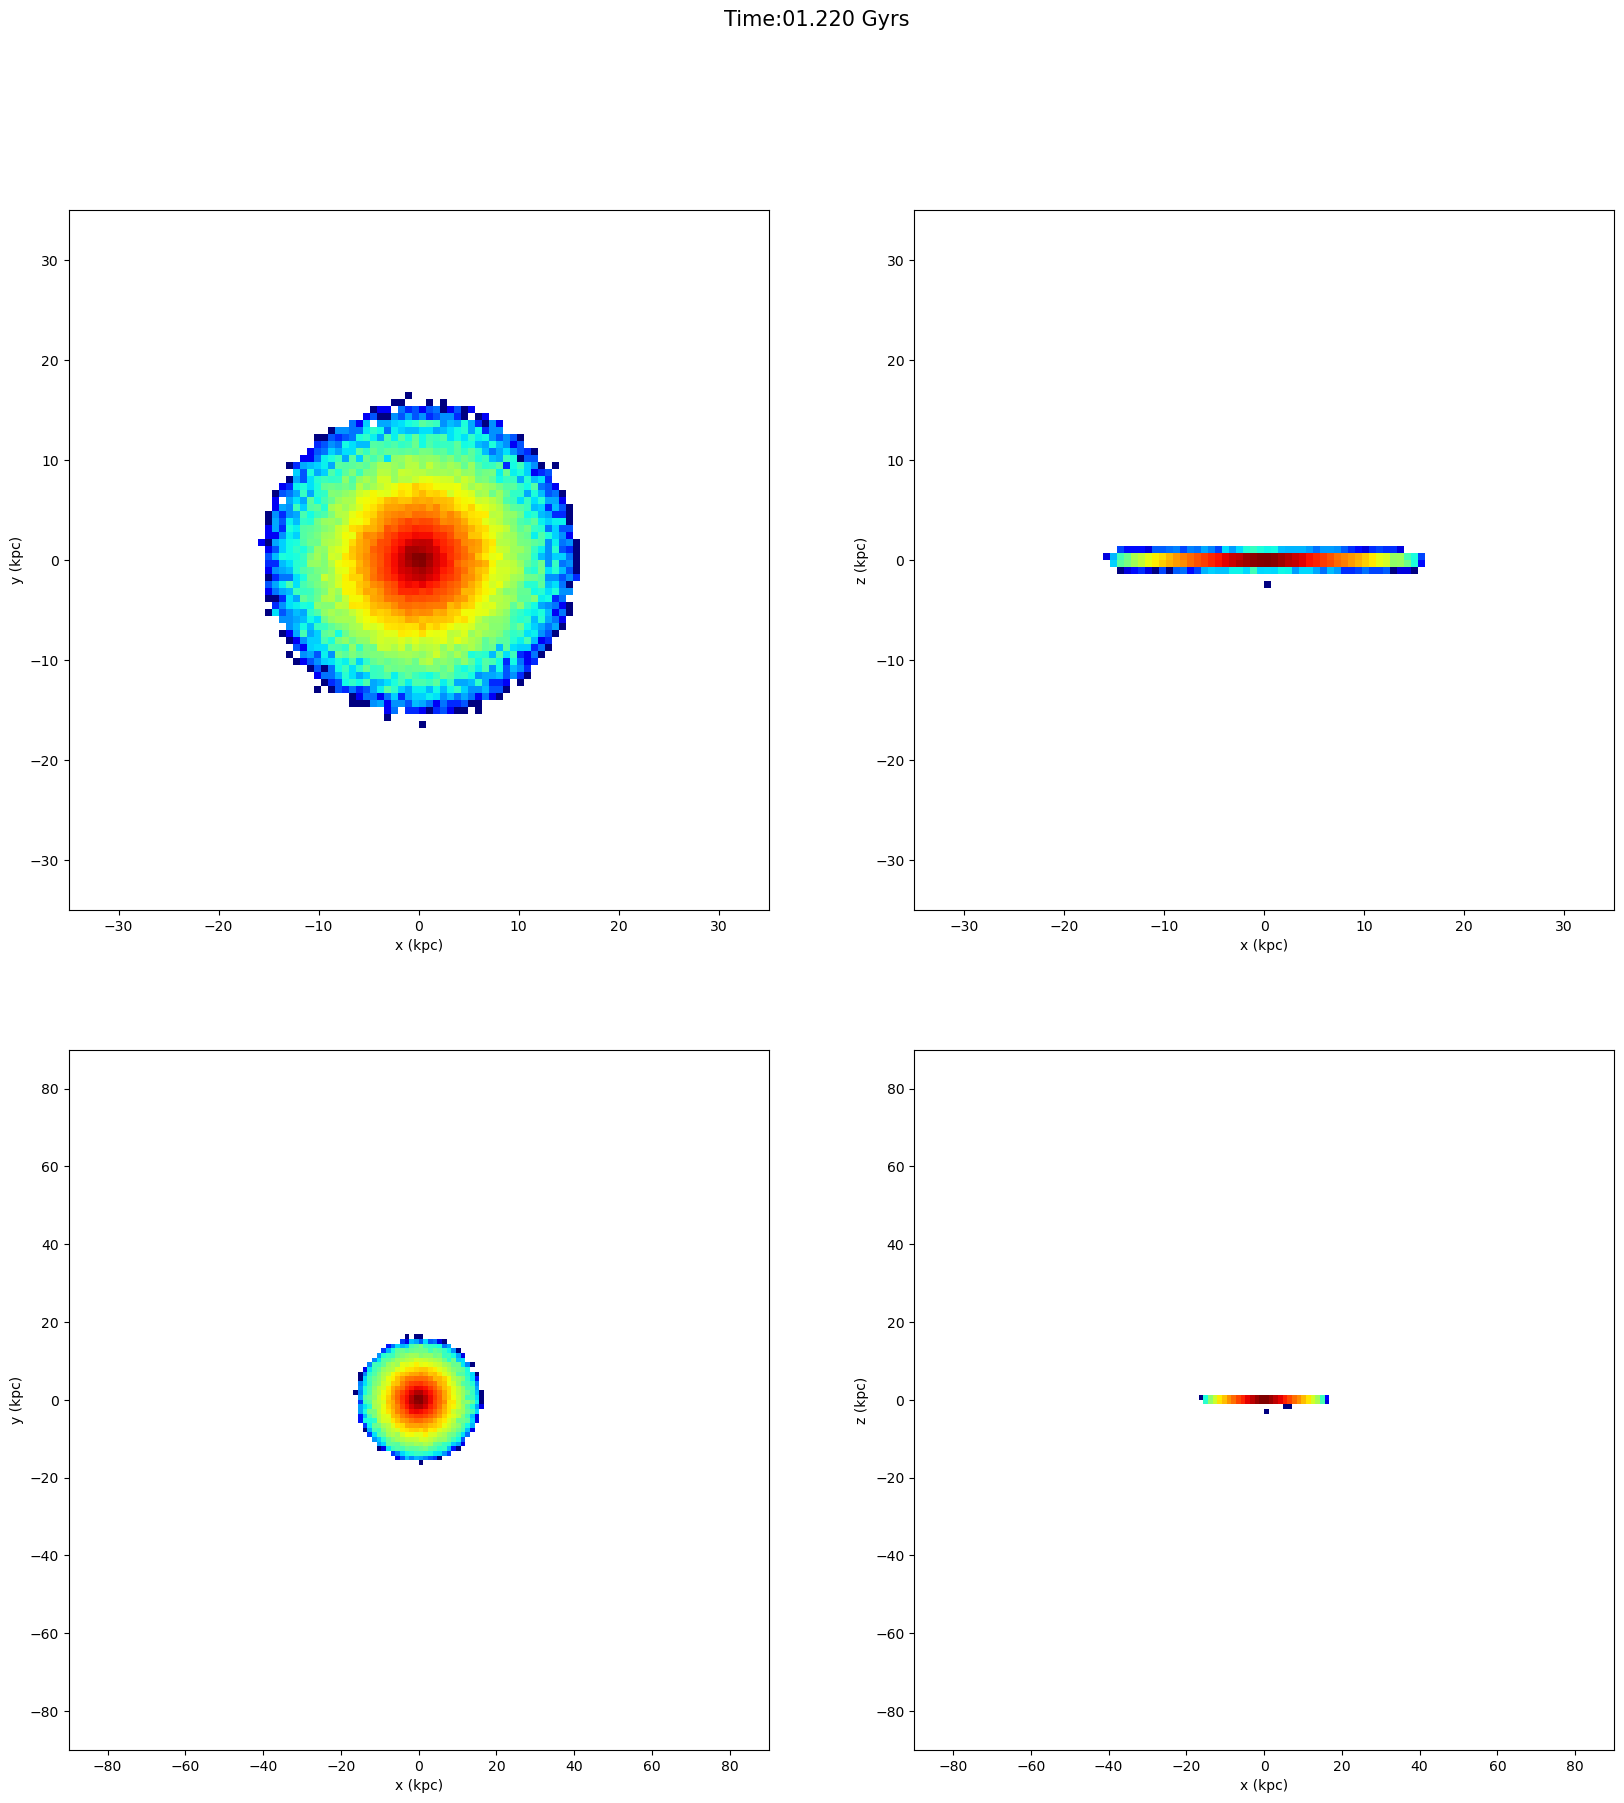

<Figure size 640x480 with 0 Axes>

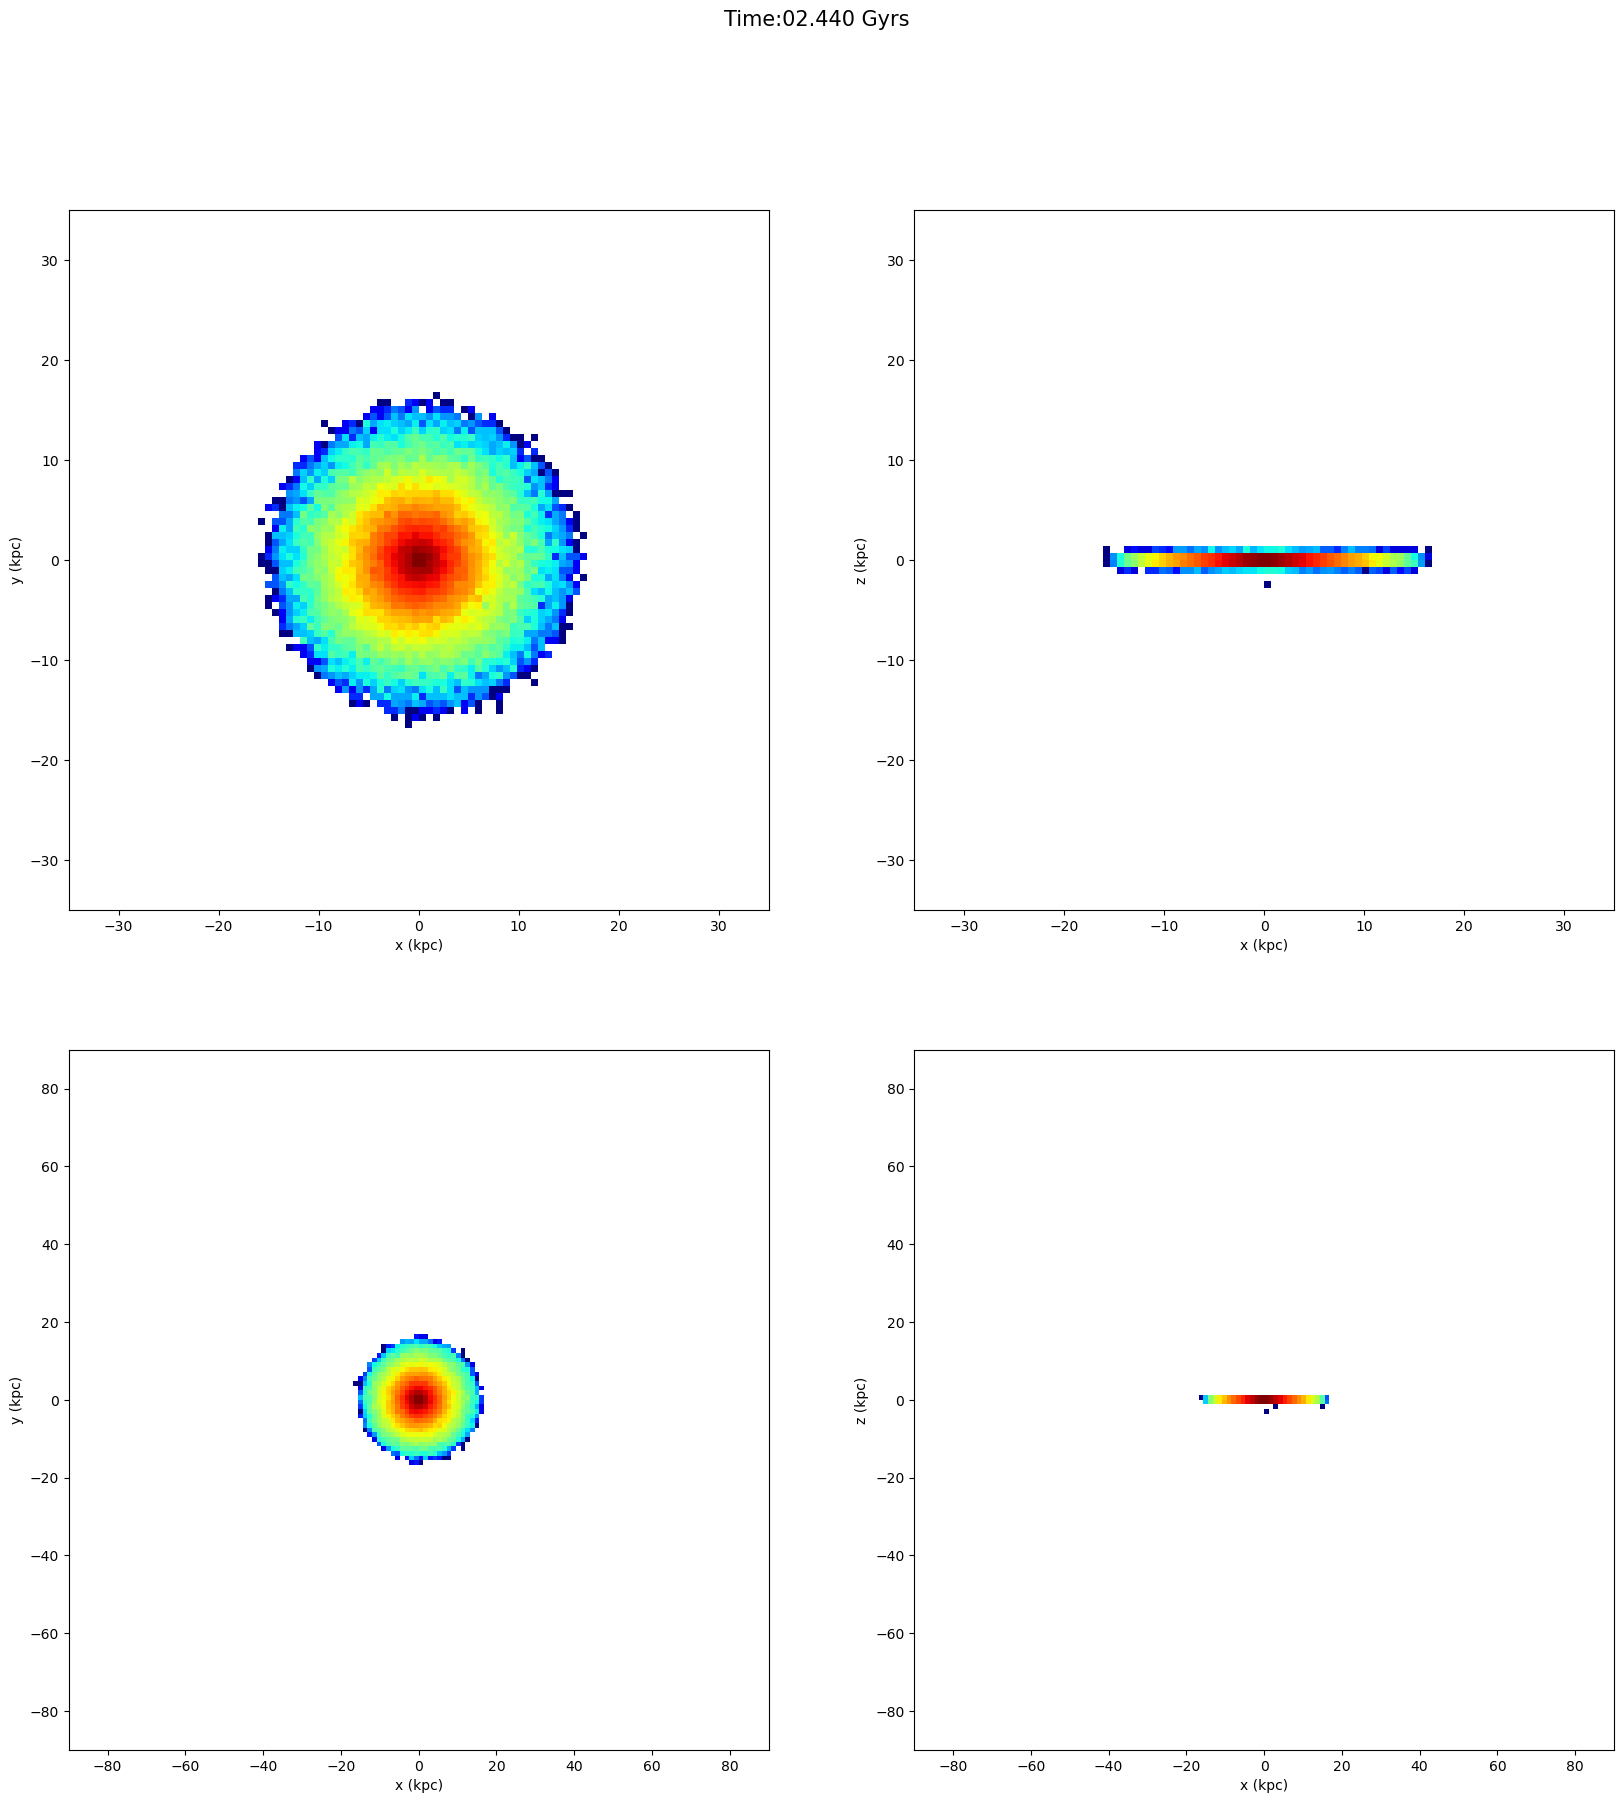

<Figure size 640x480 with 0 Axes>

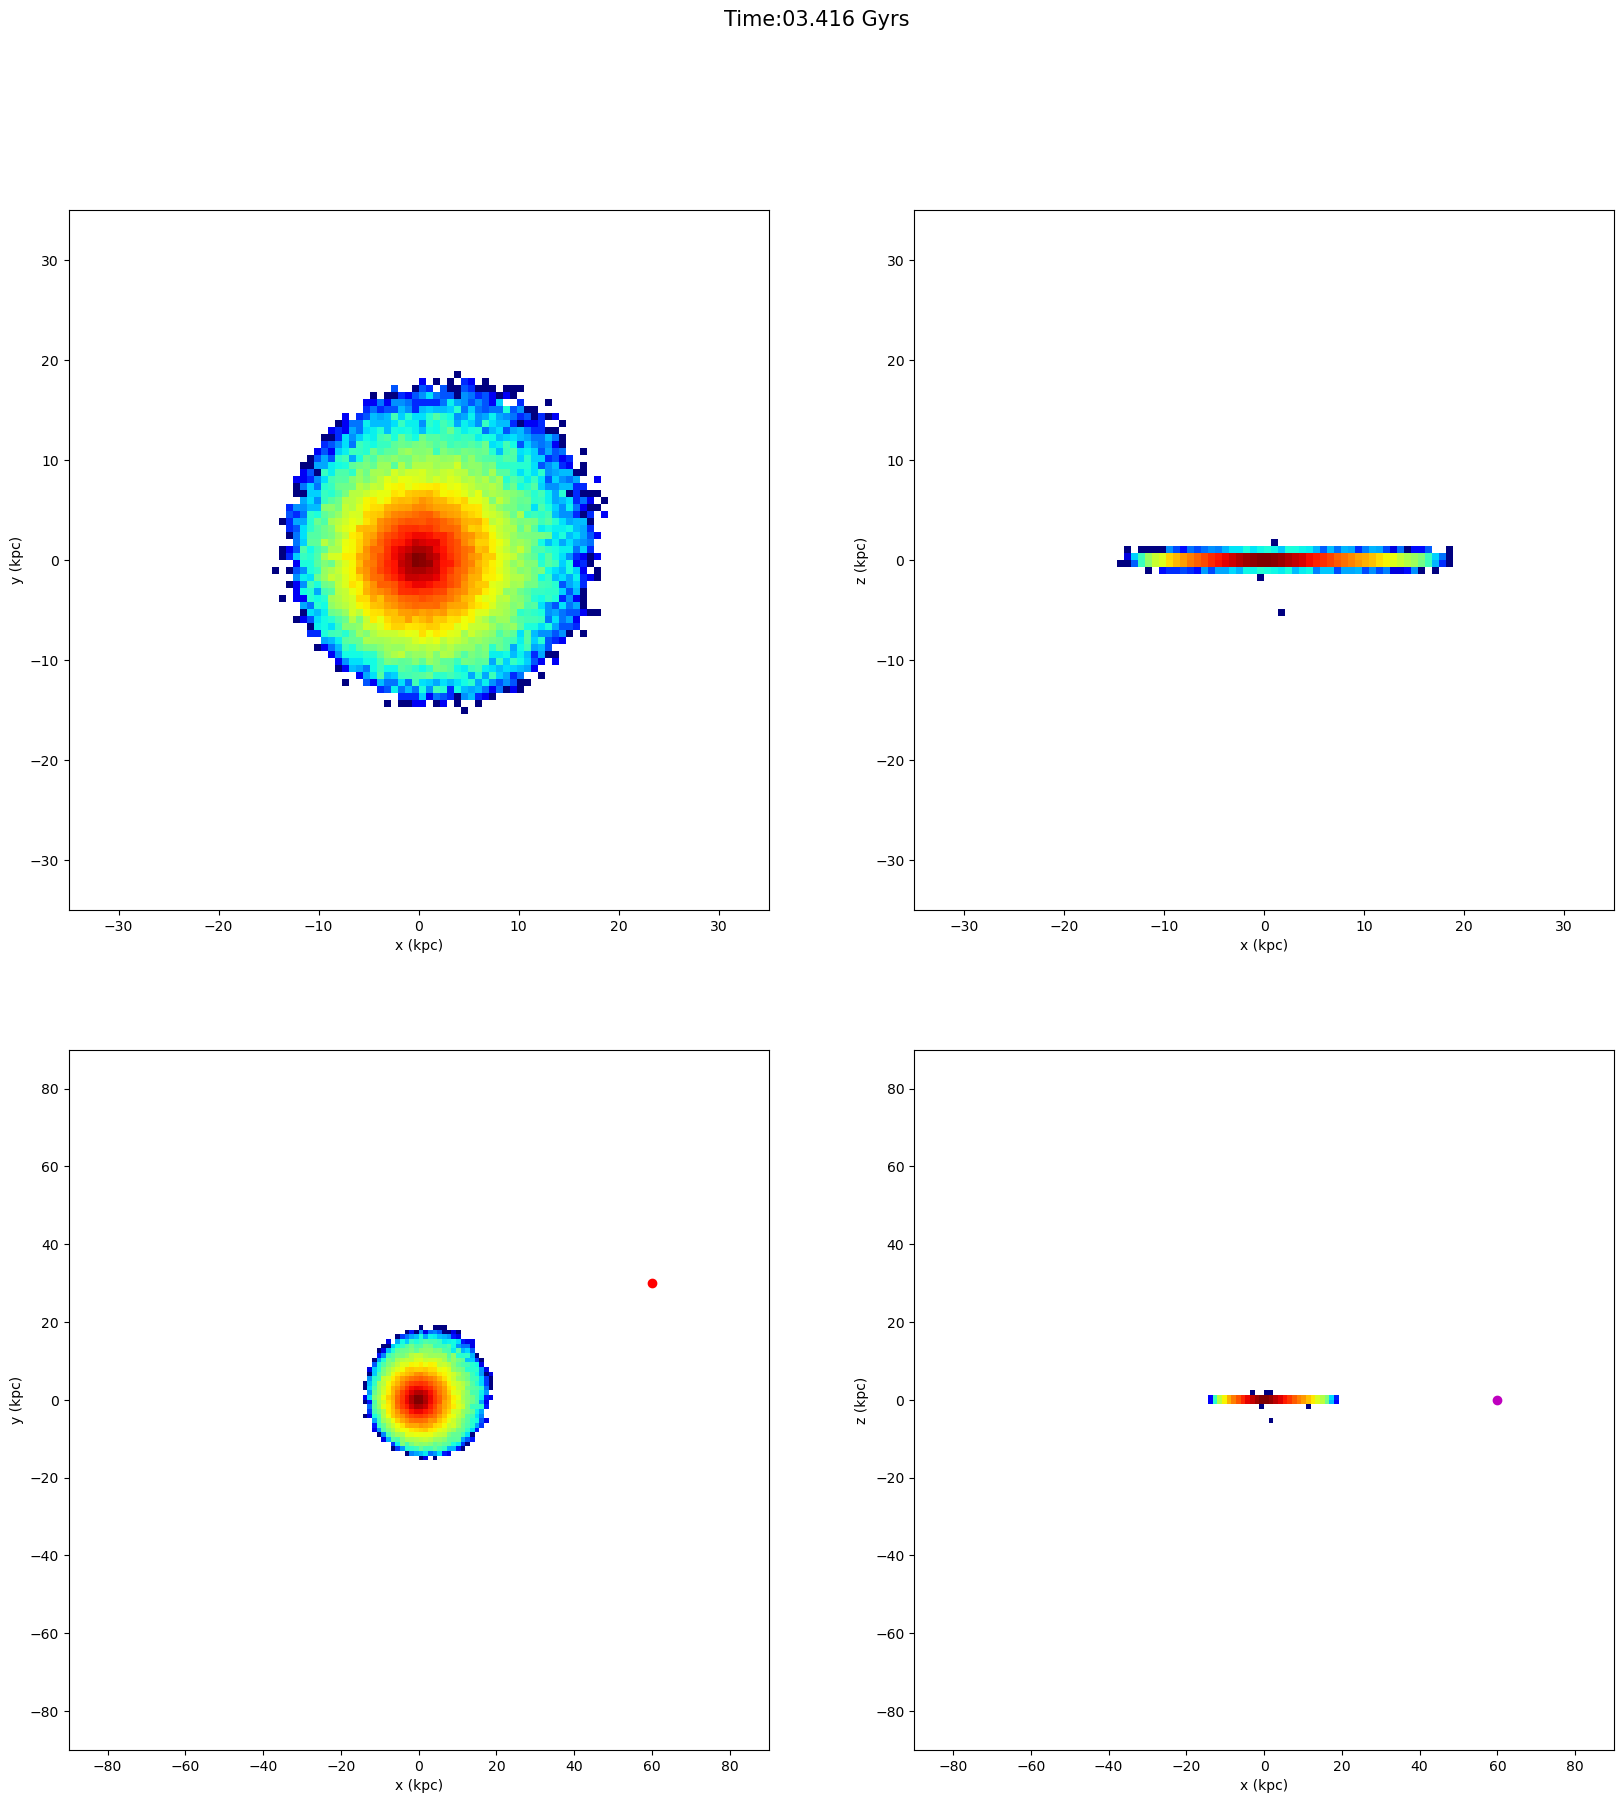

<Figure size 640x480 with 0 Axes>

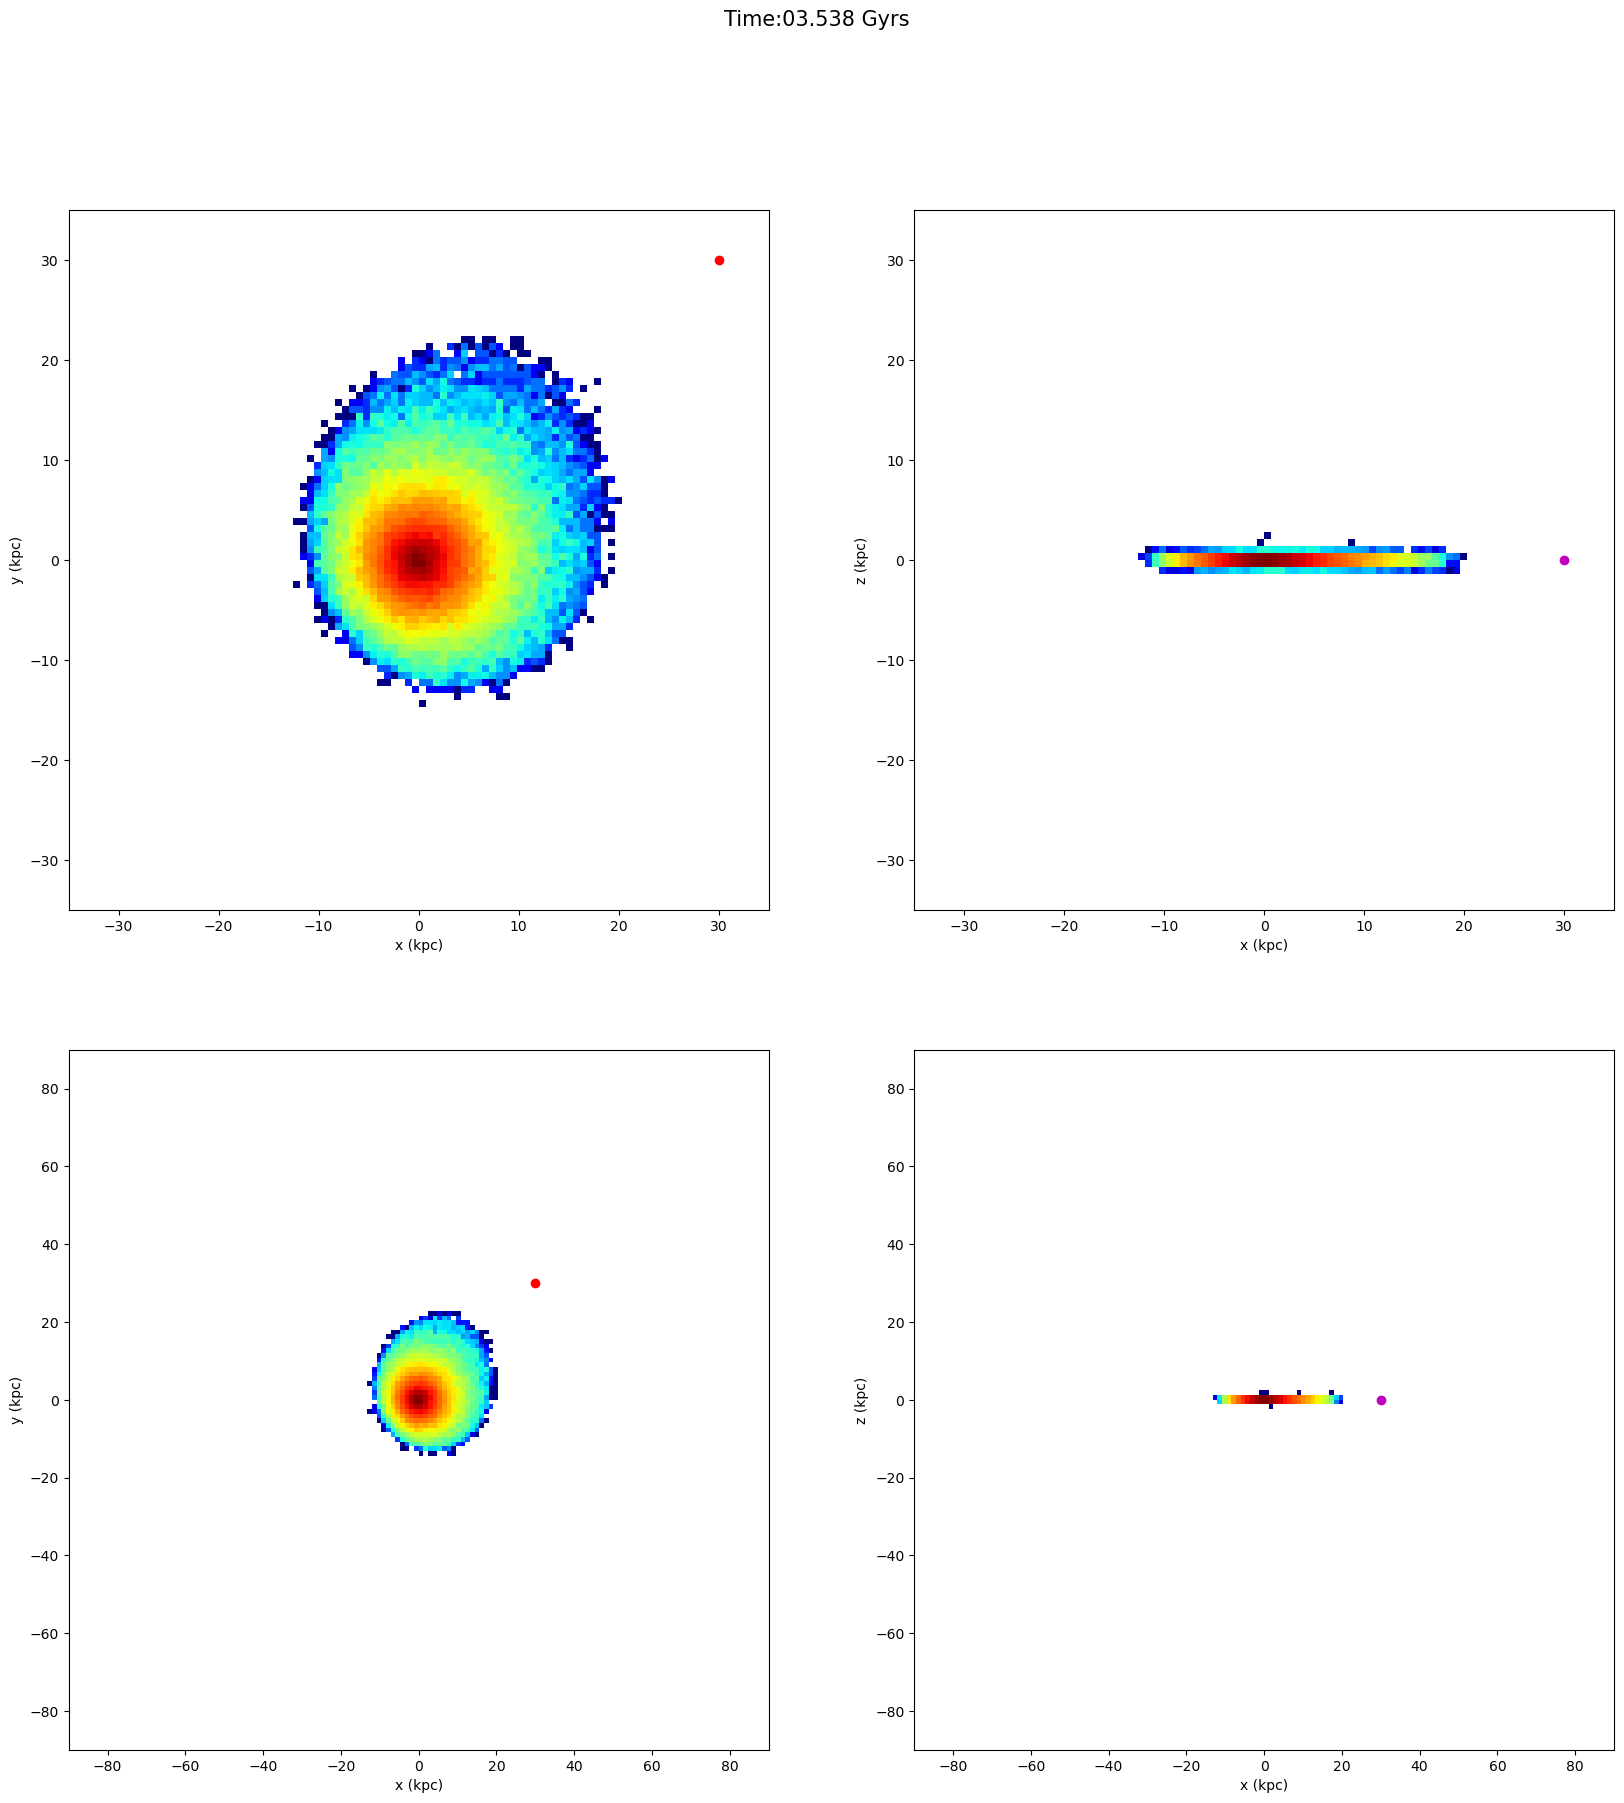

<Figure size 640x480 with 0 Axes>

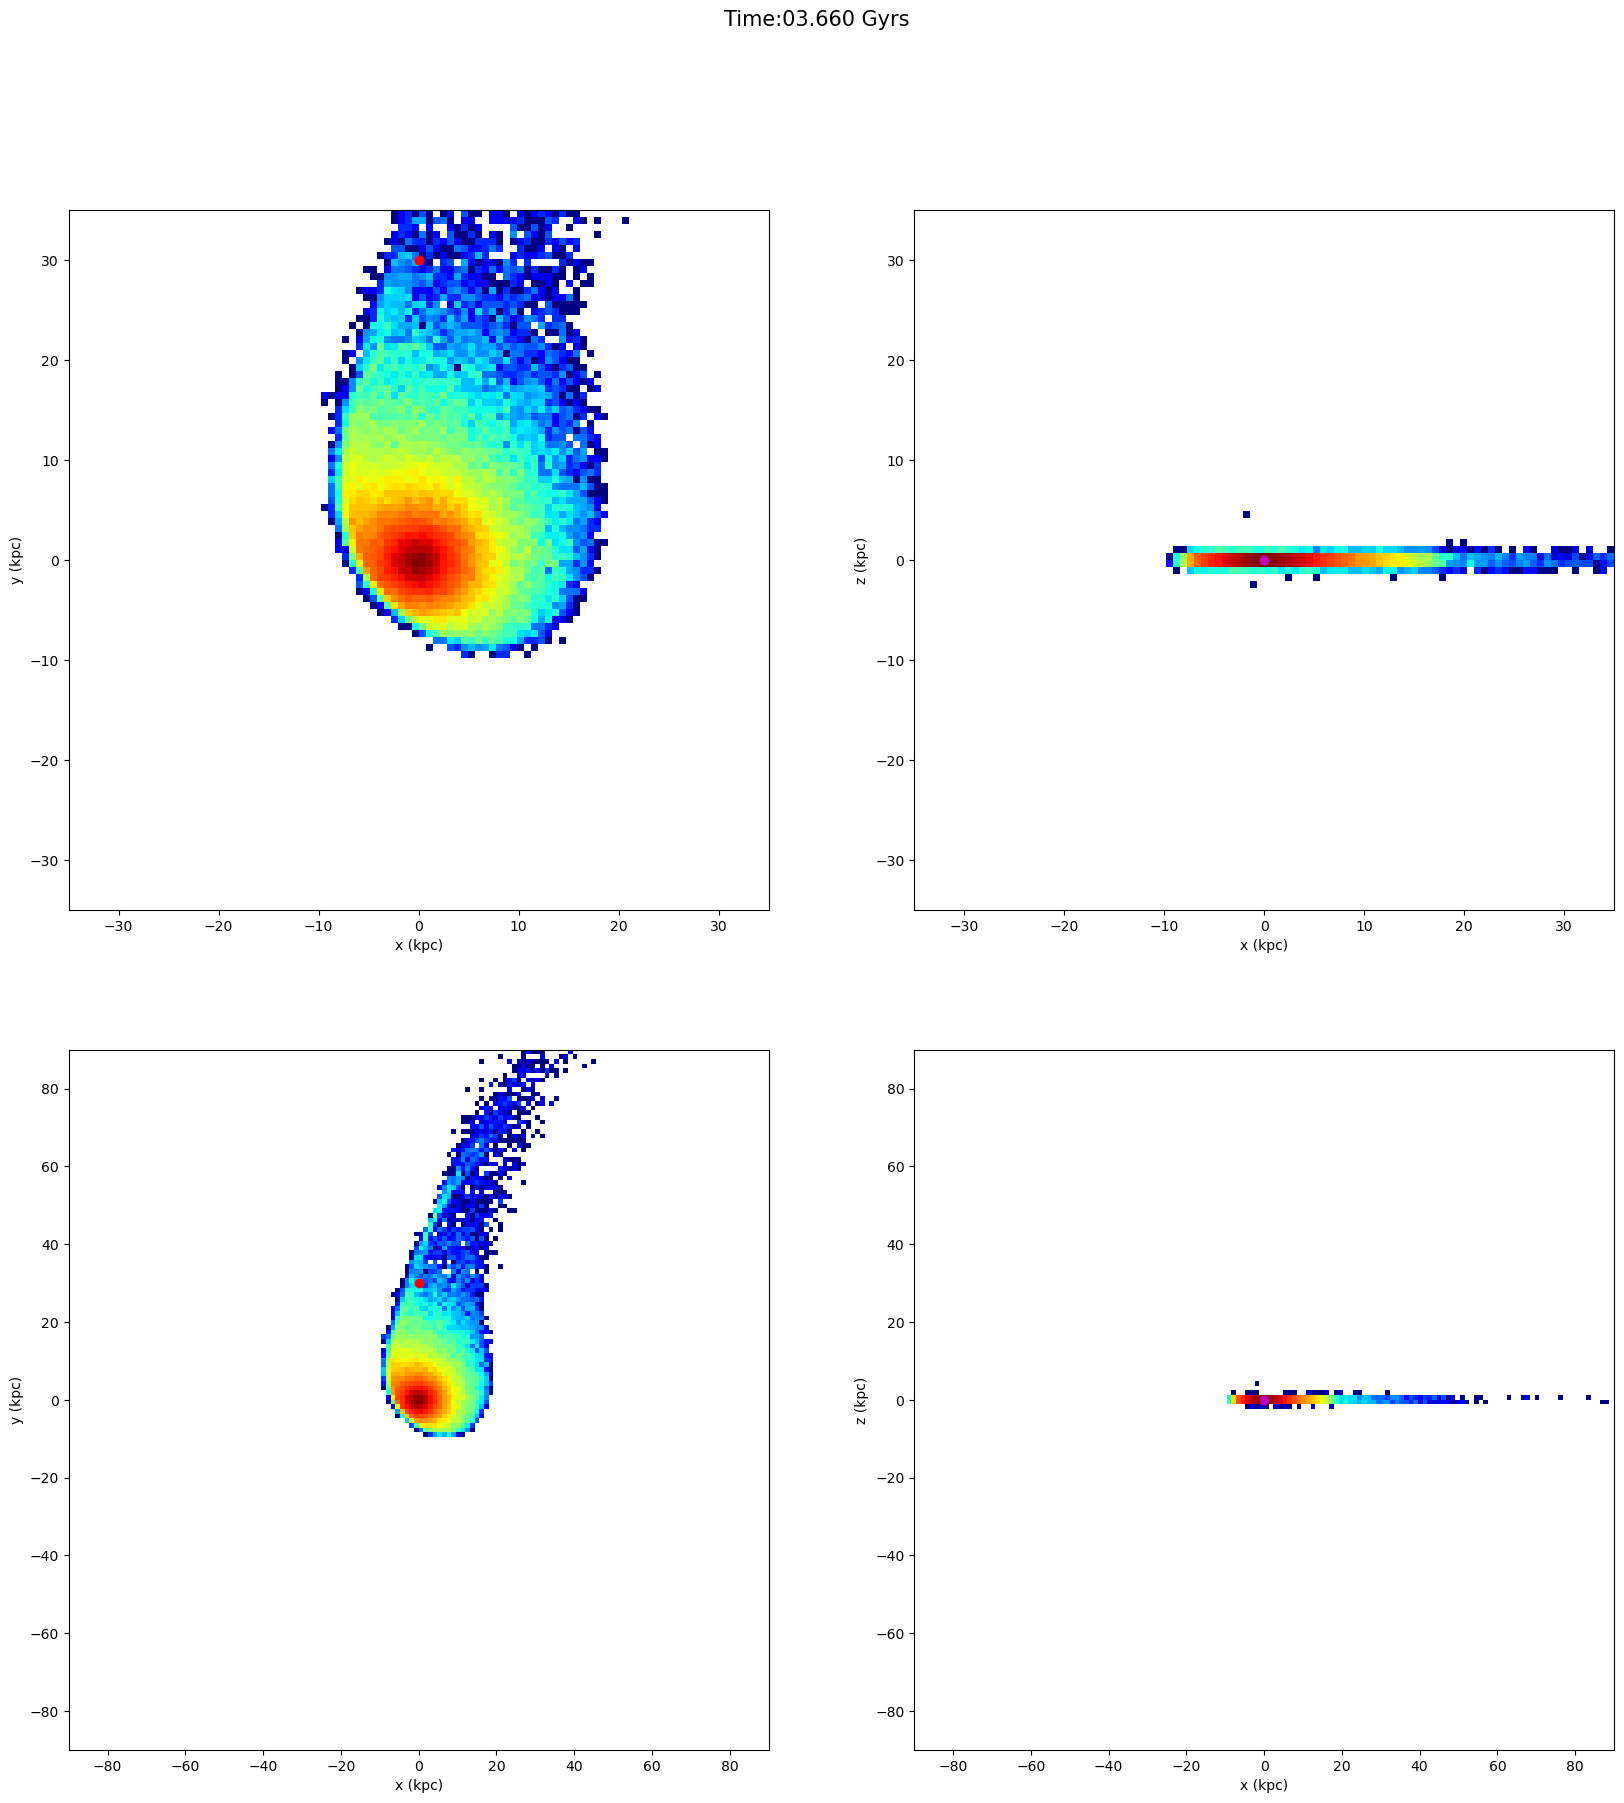

<Figure size 640x480 with 0 Axes>

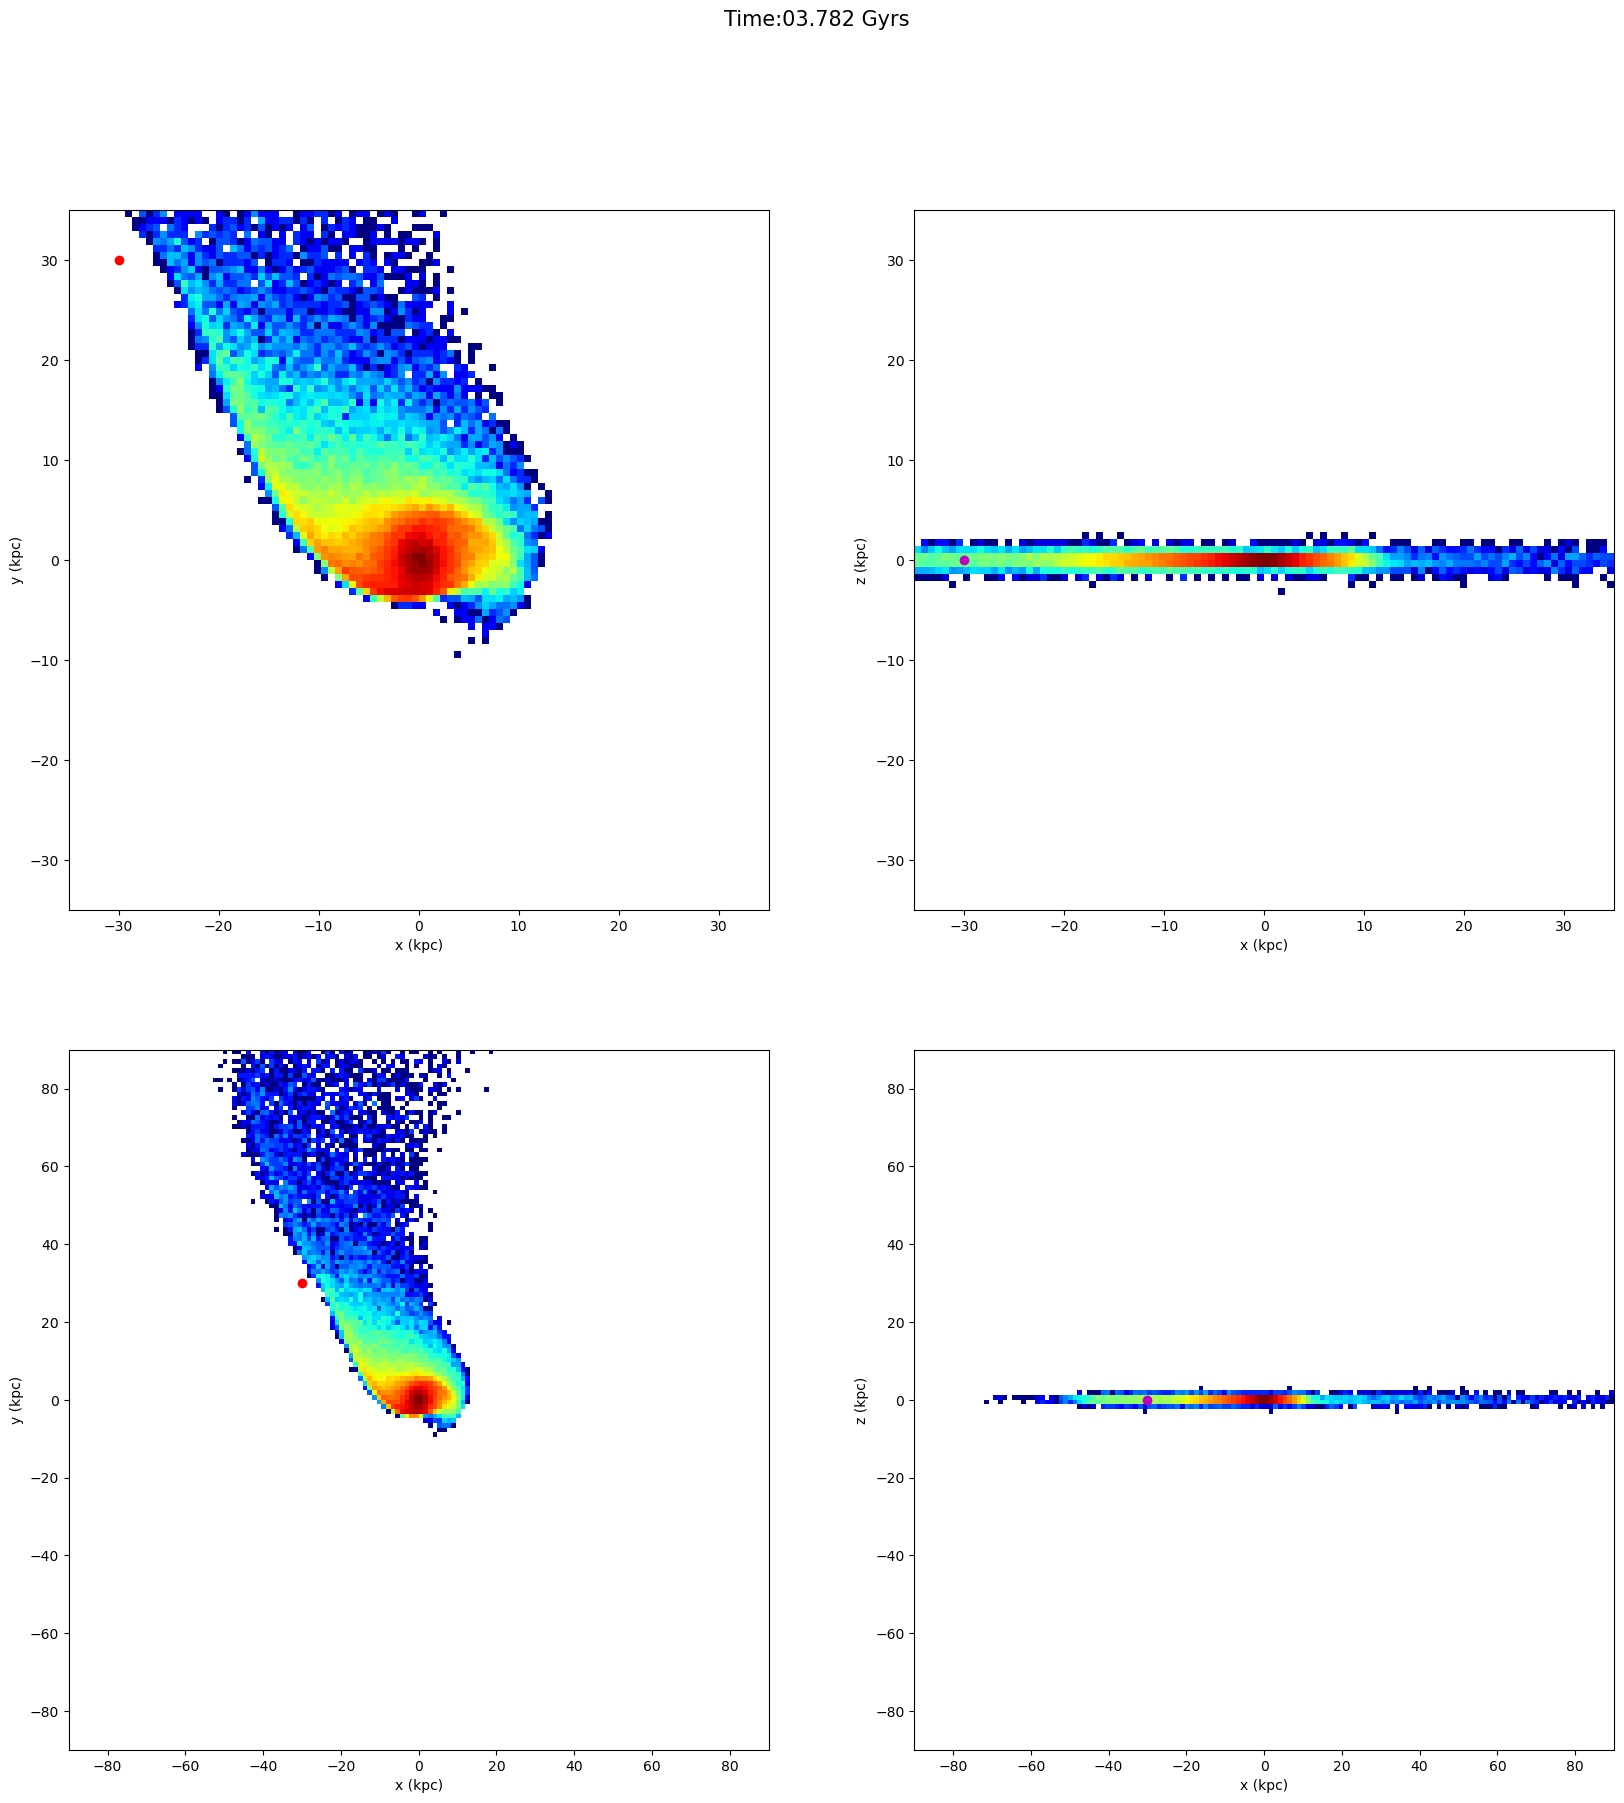

<Figure size 640x480 with 0 Axes>

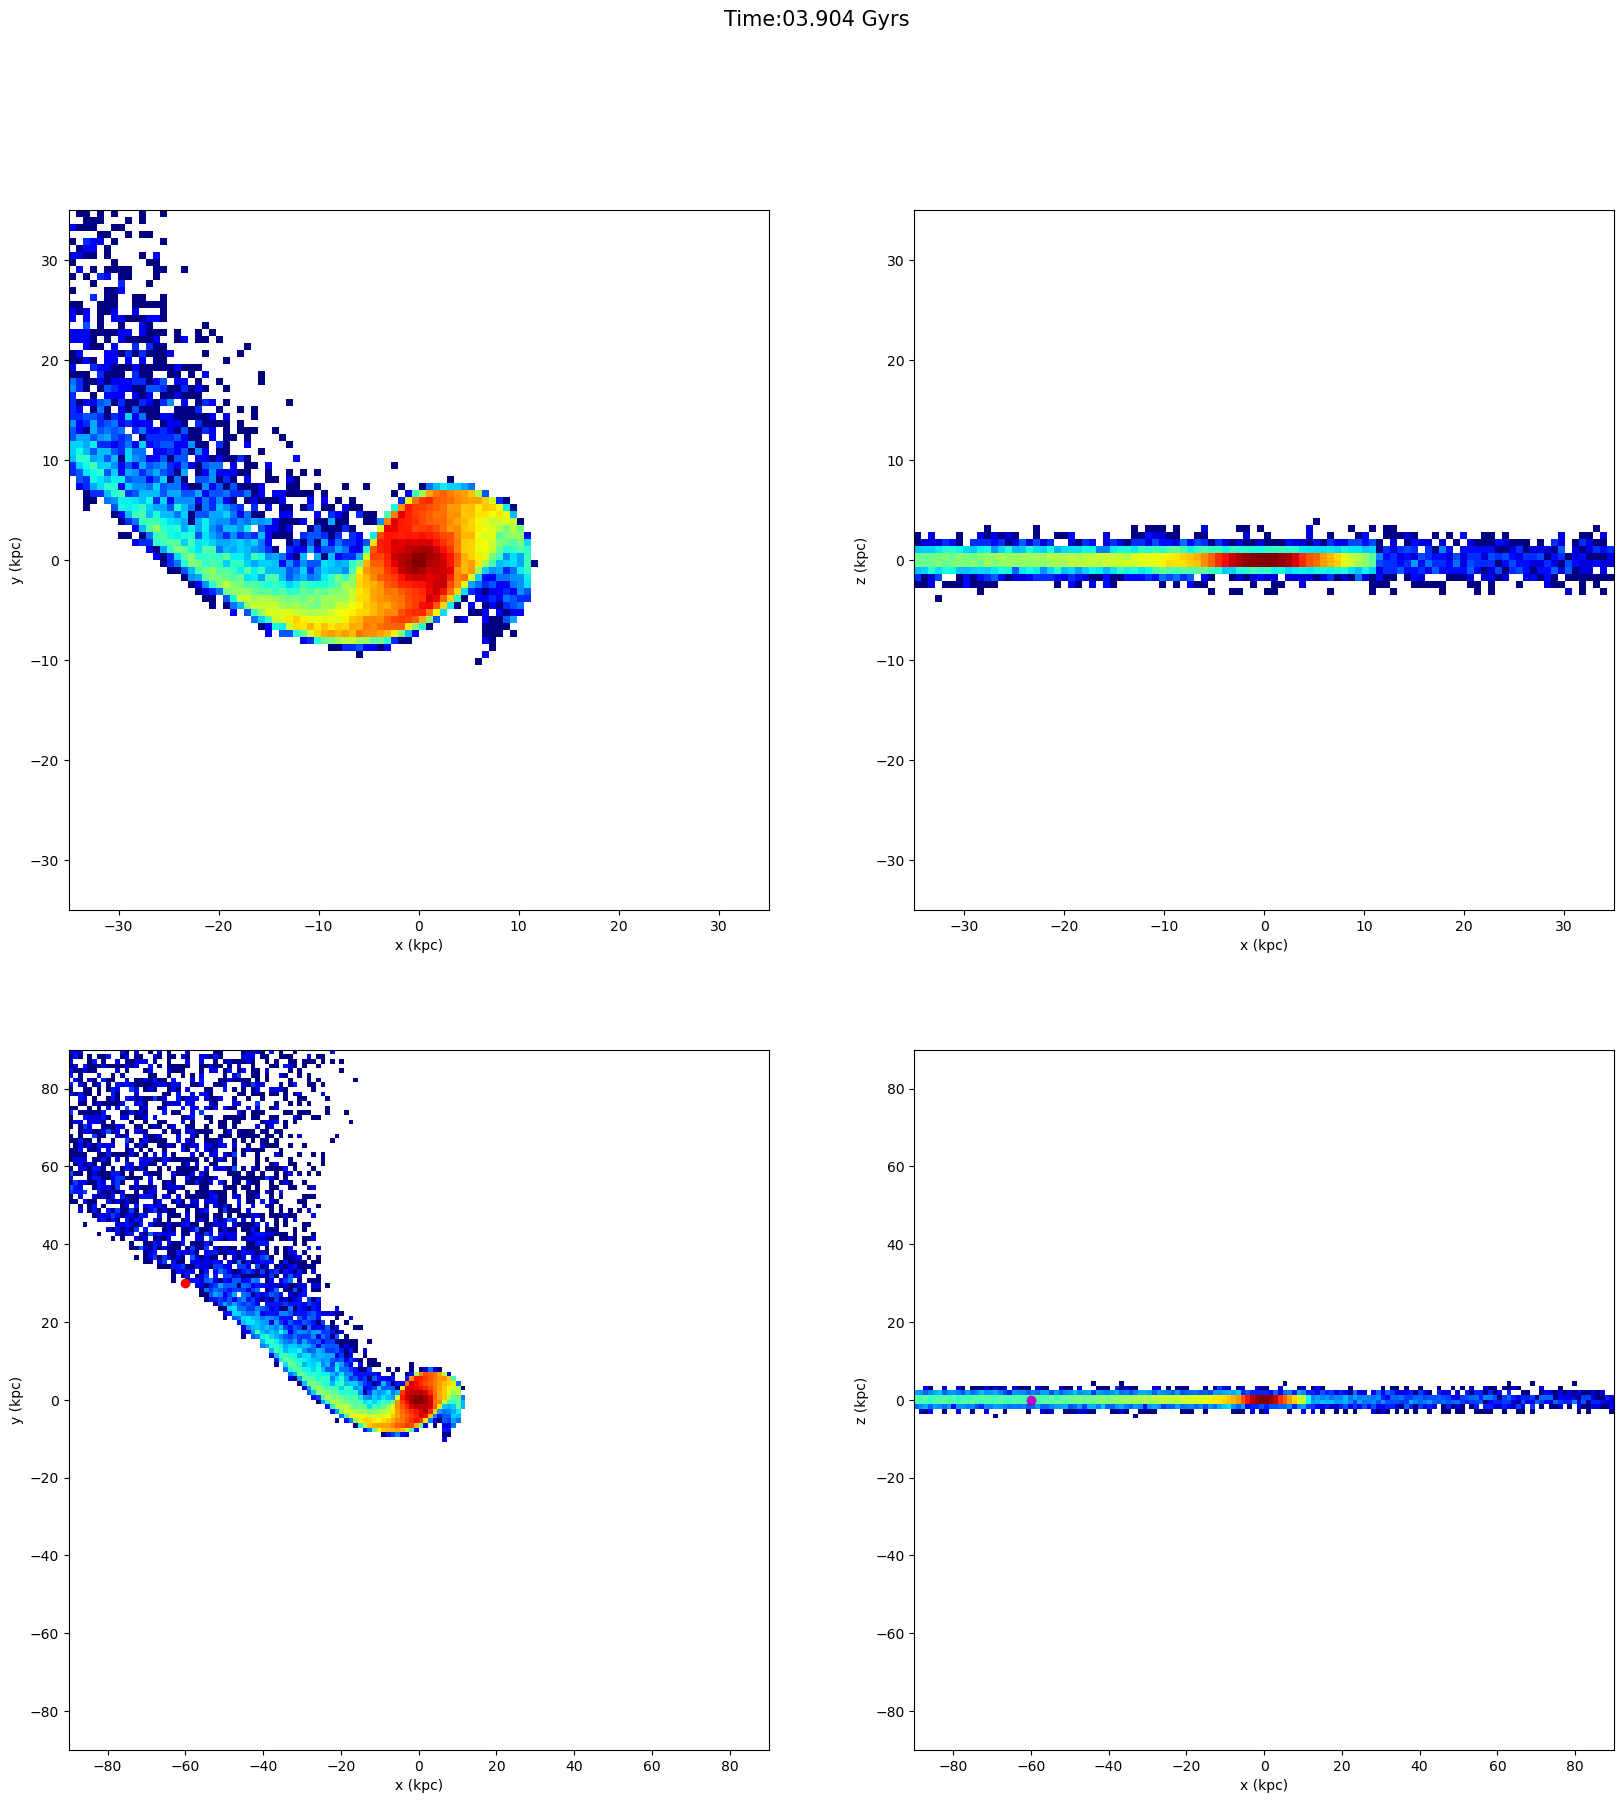

<Figure size 640x480 with 0 Axes>

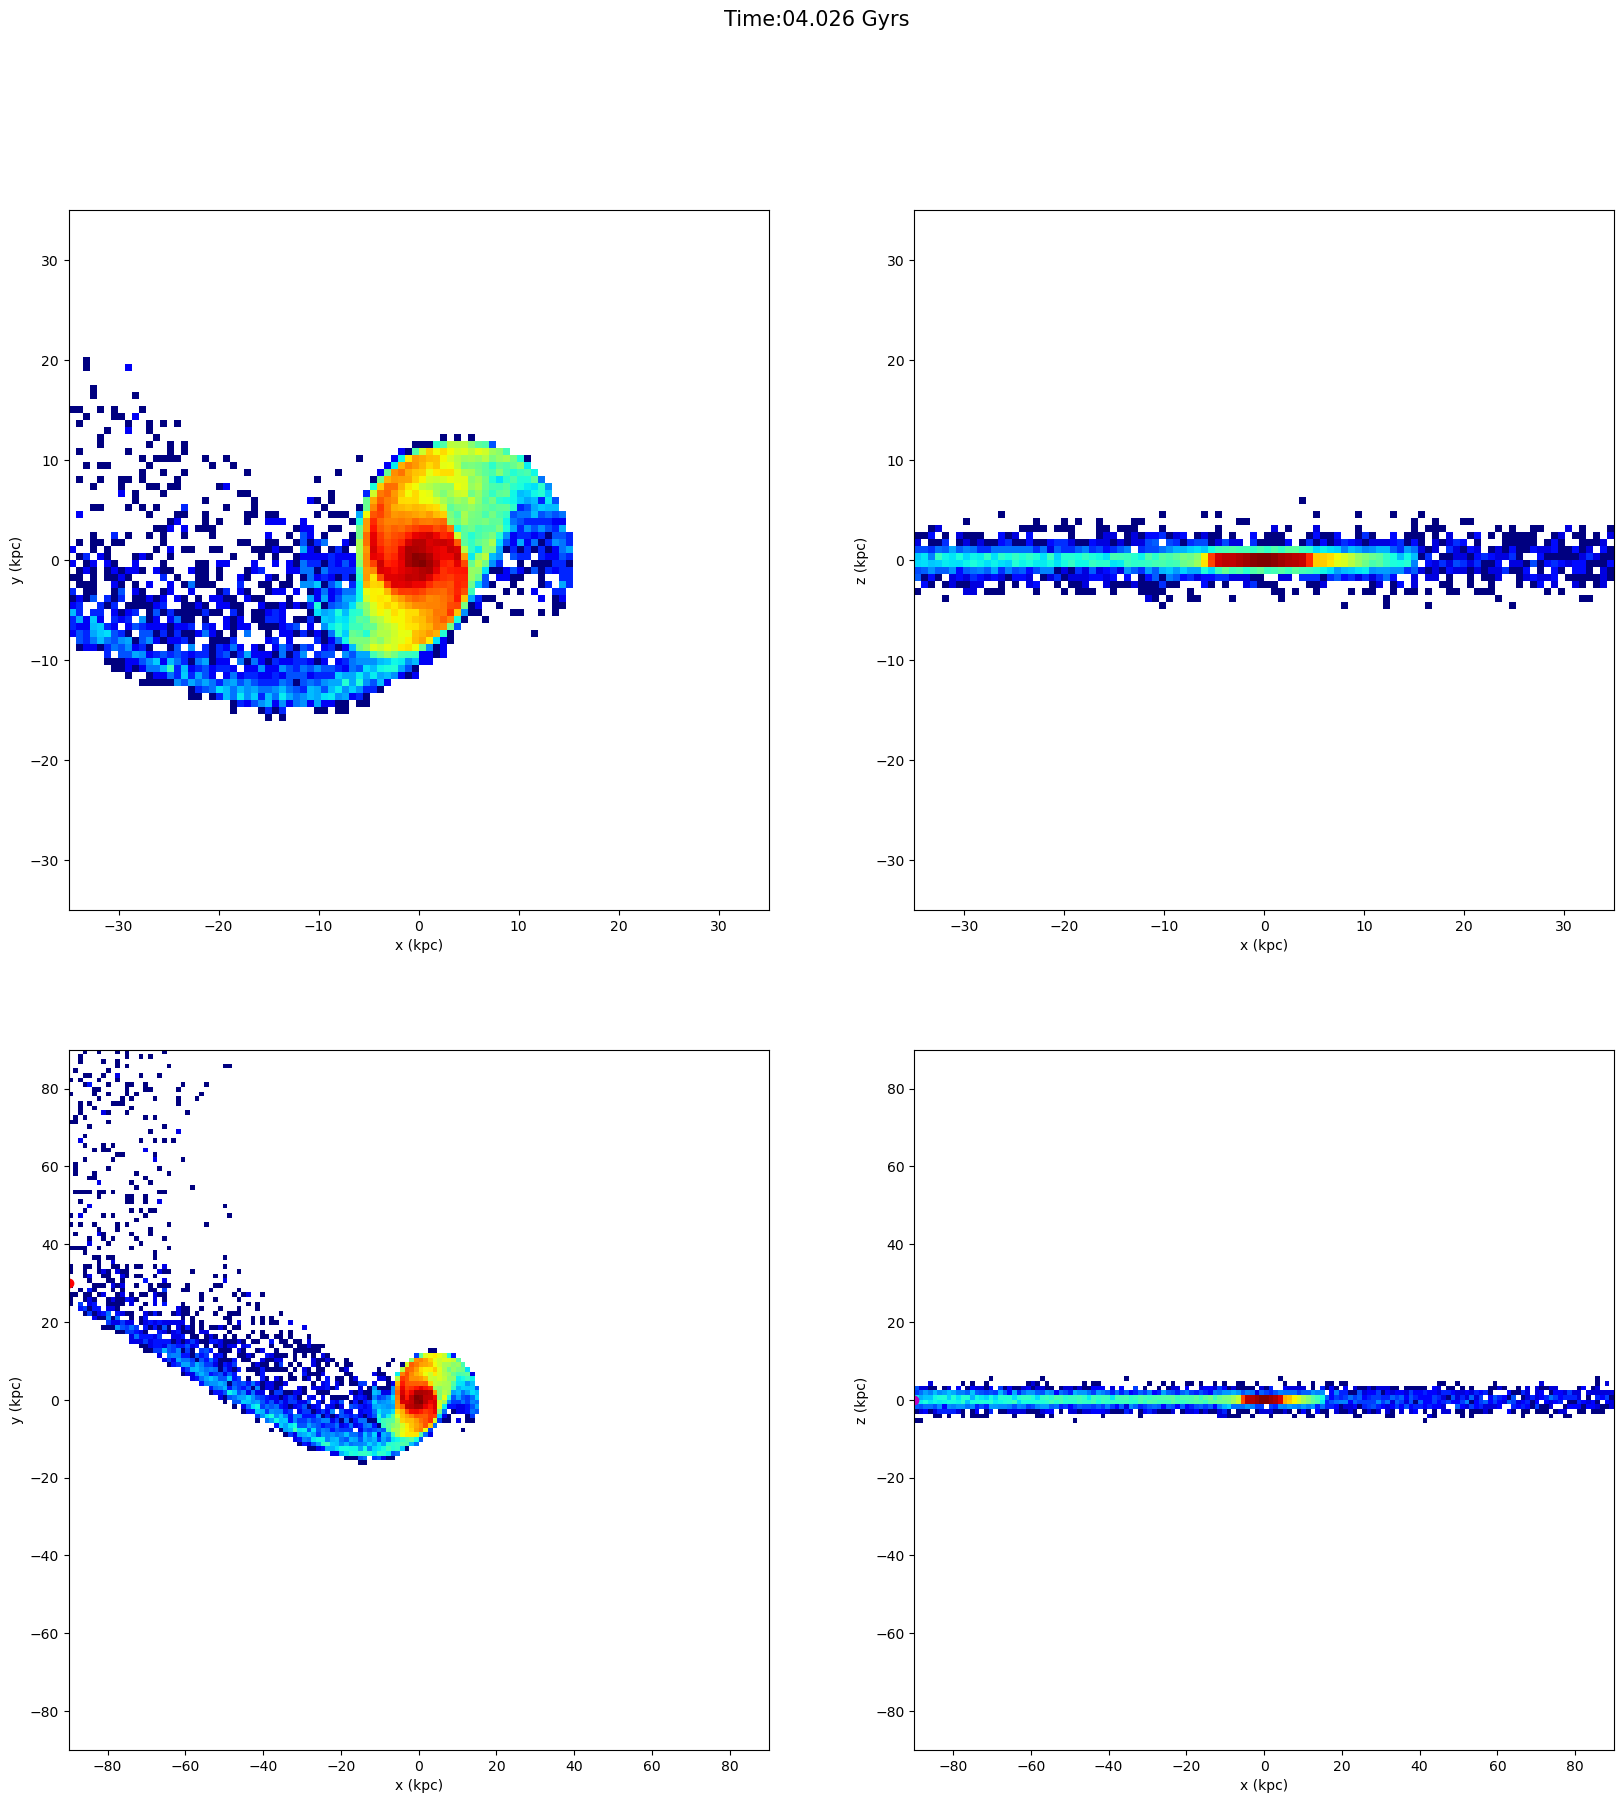

<Figure size 640x480 with 0 Axes>

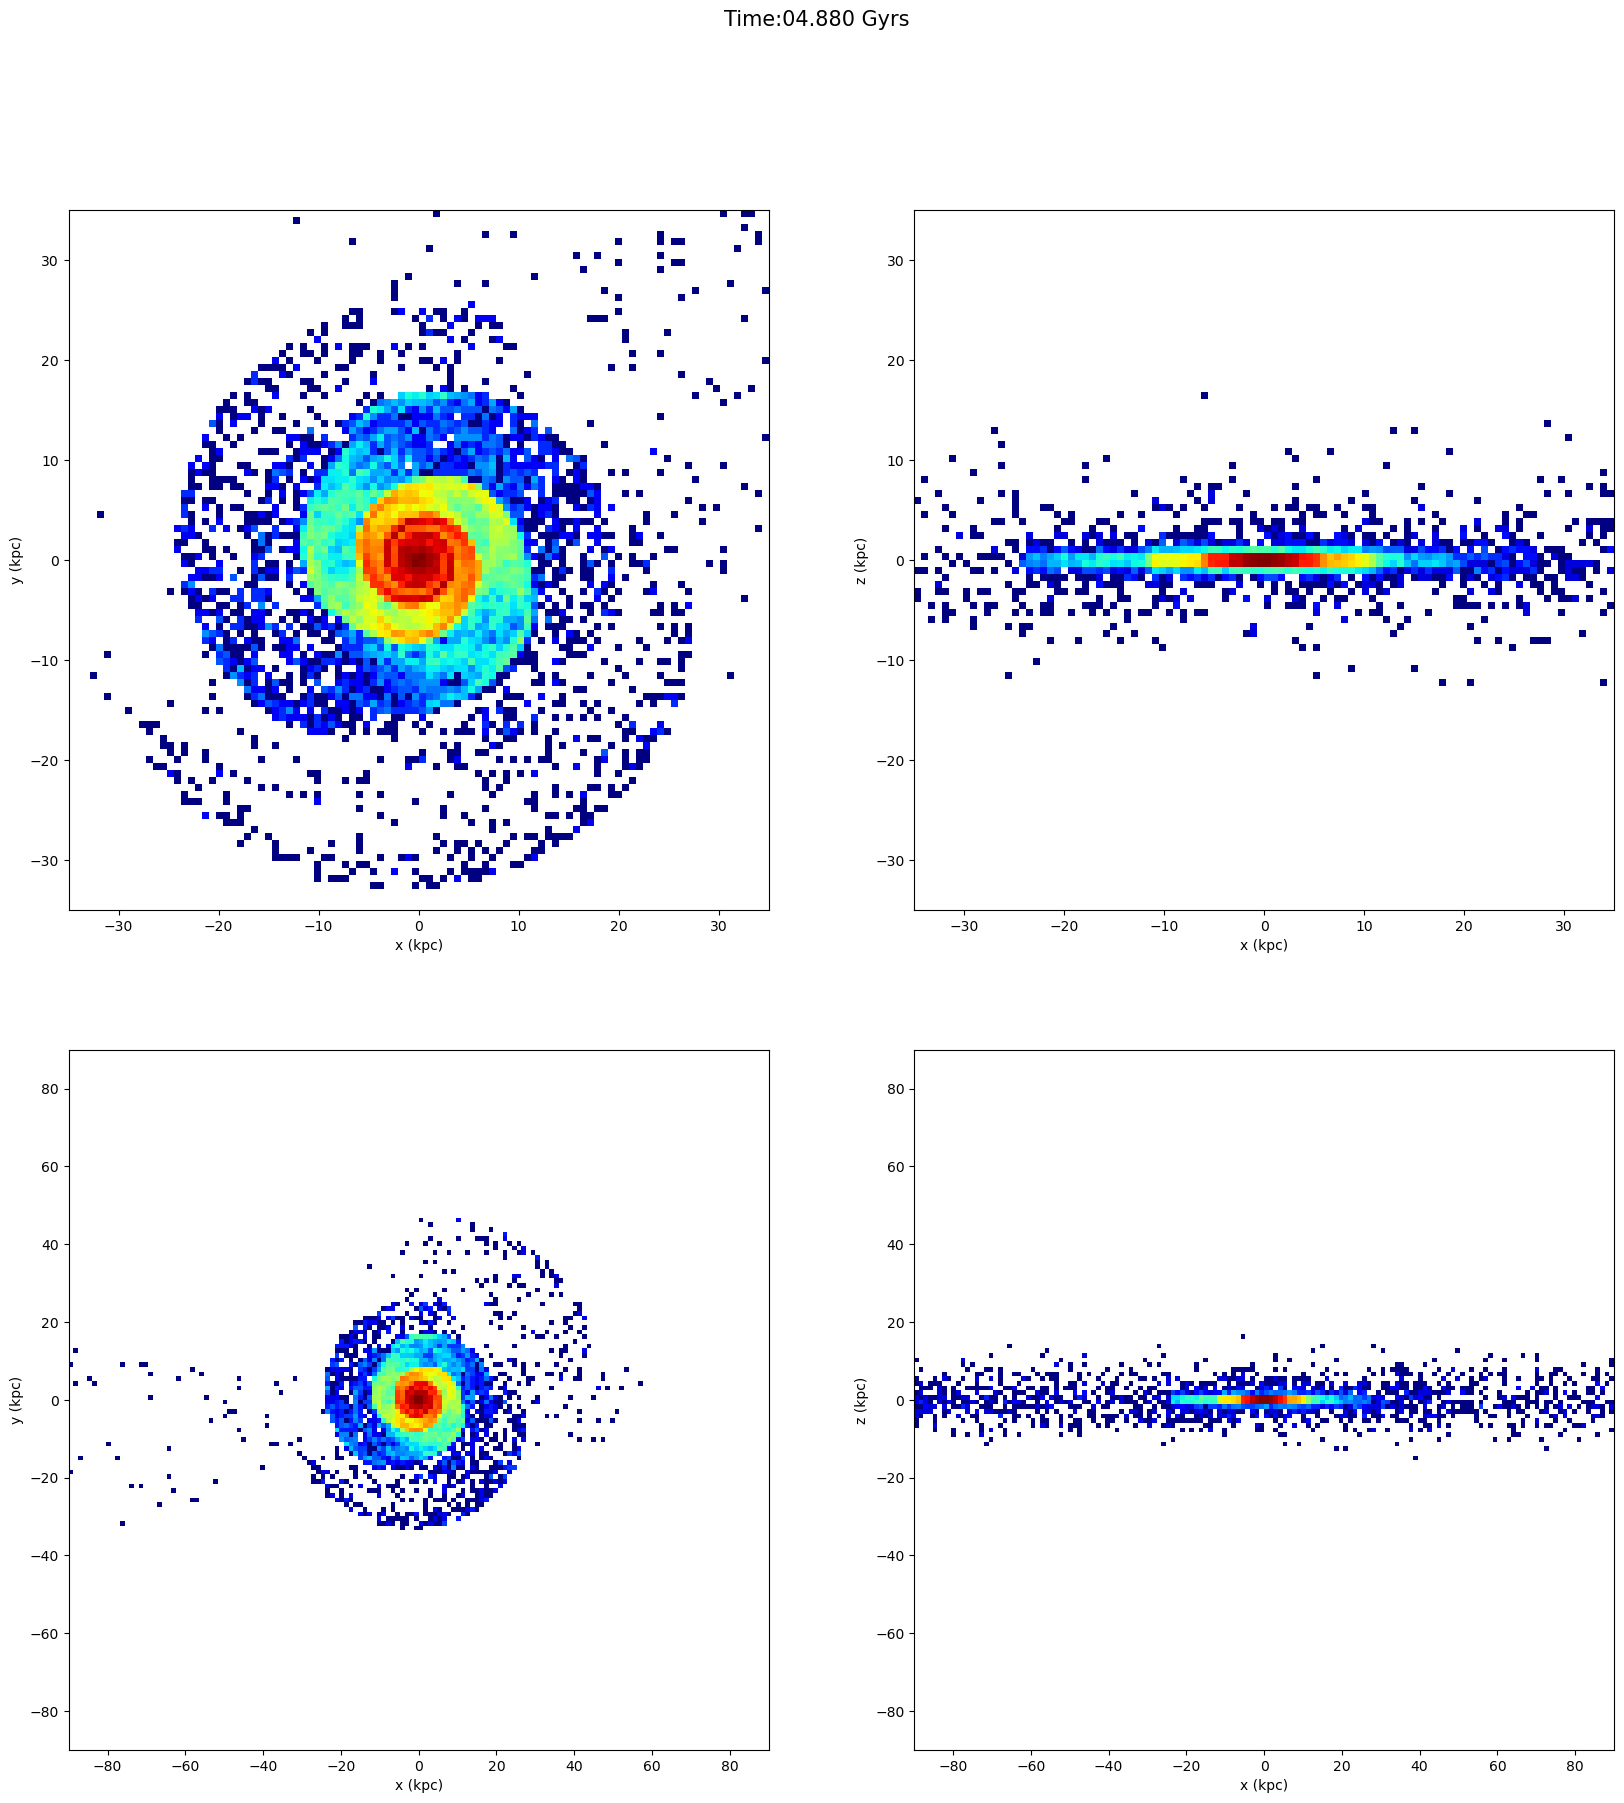

<Figure size 640x480 with 0 Axes>

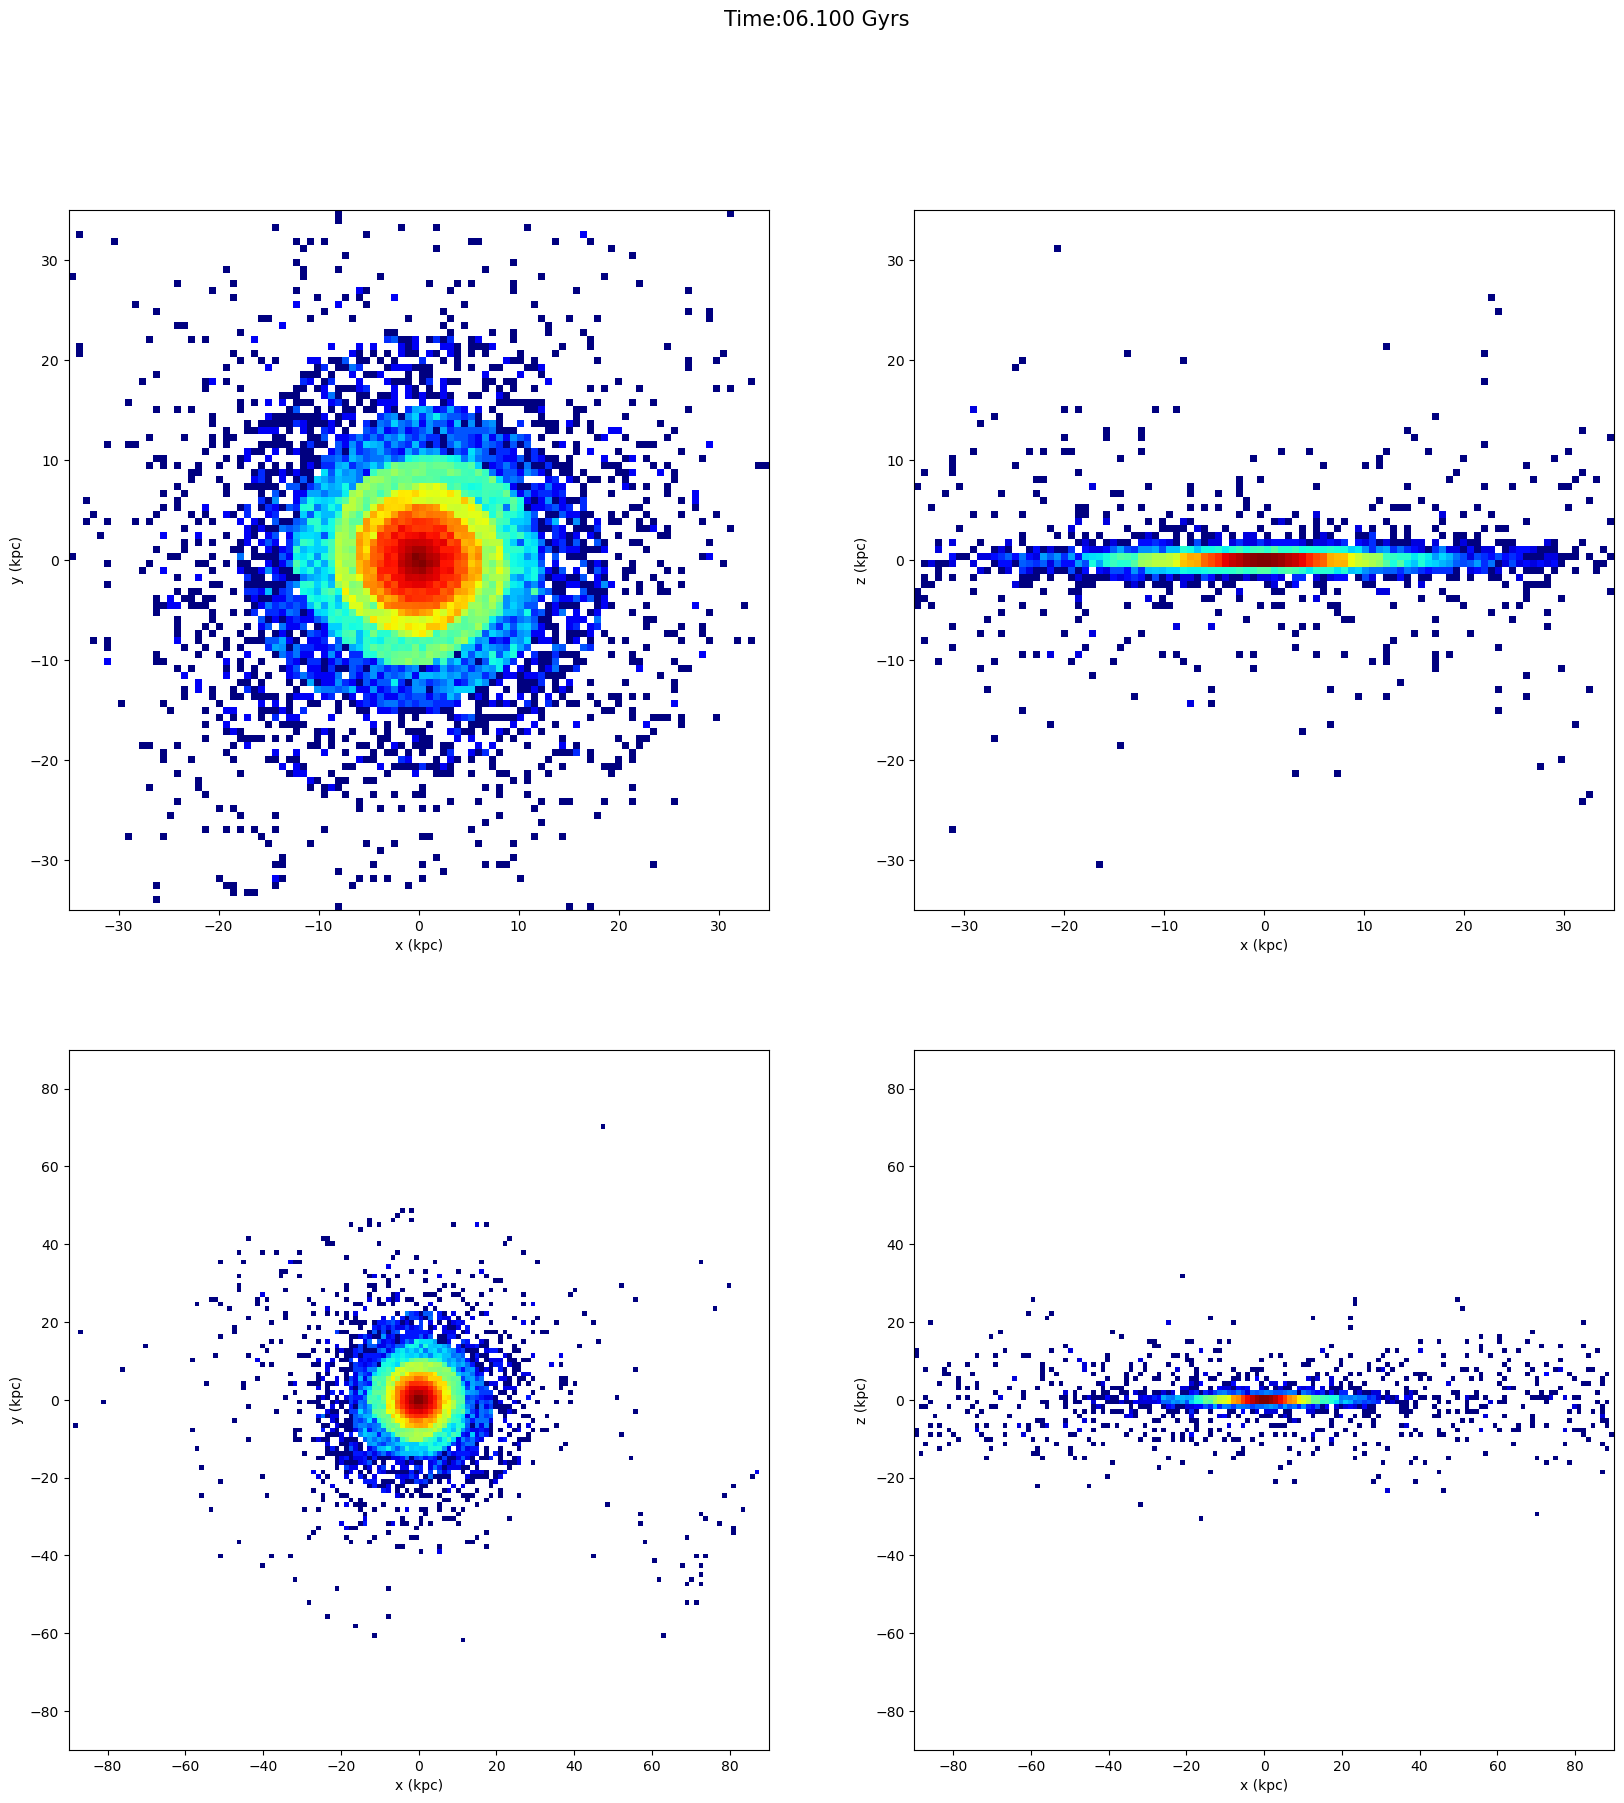

<Figure size 640x480 with 0 Axes>

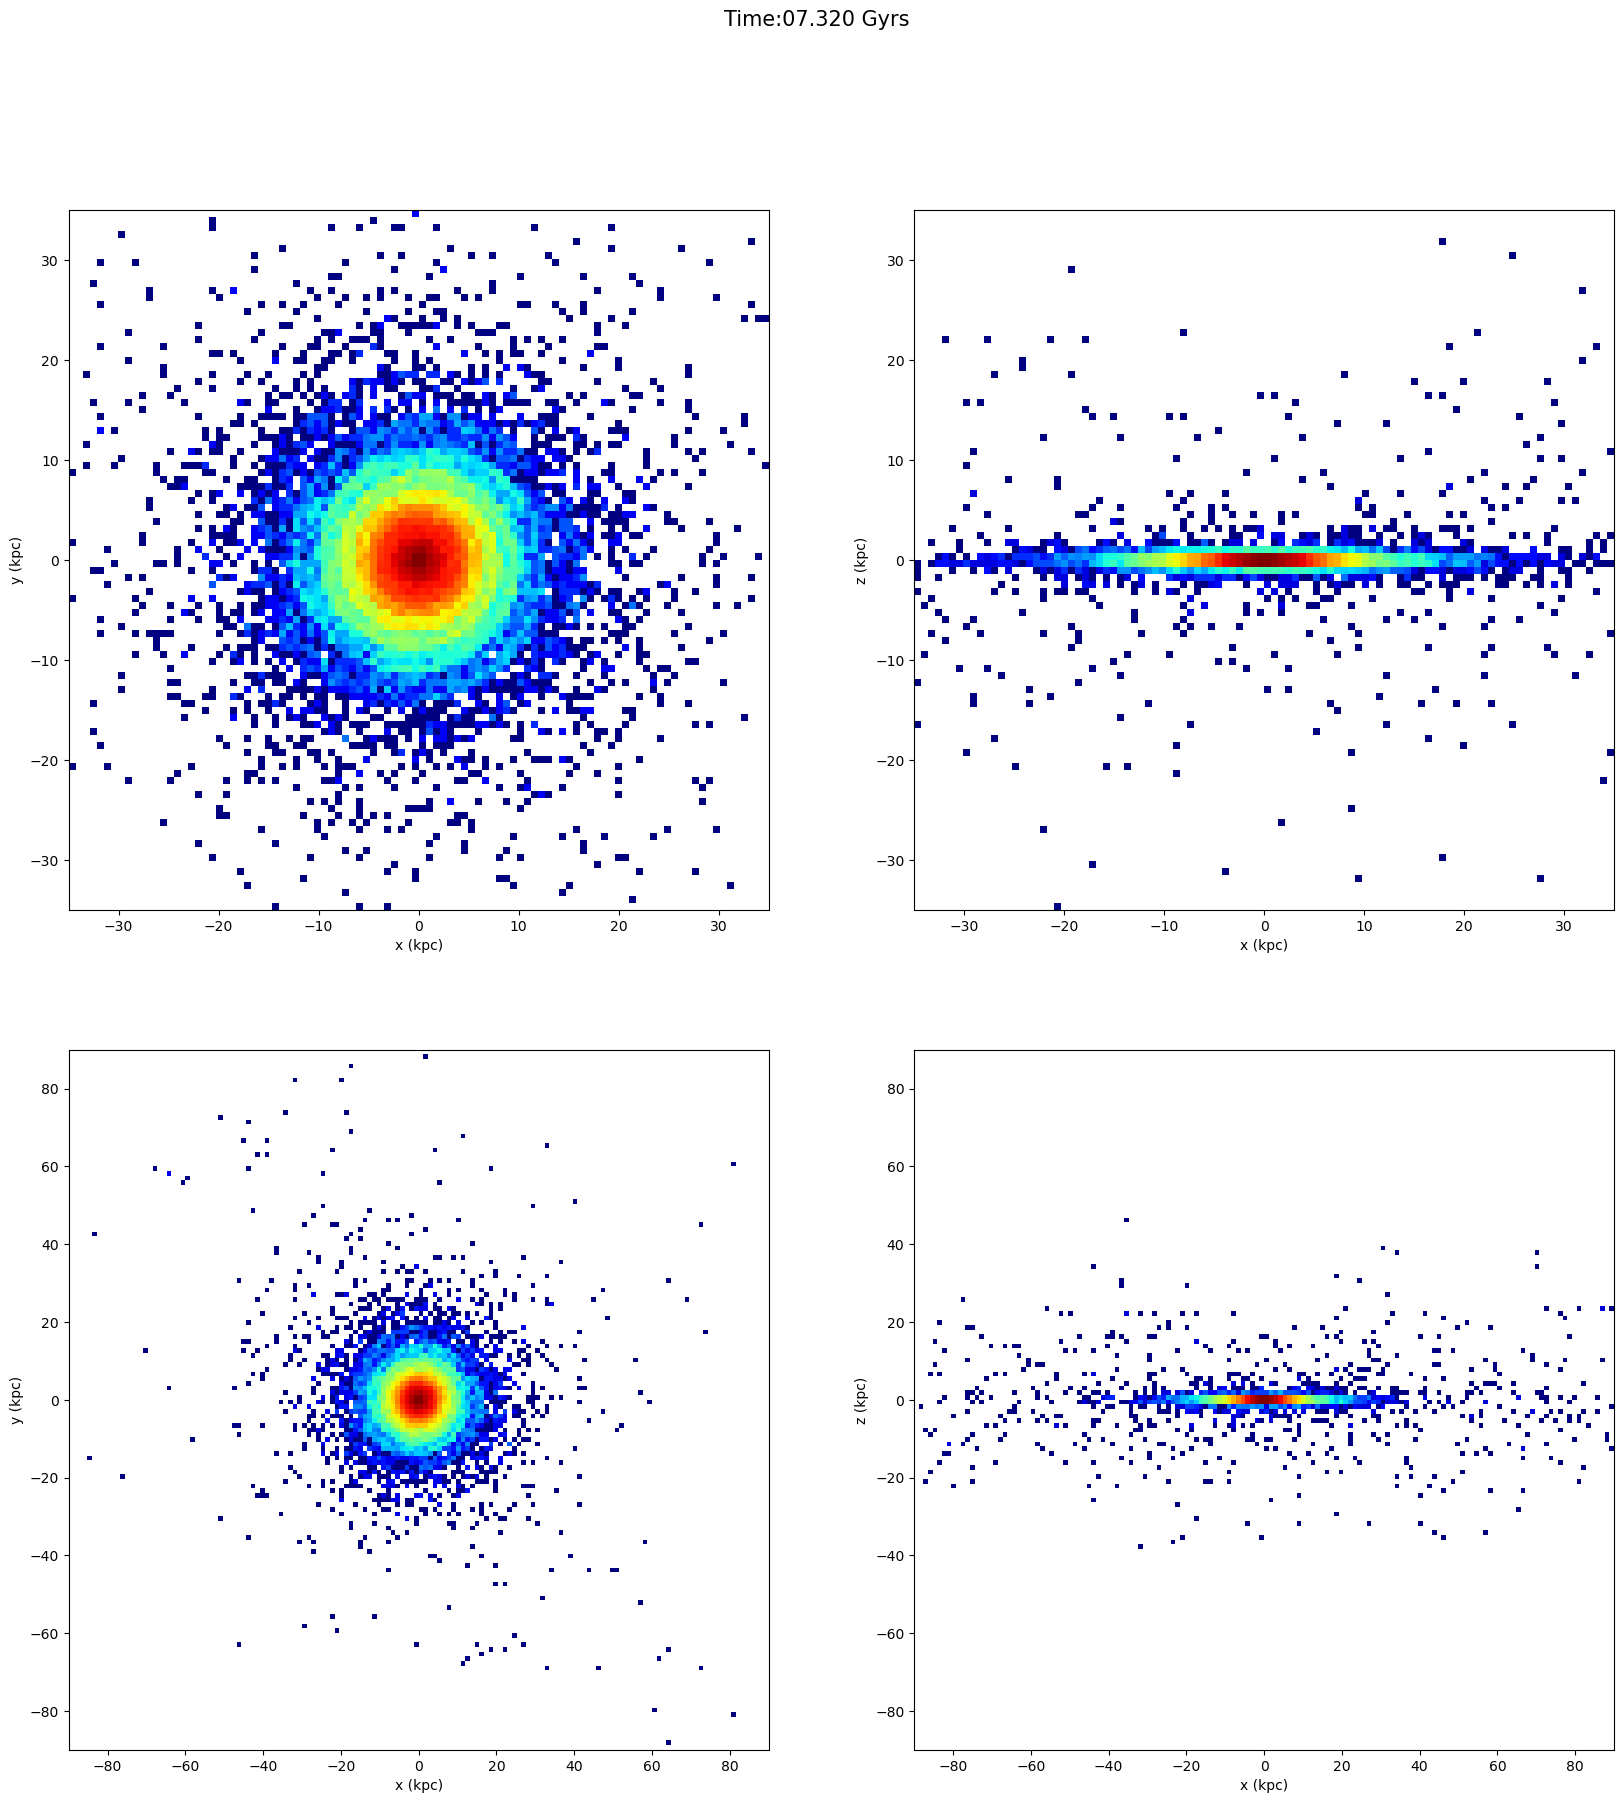

<Figure size 640x480 with 0 Axes>

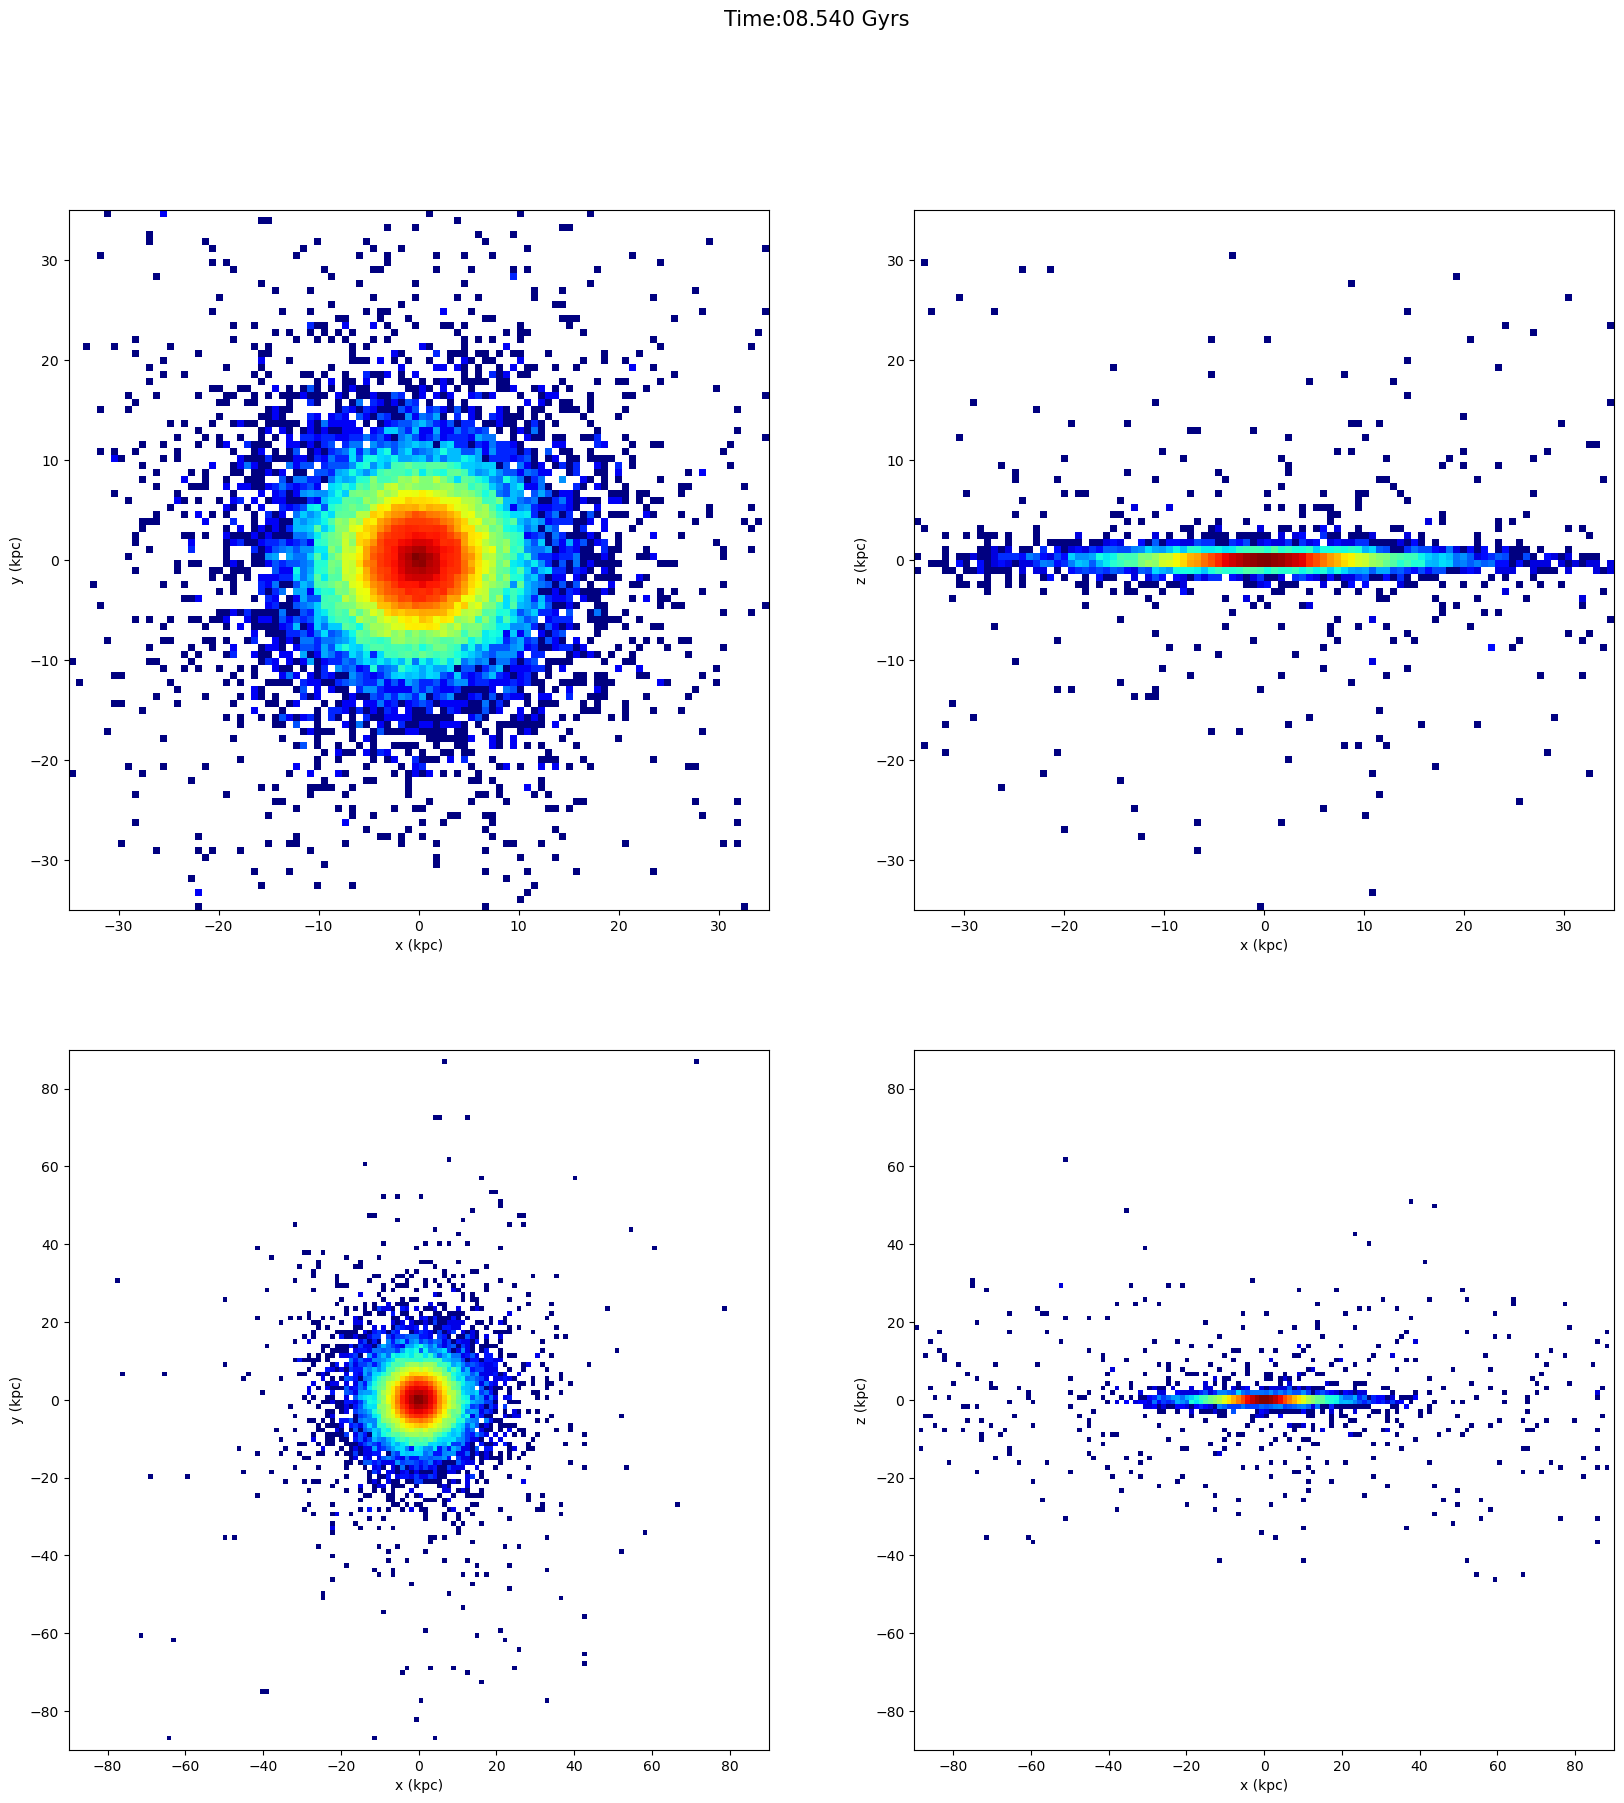

<Figure size 640x480 with 0 Axes>

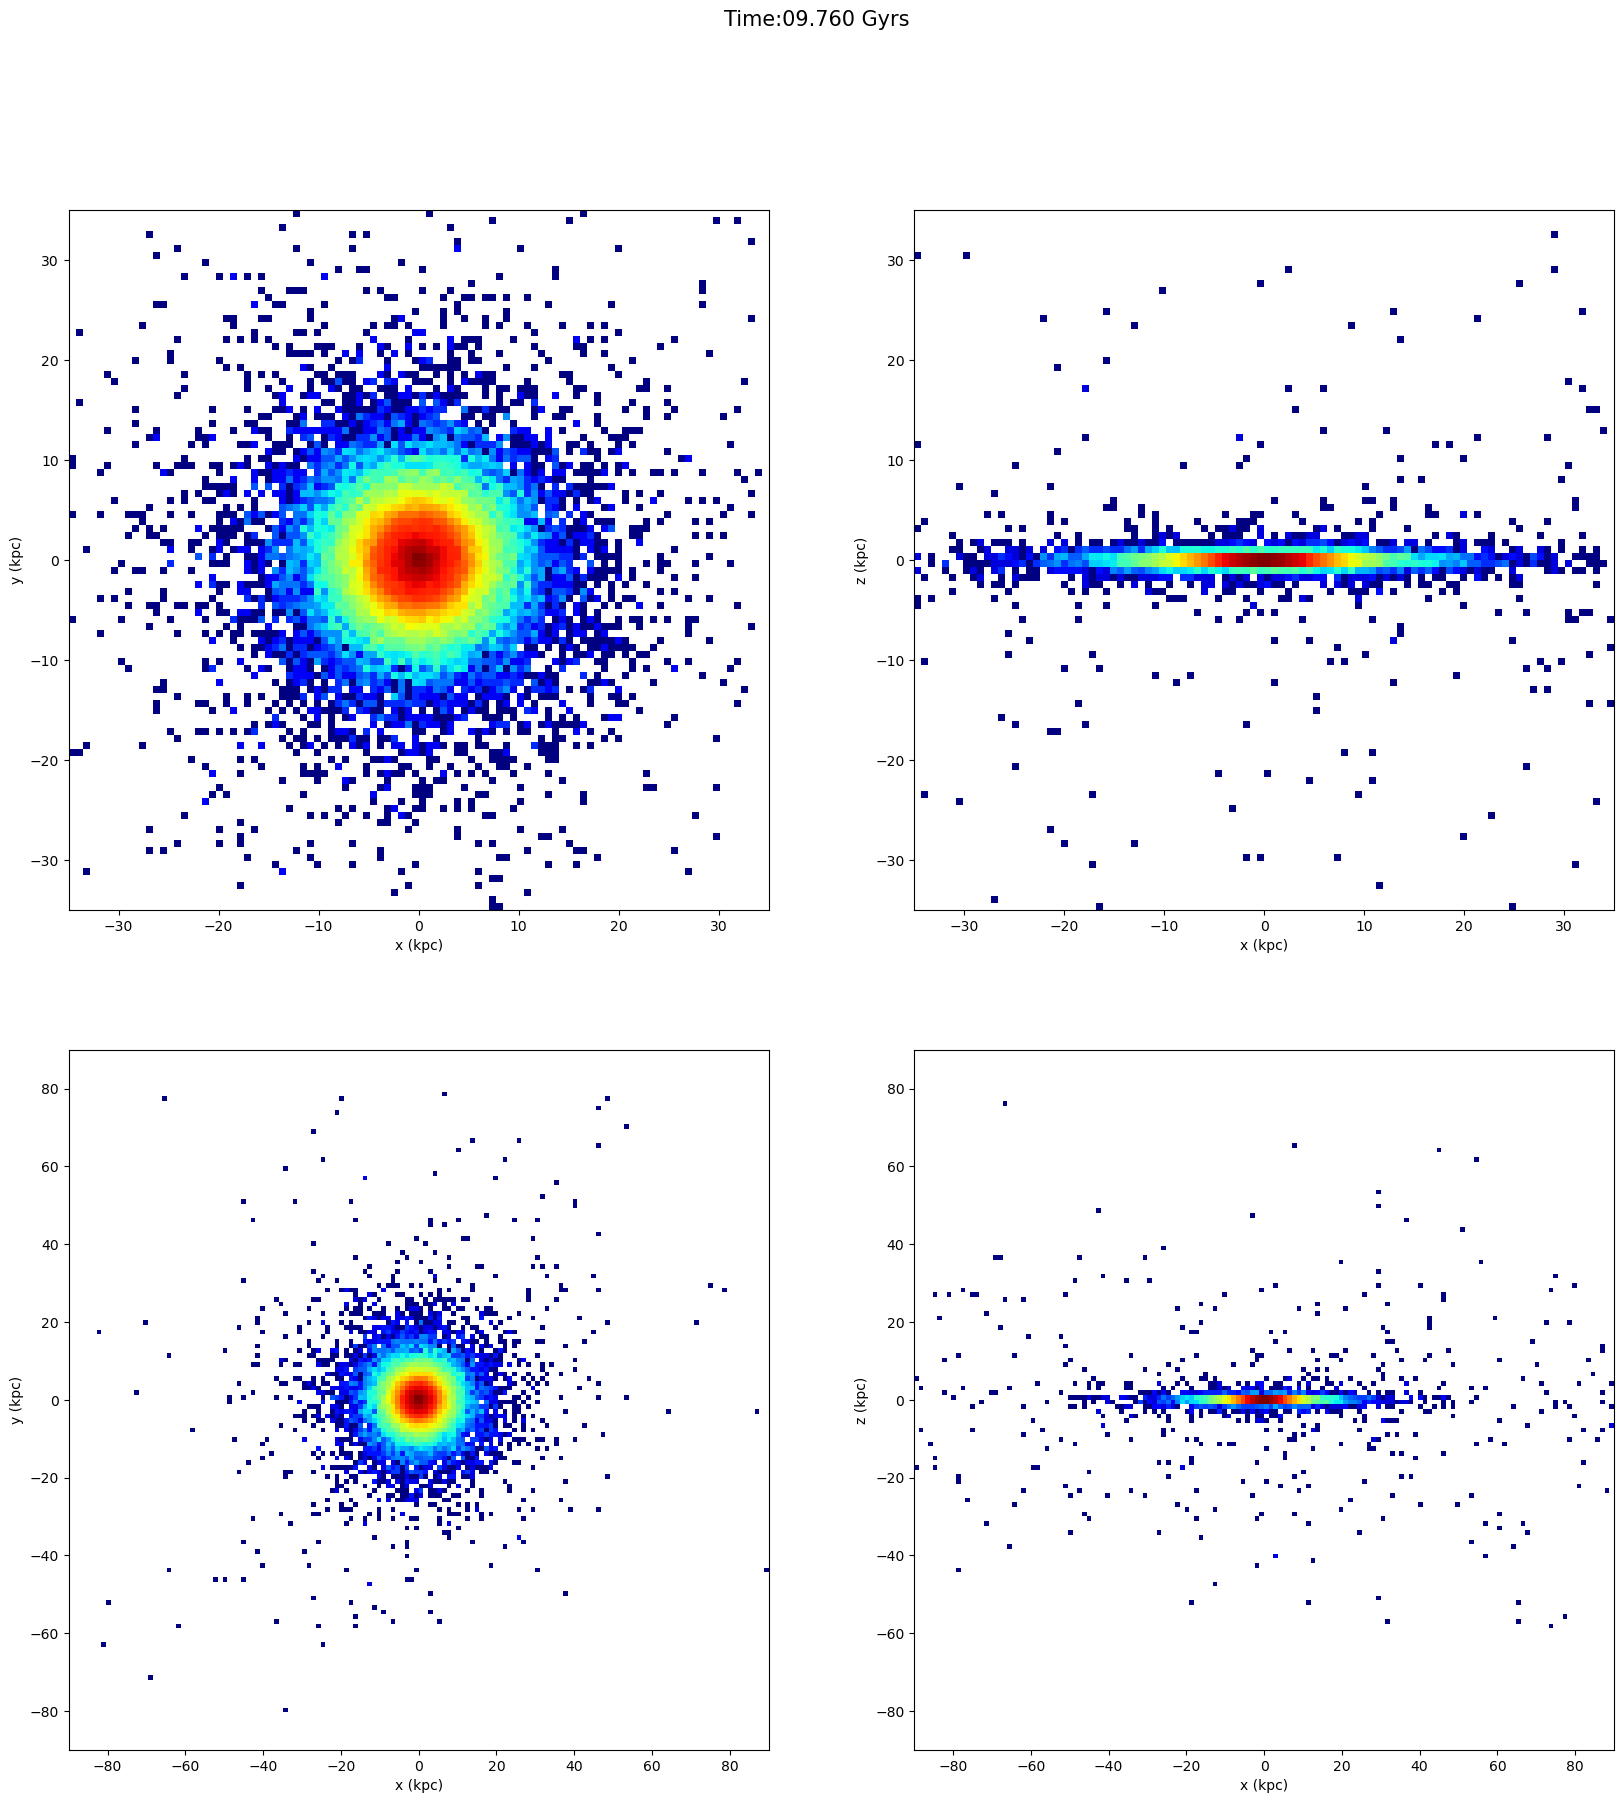

<Figure size 640x480 with 0 Axes>

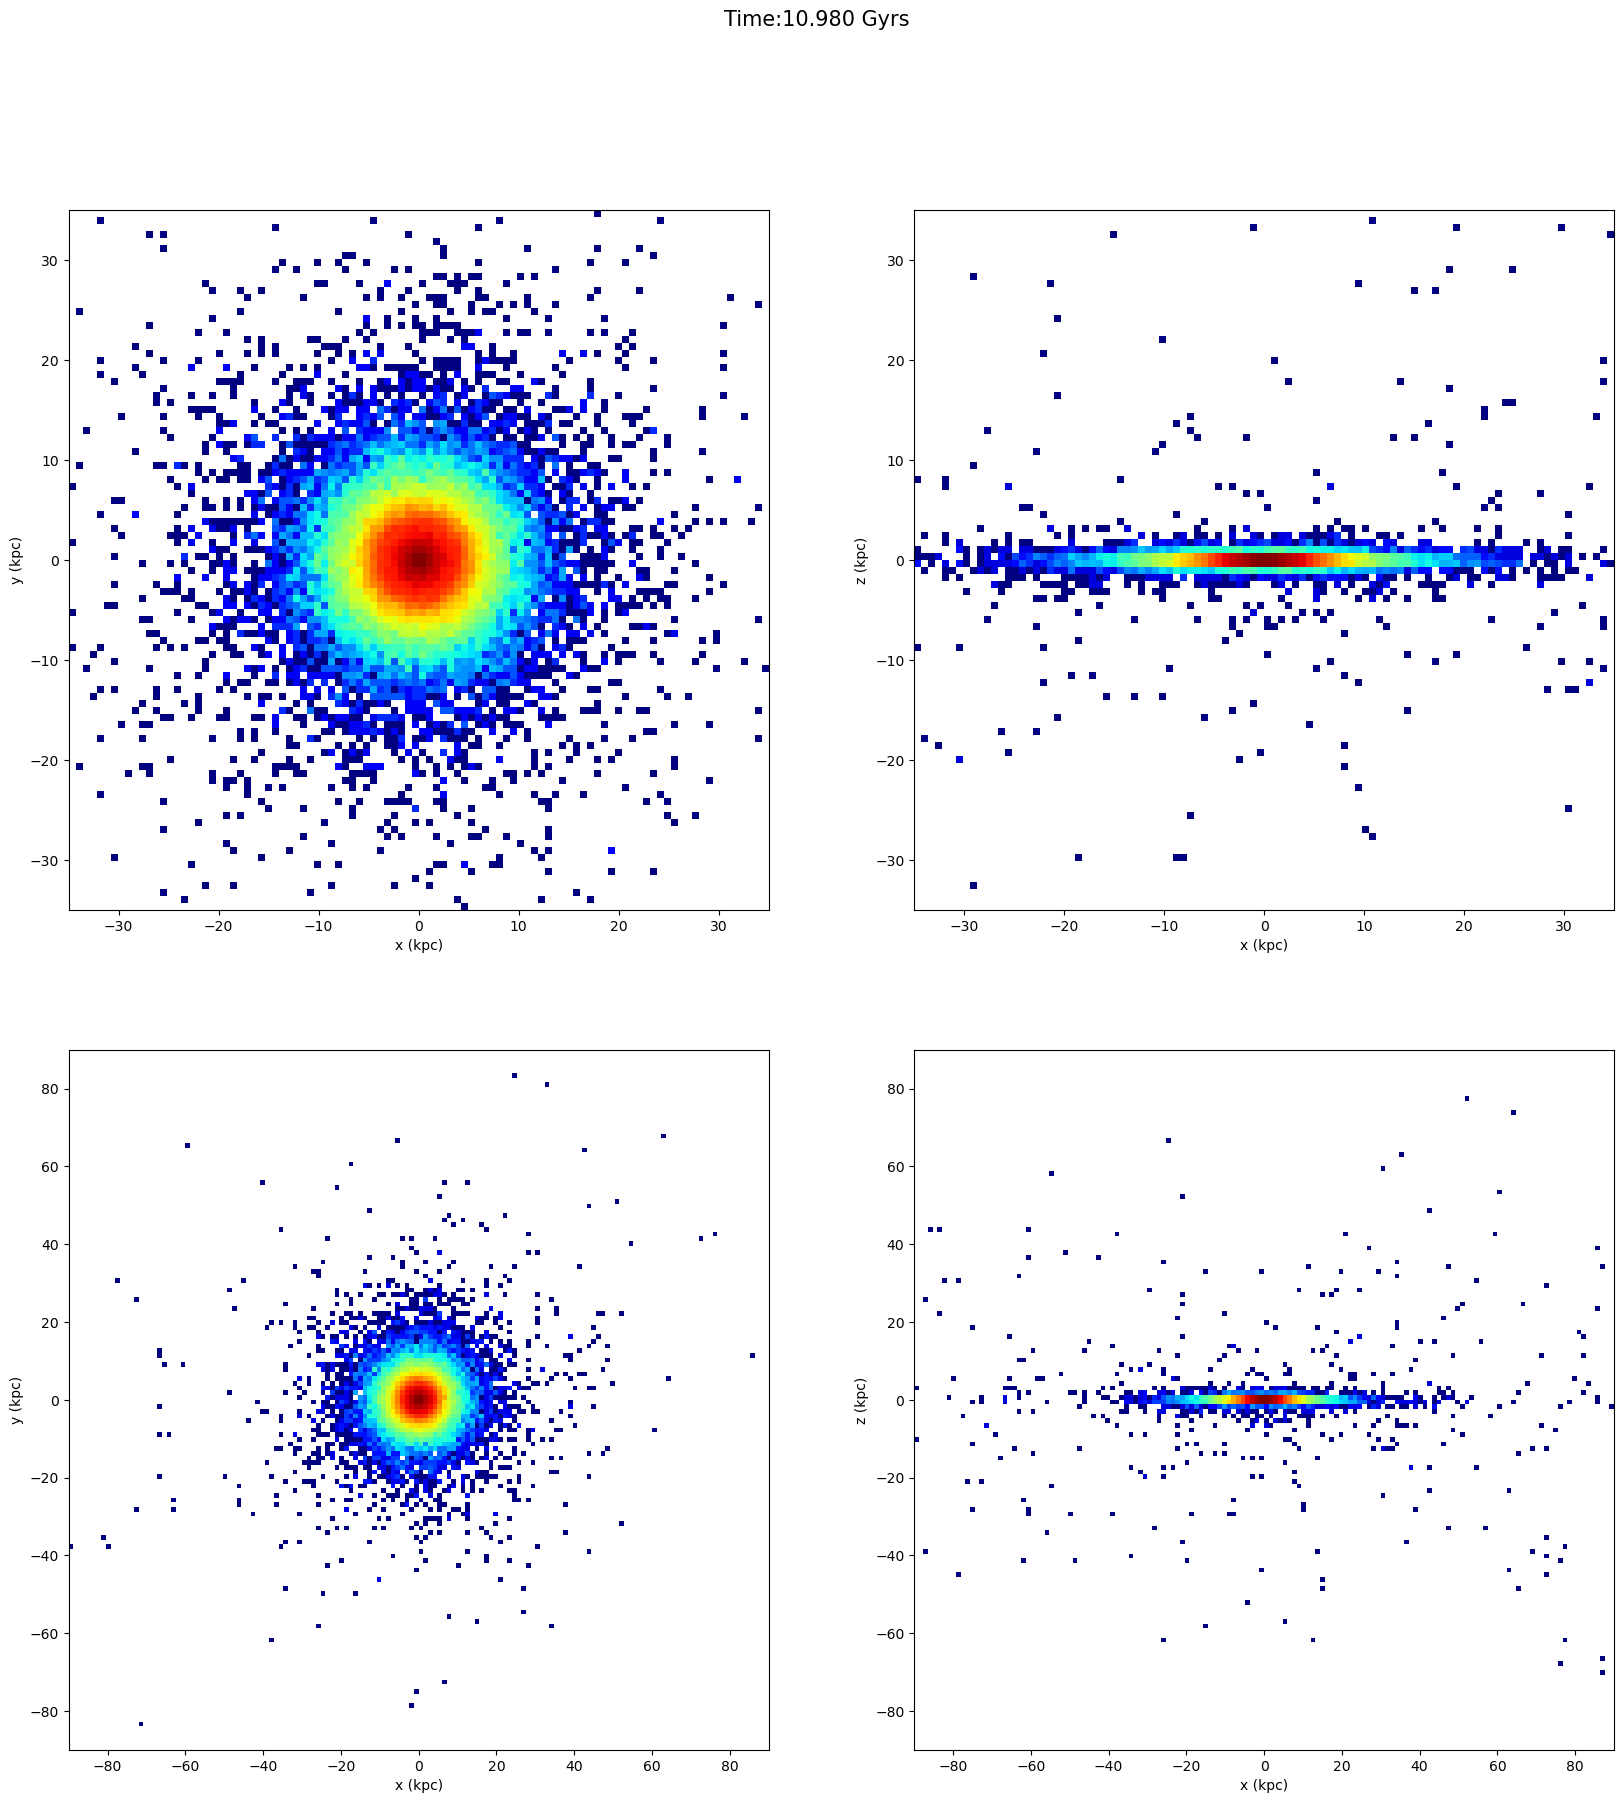

Equilibrium Value at Final Conditions (2T/W):1.5145685309328114


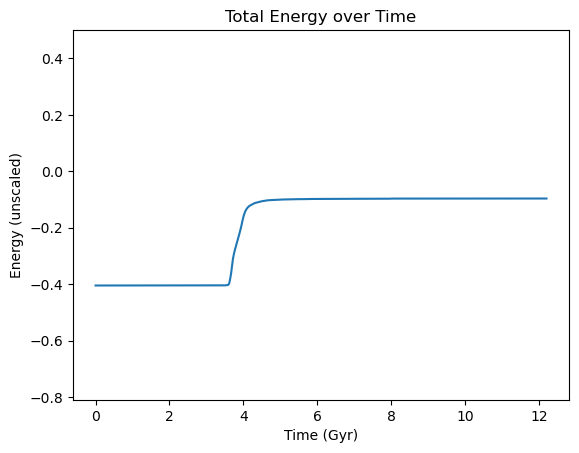

In [6]:
###### 3.5 ######
#### 3.5 - Galaxy Encounter

#### New Functions for this ####

# Function to compute the derivatives
def deriv_move(r, v, mover_pos):
    #r_mag = np.linalg.norm(r-mover_pos,axis=0)

    ## we can subtract arrays of different dimensions by adding an axis to the smaller array when subtracting the two vectors
    diff_vec = mover_pos[...,np.newaxis]-r
    #perturber_force = -particle_mass * perturber_mass / perturber_distance ** 3 * (cartesian_positions - perturber_position)
    m_mag = np.linalg.norm(diff_vec,axis=0)
    ## need new m_hat array for things to align properly
    ## mover_pos is the same for evaluated at every particle for the current time step
    ## so make an array full of the current mover position that is like the shape of the r & v arrays (NUMPART # of rows or columns(?))
    ## might be better way to do this but this is easiest

    #m_tmp = np.full_like(r[:],mover_pos)
    #m_hat = m_tmp/np.linalg.norm(m_tmp,axis=0)
    m_hat = mover_pos[...,np.newaxis]/m_mag
    #m_hat = mover_pos[...,np.newaxis]/np.linalg.norm(mover_pos)


    # then take the magnitude of this vector
    #r_mag = np.linalg.norm(diff_vec,axis=0)

    #m_force = NFW_mass*m_hat*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*m_mag)-(const_C*m_mag)/(1+const_C*m_mag))/(m_mag**2))
    # or the m_force is just m_hat... no mass involved, but then


    # maybe the force needs to be inclusive of mass, but 1/M or something?
    m_force = -NFW_mass/MASS*m_hat*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*m_mag)-(const_C*m_mag)/(1+const_C*m_mag))/(m_mag**2))
    #m_force = -NFW_mass/m_mag**3*m_hat

    r_mag = np.linalg.norm(r,axis=0)
    r_hat = r / r_mag
    dv_dt = r_hat*(-4*np.pi*const_P0)/(const_C**3)*((np.log(1+const_C*r_mag)-(const_C*r_mag)/(1+const_C*r_mag))/(r_mag**2))

    dv_dt = dv_dt+m_force
    dr_dt = v
    return dr_dt, dv_dt, m_force
# Function for leapfrog
def leapfrog_move(r,v,mover_pos,dt):
    # LEAPFROG METHOD
    rmid = r+(v*dt/2.)
    dr,dv,dmove = deriv_move(rmid,v,mover_pos)
    v_new = (v+(dv)*dt)
    #r_new = rmid+dr*dt/2
    r_new = rmid+v_new*dt/2.

    return r_new,v_new

## Function for graphing/saving simulation data
def plot_sim_mover(part_info,mover_pos,title,save=False):
    '''
    Make graphs of the results and show mover position,
    given particle_info array, mover position, title of graph, and save option (boolean)
    '''

    fig,axs = plt.subplots(2,2,figsize=(20,20))
    fig.suptitle(title, fontsize=15)

    axs[0,0].set_xlabel('x (kpc)')
    axs[0,0].set_ylabel('y (kpc)')
    #ax1.set_title(title)
    #xlim = const_R_scale/np.max(part_info[1,0]*const_R_scale)
    xlim = 35
    #ax1.xlim(-xlim_small,xlim_small)
    axs[0,0].hist2d(part_info[:,1]*const_R_scale,part_info[:,2]*const_R_scale,bins=(100,100),norm=LogNorm(),cmap=plt.cm.jet,range=[[-xlim,xlim],[-xlim,xlim]])
    axs[0,0].plot(mover_pos[0]*const_R_scale,mover_pos[1]*const_R_scale,'ro')
    axs[0,0].set_aspect('equal')

    axs[0,1].set_xlabel('x (kpc)')
    axs[0,1].set_ylabel('z (kpc)')
    #ax2.set_title(title)
    xlim = 35
    #ax1.xlim(-xlim_large,xlim_large)
    axs[0,1].hist2d(part_info[:,1]*const_R_scale,part_info[:,3]*const_R_scale,bins=(100,100),norm=LogNorm(),cmap=plt.cm.jet,range=[[-xlim,xlim],[-xlim,xlim]])
    axs[0,1].plot(mover_pos[0]*const_R_scale,mover_pos[2]*const_R_scale,'mo')
    axs[0,1].set_aspect('equal')

    axs[1,0].set_xlabel('x (kpc)')
    axs[1,0].set_ylabel('y (kpc)')
    #ax1.set_title(title)
    #xlim = const_R_scale/np.max(part_info[1,0]*const_R_scale)
    xlim = 90
    #ax1.xlim(-xlim_small,xlim_small)
    axs[1,0].hist2d(part_info[:,1]*const_R_scale,part_info[:,2]*const_R_scale,bins=(150,150),norm=LogNorm(),cmap=plt.cm.jet,range=[[-xlim,xlim],[-xlim,xlim]])
    axs[1,0].plot(mover_pos[0]*const_R_scale,mover_pos[1]*const_R_scale,'ro')
    axs[1,0].set_aspect('equal')

    axs[1,1].set_xlabel('x (kpc)')
    axs[1,1].set_ylabel('z (kpc)')
    #ax2.set_title(title)
    xlim = 90
    #ax1.xlim(-xlim_large,xlim_large)
    axs[1,1].hist2d(part_info[:,1]*const_R_scale,part_info[:,3]*const_R_scale,bins=(150,150),norm=LogNorm(),cmap=plt.cm.jet,range=[[-xlim,xlim],[-xlim,xlim]])
    axs[1,1].plot(mover_pos[0]*const_R_scale,mover_pos[2]*const_R_scale,'mo')
    axs[1,1].set_aspect('equal')


    if(save): # save files with proper name for frame
        plt.savefig(f'Sim_{title}.png',format='png')
    else:
        plt.show()

    plt.close(fig)
    plt.clf()

# first make a disk to be evolved
# then make a single large particle called the nfw halo

# rewrite the force calculations used in the leapfrog method
# or try to just take the vector distance between them before calculating the force and pass that value into leapfrog/force calculation

##### Setting initial parameters ########
NUMPART = 100000
RADIUS = 0.01
MASS = 0.04
NFW_mass = MASS/2
NFW_C = const_C = 40


#### NFW Particle creation ####
## make a large mass large radius particle
# hold the mass, center position, and center velocity in a particle info array
part_info_traveler = np.array([NFW_mass,3.,.1,0,-2,0,0])

print('-------------\n Creation of Disk Model....\n-----------')
part_info, pot_r_nfw, const_P0 = create_disk_vc_nfw(MASS,RADIUS,NUMPART,NFW_C)

part_mass = part_info[0,0]
sim_length = 5
lf_step = 5000                  ### Only value that gives reasonable result without being too big error



##### End of Setting initial parameters ########


#### Now integrate the model over the time period sim_length

# already created the NFW above so now just run the sim with finding e at every 10 or 100 steps
# need to rewrite the run_sim function to be only one axis at a time
px = part_info[:,1]
py = part_info[:,2]
pz = part_info[:,3]
r_0 = np.array([px,py,pz])
vx = part_info[:,4]
vy = part_info[:,5]
vz = part_info[:,6]
v_0 = np.array([vx,vy,vz])

calc_energy = lambda p,v: np.sum(part_mass*0.5*np.linalg.norm(v,axis=0)**2) + np.sum(part_mass*pot_r_nfw(np.linalg.norm(p,axis=0)))
calc_eq = lambda p,v: np.sum(part_mass*np.linalg.norm(v,axis=0)**2)/np.absolute(np.sum(part_mass*pot_r_nfw(np.linalg.norm(p,axis=0))))
# evolve each particle separately along the leapfrog method for each item in the time array
dt = sim_length/lf_step

#### For calculating energy
e_step = 10
e_init = calc_energy(r_0,v_0)

#### For seeing trend
s_step = 500
old_step = s_step

######### From Initial Conditions #########

########## Do the simulation ##################

print('-------------\n Evolving the Disk Model....\n-----------\n')
print(f'Equilibrium Value with initial Conditions (2T/W):{calc_eq(r_0,v_0)}')

e_calc = np.zeros(int(lf_step/e_step)) ## [[leapfrog],[l_t2],etc]
# set initial conditions for leapfrog
prev_r = r_0
prev_v = v_0
ind=0
# array for position of mover at t time
mover_pos = np.zeros((lf_step+1,3))
mover_pos[0] = part_info_traveler[1:4]
mover_vel = part_info_traveler[4:7]
for t in range(lf_step):
    # advance the mover position for the current time step
    mover_pos[t+1] = mover_pos[t]+mover_vel*dt
    if(t%e_step==0): # every 'e_step' # of steps, calc energy
        e_calc[ind] = calc_energy(prev_r,prev_v)
        ind+=1
    if(t>=1400 and t<=1700):
      # change the s_step to be more frequent so we can see collision
      s_step = 50
      if(t>=1700): # after collision return to plotting the new step rate
        s_step = old_step
    if(t%s_step==0): # graph the particle distribution every s_step
        zer = np.full(len(prev_r[0,:]),part_mass)
        part_info_tmp = np.array([zer,prev_r[0,:],prev_r[1,:],prev_r[2,:],prev_v[0,:],prev_v[1,:],prev_v[2,:]])
        part_info_new = part_info_tmp.T
        plot_sim_mover(part_info_new,mover_pos[t],('Time:%06.3f Gyrs' % (t*dt*const_T_scale)),save=False)
    r_new,v_new = leapfrog_move(prev_r,prev_v,mover_pos[t],dt)
    prev_r = r_new
    prev_v = v_new
###############################################

print(f'Equilibrium Value at Final Conditions (2T/W):{calc_eq(prev_r,prev_v)}')

########### Plot the total energy over time ##################
t = np.linspace(0,sim_length,len(e_calc))

plt.plot(t*const_T_scale,e_calc)
plt.ylim(2*np.min(e_calc),.5)
plt.xlabel('Time (Gyr)')
plt.ylabel('Energy (unscaled)')
plt.title('Total Energy over Time')
plt.show()


### 3.5 Analysis

- made a movie of it (attached)
- tried different starting conditions for the traveling galaxy
  - mass has great affect on the results of the galaxy
  - if mass was high it could completely strip the stationary galaxy of its matter and the energy would skyrocket
  - different positions and velocities seemed to changed how the galaxy responded and how quickly or slowly it went back to equilibrium
- We can see by the total energy graph that there is clearly a collision or some type of disruption even around 3.7 Gyrs, which is about T=3.66 Gyrs as we can see in the particle distribution graphs. 
- As the traveling galaxy comes near the stationary galaxy, we see it pulls the particles up and around the moving galaxy and almost gives the stationary one an immediate boost in angular momentum as it starts to rotate and create ripples.
- However, the ripples quickly dissapate as the disk stabilizes or attempts to do so.
- we can see that the disk doesn't fully stabilize because the particles are so sparse and spread out that it can't necessarily maintain it's equilibrium anymore.

- Later I would like to convert this simulation to a class (both the stationary and traveling galaxy) to incorporate it into a larger (simple) simulation library for easy referencing or just playing around with later.